In [1]:
import pandas as pd
import numpy as np
import re
import sys, getopt, os
import csv
import pickle
import copy

pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

%run SodaKick_download_functions.ipynb
%run torch_functions.ipynb

import copy

In [2]:
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.multioutput import MultiOutputRegressor

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from functools import partial 
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune import CLIReporter

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
#https://docs.ray.io/en/master/tune/tutorials/tune-xgboost.html

from hyperopt import hp

In [3]:
from sklearn import preprocessing

    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_inp_a_210614.pkl', 'rb') as pk:
    inp=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_out_a_210614.pkl', 'rb') as pk:
    out=pickle.load(pk)     
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_inp_b_210614.pkl', 'rb') as pk:
    inpb=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_out_b_210614.pkl', 'rb') as pk:
    outb=pickle.load(pk)     

inp=np.concatenate([inp,inpb])
out=np.concatenate([out,outb])

with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_lineup_a_210614.pkl', 'rb') as pk:
    lin=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_lineup_b_210614.pkl', 'rb') as pk:
    linb=pickle.load(pk)    

lin=np.concatenate([lin,linb])
lin2=[]
for i,l in enumerate(lin):
    lin2.append([x[0] for x in l])
lin=lin2

def normalize_mins(vec):
    for i in range(vec.shape[0]):
        vec[i][::8]=vec[i][::8]/90

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def NormalizeMatrix(data):   
    for i in range(data.shape[1]):
        data[:,i] = NormalizeData(data[:,i])
        
NormalizeMatrix(inp)
np.nan_to_num(inp, copy=False)

normalize_mins(out)

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


In [4]:
x_train, x_test, y_train, y_test = train_test_split(
     inp, out, test_size=0.3, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(
     x_train, y_train, test_size=0.3, shuffle=True)

def train_pytorch(config, model=Net, silent=True, checkpoint_dir=None):
    
    phases = ['train','val']
    
    
    drop_last=False
    if config['batchnorm']:
        drop_last=True
        
    #x_train, x_test, y_train, y_test = data[0], data[1], data[2], data[3]
    
    training_set = matchesDataset(x_train, y_train)
    trainBatch = torch.utils.data.DataLoader(training_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'], drop_last=drop_last)

    validation_set = matchesDataset(x_test, y_test)
    valBatch = torch.utils.data.DataLoader(validation_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'], drop_last=drop_last)

    earlStop = EarlyStopping(patience=config['patience'], keepBest=False)
    
    net = model(config['num_layers'], config['num_nodes'], config['scaling_factor'], 
                config['num_nodes_out'], config['final_activation'], config['dropout_percent'], config['batchnorm'])
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    if config['optim']=='adam':
        optimizer = Adam(net.parameters(), lr=config['lr'])
    elif config['optim']=='adagrad':
        optimizer = Adagrad(net.parameters(), lr=config['lr'])
    elif config['optim']=='rmsprop':
        optimizer = RMSprop(net.parameters(), lr=config['lr']) 
    else:
        print('optim error')
        return
    
    
    losses=[[],[]]
    mses=[]
    diffs=[]
    exit=False
    
    #for epoch in tqdm(range(epochs), desc='Epoch'):
    for epoch in range(config['epochs']):

        if exit:
            break
            
        for phase in phases:
            if phase == 'train':
                net.train(True) 

                """ Run the training of the model. """    

                losses_batch=[]
                for batchNum, batch in enumerate(trainBatch):

                    x = batch[0]
                    y = batch[1]

                    """ Move batches to GPU if available. """

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    """ Core of training. """
                    
                    loss = config['loss_f'](net(x), y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    if config['clip']:
                        net.clp()

                    losses_batch.append(loss)

                """ Early stop check. """

                earlStop(loss, net)
                finalepoch = epoch
                
                if earlStop.earlyStop:

                    if not silent:
                        print('Limit loss improvement reached, stopping the training.')
                        
                    exit=True 
                
                #losses[0].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
            else:
                net.train(False)
                net.eval()
                
                val_loss=0
                val_mse=0
      
                losses_batch=[]
                for batchNum, batch in enumerate(valBatch):

                    x = batch[0]
                    y = batch[1]

                    """ Move batches to GPU if available. """

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    """ Core of training. """

                    optimizer.zero_grad()
                    output=net(x)
                    target=y
                    loss = config['loss_f'](output, target)

                    #losses_batch.append(loss)
                    val_loss+=loss.detach().numpy()
                    val_mse+=nn.MSELoss()(output, target).detach().numpy()
                    
                #losses[1].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
                
                with tune.checkpoint_dir(epoch) as checkpoint_dir:
                    path = os.path.join(checkpoint_dir, "checkpoint")
                    torch.save((net.state_dict(), optimizer.state_dict()), path)

                tune.report(loss=(val_loss/batchNum), mse=(val_mse/batchNum))
                #tune.report(loss=torch.mean(torch.stack(losses_batch)))
                

def tune_pytorch(search_space, num_samples=25, gpus_per_trial=2): #
    
    search_alg = HyperOptSearch(space=search_space, metric="mse", mode="min")

        
    #scheduler = ASHAScheduler(
    #    metric="mse",#"loss",
    #    mode="min",
    #    max_t=max_num_epochs,
    #    grace_period=1,
    #    reduction_factor=2)
    
    reporter = CLIReporter(
        metric_columns=["loss", "mse", "training_iteration"])
    
    result = tune.run(
        train_pytorch,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        search_alg=search_alg,
        config=search_space,
        num_samples=num_samples,
        verbose=3,
        metric="mse", mode="min",
        #scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation mse: {}".format(
        best_trial.last_result["mse"]))

    best_trained_model = Net(best_trial.config['num_layers'], 
                             best_trial.config['num_nodes'], best_trial.config['scaling_factor'], 
                             best_trial.config['num_nodes_out'], best_trial.config['final_activation'],
                             best_trial.config['dropout_percent'], best_trial.config['batchnorm'])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    return result, best_trained_model
    #test_acc = test_accuracy(best_trained_model, device)
    #print("Best trial test set accuracy: {}".format(test_acc))

In [5]:
search_space = {
        "num_layers": hp.choice('num_layers',[1, 2, 3]),
        "num_nodes": inp.shape[1],
        "scaling_factor": hp.uniform('scaling_factor', 0.5, 1.5),
        "num_nodes_out": out.shape[1], 
        "final_activation" : None, #torch.tanh
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": hp.choice('batch_size',[8, 16, 32, 64]),
        "loss_f": nn.MSELoss(),#hp.choice('loss_f',[WSE, nn.MSELoss()]), #nn.L1Loss()
        "optim": 'adagrad',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 5e-2,
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100,
        "batchnorm": True,
        "dropout_percent": hp.choice('dropout_percent',[0, .1, .2, .25]),      
 }

In [31]:
analysis, btm = tune_pytorch(search_space, num_samples=100, gpus_per_trial=0)
best_cfg=analysis.get_best_config()
print(best_cfg)

with open(r'/Users/federico comitani/GitHub/sodakick/data/best_cfg_weight_210630.pkl', 'wb') as file:
    pickle.dump(best_cfg,file)

== Status ==
Memory usage on this node: 7.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 1/100 (1 PENDING)
+------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+
| Trial name             | status   | loc   |   batch_size | batchnorm   | clip   |   dropout_percent |   epochs | final_activation   | loss_f    |   lr |   num_layers |   num_nodes |   num_nodes_out |   num_workers | optim   |   patience |   scaling_factor | shuffle   |
|------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+-------------

2021-06-30 17:05:01,286	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 47833294 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-30 17:05:01,503	WARNING util.py:162 -- The `start_trial` operation took 1.205 s, which may be a performance bottleneck.
2021-06-30 17:05:03,013	WARNING util.py:162 -- The `start_trial` operation took 0.576 s, which may be a performance bottleneck.
2021-06-30 17:05:04,047	WARNING util.py:162 -- The `start_trial` operation took 0.909 s, which may be a performance bottleneck.
2021-06-30 17:05:05,795	WARNING util.py:162 -- The `start_trial` operation took 1.617 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 8.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 2/100 (2 RUNNING)
+------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+
| Trial name             | status   | loc   |   batch_size | batchnorm   | clip   |   dropout_percent |   epochs | final_activation   | loss_f    |   lr |   num_layers |   num_nodes |   num_nodes_out |   num_workers | optim   |   patience |   scaling_factor | shuffle   |
|------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+-----------

2021-06-30 17:05:07,897	WARNING util.py:162 -- The `start_trial` operation took 0.785 s, which may be a performance bottleneck.
2021-06-30 17:05:08,804	WARNING util.py:162 -- The `start_trial` operation took 0.770 s, which may be a performance bottleneck.
2021-06-30 17:05:11,062	WARNING util.py:162 -- The `start_trial` operation took 2.143 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.2/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 3/100 (3 RUNNING)
+------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+
| Trial name             | status   | loc   |   batch_size | batchnorm   | clip   |   dropout_percent |   epochs | final_activation   | loss_f    |   lr |   num_layers |   num_nodes |   num_nodes_out |   num_workers | optim   |   patience |   scaling_factor | shuffle   |
|------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+-----------

2021-06-30 17:05:13,070	WARNING util.py:162 -- The `start_trial` operation took 0.697 s, which may be a performance bottleneck.
2021-06-30 17:05:13,934	WARNING util.py:162 -- The `start_trial` operation took 0.759 s, which may be a performance bottleneck.
2021-06-30 17:05:14,670	WARNING util.py:162 -- The `start_trial` operation took 0.605 s, which may be a performance bottleneck.
2021-06-30 17:05:17,944	WARNING util.py:162 -- The `start_trial` operation took 3.159 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 4/100 (4 RUNNING)
+------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+
| Trial name             | status   | loc   |   batch_size | batchnorm   | clip   |   dropout_percent |   epochs | final_activation   | loss_f    |   lr |   num_layers |   num_nodes |   num_nodes_out |   num_workers | optim   |   patience |   scaling_factor | shuffle   |
|------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+-----------

2021-06-30 17:05:21,388	WARNING util.py:162 -- The `start_trial` operation took 1.366 s, which may be a performance bottleneck.
2021-06-30 17:05:22,628	WARNING util.py:162 -- The `start_trial` operation took 1.066 s, which may be a performance bottleneck.
2021-06-30 17:05:23,913	WARNING util.py:162 -- The `start_trial` operation took 1.150 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (1 PENDING, 4 RUNNING)
+------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+
| Trial name             | status   | loc   |   batch_size | batchnorm   | clip   |   dropout_percent |   epochs | final_activation   | loss_f    |   lr |   num_layers |   num_nodes |   num_nodes_out |   num_workers | optim   |   patience |   scaling_factor | shuffle   |
|------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+

2021-06-30 17:05:25,168	WARNING util.py:162 -- The `start_trial` operation took 1.081 s, which may be a performance bottleneck.
2021-06-30 17:05:26,134	WARNING util.py:162 -- The `start_trial` operation took 0.848 s, which may be a performance bottleneck.
2021-06-30 17:05:27,187	WARNING util.py:162 -- The `start_trial` operation took 0.936 s, which may be a performance bottleneck.
2021-06-30 17:05:27,939	WARNING util.py:162 -- The `start_trial` operation took 0.614 s, which may be a performance bottleneck.
2021-06-30 17:05:29,071	WARNING util.py:162 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (1 PENDING, 4 RUNNING)
+------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+
| Trial name             | status   | loc   |   batch_size | batchnorm   | clip   |   dropout_percent |   epochs | final_activation   | loss_f    |   lr |   num_layers |   num_nodes |   num_nodes_out |   num_workers | optim   |   patience |   scaling_factor | shuffle   |
|------------------------+----------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+

2021-06-30 17:05:29,845	WARNING util.py:162 -- The `start_trial` operation took 0.652 s, which may be a performance bottleneck.
2021-06-30 17:05:30,919	WARNING util.py:162 -- The `start_trial` operation took 0.957 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-05-30
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.147179783776749
  mse: 0.147179783776749
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 21.30565905570984
  time_this_iter_s: 21.30565905570984
  time_total_s: 21.30565905570984
  timestamp: 1625087130
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3ab087a
  


2021-06-30 17:05:31,627	WARNING util.py:162 -- The `start_trial` operation took 0.658 s, which may be a performance bottleneck.
2021-06-30 17:05:32,366	WARNING util.py:162 -- The `process_trial_save` operation took 0.726 s, which may be a performance bottleneck.
2021-06-30 17:05:33,137	WARNING util.py:162 -- The `start_trial` operation took 0.706 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-05-37
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.3028674104879069
  mse: 0.3028674104879069
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 9.424084901809692
  time_this_iter_s: 9.424084901809692
  time_total_s: 9.424084901809692
  timestamp: 1625087137
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d3ab087a with mse=0.147179783776749 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.9326306201055248, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 32, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'pat

2021-06-30 17:05:38,234	WARNING util.py:162 -- The `start_trial` operation took 0.548 s, which may be a performance bottleneck.
2021-06-30 17:05:38,901	WARNING util.py:162 -- The `process_trial_save` operation took 0.648 s, which may be a performance bottleneck.
2021-06-30 17:05:39,572	WARNING util.py:162 -- The `start_trial` operation took 0.660 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-05-51
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.1080604211189026
  mse: 0.1080604211189026
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 42.25177812576294
  time_this_iter_s: 20.9461190700531
  time_total_s: 42.25177812576294
  timestamp: 1625087151
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d3ab087a with mse=0.1080604211189026 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.9326306201055248, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 32, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'pat

2021-06-30 17:05:52,315	WARNING util.py:162 -- The `start_trial` operation took 0.592 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-05-51
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.20299063796220823
  mse: 0.20299063796220823
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 23.518190145492554
  time_this_iter_s: 14.094105243682861
  time_total_s: 23.518190145492554
  timestamp: 1625087151
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: db631396
  


2021-06-30 17:05:53,615	WARNING util.py:162 -- The `start_trial` operation took 1.261 s, which may be a performance bottleneck.
2021-06-30 17:05:54,903	WARNING util.py:162 -- The `process_trial_save` operation took 1.282 s, which may be a performance bottleneck.
2021-06-30 17:05:56,034	WARNING util.py:162 -- The `start_trial` operation took 1.108 s, which may be a performance bottleneck.
2021-06-30 17:05:57,280	WARNING util.py:162 -- The `process_trial_save` operation took 1.234 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d3ab087a with mse=0.1080604211189026 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.9326306201055248, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 32, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (1 PENDING, 4 RUNNING)
+------------------------+----------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+----------+----------+--------

2021-06-30 17:05:58,215	WARNING util.py:162 -- The `start_trial` operation took 0.897 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-05-55
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.058088787590687196
  mse: 0.058088787590687196
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 33.00000309944153
  time_this_iter_s: 33.00000309944153
  time_total_s: 33.00000309944153
  timestamp: 1625087155
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d838d48a
  


2021-06-30 17:05:58,797	WARNING util.py:162 -- The `start_trial` operation took 0.543 s, which may be a performance bottleneck.
2021-06-30 17:05:59,771	WARNING util.py:162 -- The `process_trial_save` operation took 0.961 s, which may be a performance bottleneck.
2021-06-30 17:06:00,373	WARNING util.py:162 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-05-59
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.14942971068654168
  mse: 0.14942971068654168
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 43.56628203392029
  time_this_iter_s: 43.56628203392029
  time_total_s: 43.56628203392029
  timestamp: 1625087159
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d5a748fa
  


2021-06-30 17:06:01,258	WARNING util.py:162 -- The `start_trial` operation took 0.837 s, which may be a performance bottleneck.
2021-06-30 17:06:01,883	WARNING util.py:162 -- The `process_trial_save` operation took 0.615 s, which may be a performance bottleneck.
2021-06-30 17:06:02,745	WARNING util.py:162 -- The `start_trial` operation took 0.623 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-06-11
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.15557680088420248
  mse: 0.15557680088420248
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 43.62628412246704
  time_this_iter_s: 20.108093976974487
  time_total_s: 43.62628412246704
  timestamp: 1625087171
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.058088787590687196 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:06:13,464	WARNING util.py:162 -- The `start_trial` operation took 1.572 s, which may be a performance bottleneck.
2021-06-30 17:06:15,477	WARNING util.py:162 -- The `process_trial_save` operation took 2.009 s, which may be a performance bottleneck.
2021-06-30 17:06:17,303	WARNING util.py:162 -- The `start_trial` operation took 1.486 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-06-23
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.08997822674207909
  mse: 0.08997822674207909
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 73.74869894981384
  time_this_iter_s: 31.496920824050903
  time_total_s: 73.74869894981384
  timestamp: 1625087183
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.058088787590687196 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:06:24,910	WARNING util.py:162 -- The `process_trial_save` operation took 1.338 s, which may be a performance bottleneck.
2021-06-30 17:06:25,707	WARNING util.py:162 -- The `start_trial` operation took 0.795 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-06-30
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.1272686825588692
  mse: 0.1272686825588692
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 62.193467140197754
  time_this_iter_s: 18.567183017730713
  time_total_s: 62.193467140197754
  timestamp: 1625087190
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.058088787590687196 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:06:31,100	WARNING util.py:162 -- The `start_trial` operation took 0.623 s, which may be a performance bottleneck.
2021-06-30 17:06:32,147	WARNING util.py:162 -- The `process_trial_save` operation took 1.044 s, which may be a performance bottleneck.
2021-06-30 17:06:33,465	WARNING util.py:162 -- The `start_trial` operation took 1.270 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-06-45
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.056706006356169666
  mse: 0.056706006356169666
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 82.9692931175232
  time_this_iter_s: 49.969290018081665
  time_total_s: 82.9692931175232
  timestamp: 1625087205
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d838d48a
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.056706006356169666 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:06:46,692	WARNING util.py:162 -- The `start_trial` operation took 0.911 s, which may be a performance bottleneck.
2021-06-30 17:06:48,315	WARNING util.py:162 -- The `process_trial_save` operation took 1.562 s, which may be a performance bottleneck.
2021-06-30 17:06:49,390	WARNING util.py:162 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-06-45
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.10790418088436127
  mse: 0.10790418088436127
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 77.65150904655457
  time_this_iter_s: 15.458041906356812
  time_total_s: 77.65150904655457
  timestamp: 1625087205
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: db631396
  


2021-06-30 17:06:50,325	WARNING util.py:162 -- The `start_trial` operation took 0.888 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-06-49
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.08146964550711387
  mse: 0.08146964550711387
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 100.25136208534241
  time_this_iter_s: 26.502663135528564
  time_total_s: 100.25136208534241
  timestamp: 1625087209
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: d3ab087a
  


2021-06-30 17:06:50,910	WARNING util.py:162 -- The `start_trial` operation took 0.527 s, which may be a performance bottleneck.
2021-06-30 17:06:51,707	WARNING util.py:162 -- The `process_trial_save` operation took 0.782 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.056706006356169666 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (1 PENDING, 4 RUNNING)
+------------------------+----------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+----

2021-06-30 17:06:52,702	WARNING util.py:162 -- The `start_trial` operation took 0.940 s, which may be a performance bottleneck.
2021-06-30 17:06:53,418	WARNING util.py:162 -- The `process_trial_save` operation took 0.710 s, which may be a performance bottleneck.
2021-06-30 17:06:54,092	WARNING util.py:162 -- The `start_trial` operation took 0.666 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-06-58
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.10462977389773626
  mse: 0.10462977389773626
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 102.14912486076355
  time_this_iter_s: 58.58284282684326
  time_total_s: 102.14912486076355
  timestamp: 1625087218
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: d5a748fa
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.056706006356169666 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:06:58,694	WARNING util.py:162 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.
2021-06-30 17:06:59,497	WARNING util.py:162 -- The `process_trial_save` operation took 0.776 s, which may be a performance bottleneck.
2021-06-30 17:07:00,342	WARNING util.py:162 -- The `start_trial` operation took 0.794 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-07-04
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.0951999718713206
  mse: 0.0951999718713206
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 96.02398204803467
  time_this_iter_s: 18.372473001480103
  time_total_s: 96.02398204803467
  timestamp: 1625087224
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.056706006356169666 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:07:05,214	WARNING util.py:162 -- The `start_trial` operation took 0.930 s, which may be a performance bottleneck.
2021-06-30 17:07:06,118	WARNING util.py:162 -- The `process_trial_save` operation took 0.897 s, which may be a performance bottleneck.
2021-06-30 17:07:07,066	WARNING util.py:162 -- The `start_trial` operation took 0.930 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-07-11
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.07654323983331059
  mse: 0.07654323983331059
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 122.3127760887146
  time_this_iter_s: 22.061414003372192
  time_total_s: 122.3127760887146
  timestamp: 1625087231
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.056706006356169666 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:07:13,025	WARNING util.py:162 -- The `start_trial` operation took 1.213 s, which may be a performance bottleneck.
2021-06-30 17:07:13,948	WARNING util.py:162 -- The `process_trial_save` operation took 0.855 s, which may be a performance bottleneck.
2021-06-30 17:07:14,817	WARNING util.py:162 -- The `start_trial` operation took 0.866 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-07-20
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.08505588180797044
  mse: 0.08505588180797044
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 111.98439812660217
  time_this_iter_s: 15.960416078567505
  time_total_s: 111.98439812660217
  timestamp: 1625087240
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.056706006356169666 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:07:20,953	WARNING util.py:162 -- The `start_trial` operation took 0.695 s, which may be a performance bottleneck.
2021-06-30 17:07:21,506	WARNING util.py:162 -- The `process_trial_save` operation took 0.551 s, which may be a performance bottleneck.
2021-06-30 17:07:22,495	WARNING util.py:162 -- The `start_trial` operation took 0.973 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-07-22
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.05616629328787996
  mse: 0.05616629328787996
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 119.46798324584961
  time_this_iter_s: 36.498690128326416
  time_total_s: 119.46798324584961
  timestamp: 1625087242
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: d838d48a
  


2021-06-30 17:07:23,409	WARNING util.py:162 -- The `start_trial` operation took 0.745 s, which may be a performance bottleneck.
2021-06-30 17:07:24,038	WARNING util.py:162 -- The `process_trial_save` operation took 0.605 s, which may be a performance bottleneck.
2021-06-30 17:07:24,943	WARNING util.py:162 -- The `start_trial` operation took 0.865 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-07-31
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.0792258437289748
  mse: 0.0792258437289748
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 123.22416114807129
  time_this_iter_s: 11.239763021469116
  time_total_s: 123.22416114807129
  timestamp: 1625087251
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05616629328787996 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:07:32,533	WARNING util.py:162 -- The `process_trial_save` operation took 0.690 s, which may be a performance bottleneck.
2021-06-30 17:07:33,295	WARNING util.py:162 -- The `start_trial` operation took 0.742 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-07-33
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.07089573924624643
  mse: 0.07089573924624643
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 143.56987023353577
  time_this_iter_s: 21.257094144821167
  time_total_s: 143.56987023353577
  timestamp: 1625087253
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: d3ab087a
  


2021-06-30 17:07:34,061	WARNING util.py:162 -- The `start_trial` operation took 0.641 s, which may be a performance bottleneck.
2021-06-30 17:07:34,917	WARNING util.py:162 -- The `process_trial_save` operation took 0.842 s, which may be a performance bottleneck.
2021-06-30 17:07:35,590	WARNING util.py:162 -- The `start_trial` operation took 0.663 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-07-40
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.08757706007428384
  mse: 0.08757706007428384
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 144.9688138961792
  time_this_iter_s: 42.81968903541565
  time_total_s: 144.9688138961792
  timestamp: 1625087260
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: d5a748fa
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05616629328787996 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:07:42,001	WARNING util.py:162 -- The `process_trial_save` operation took 0.678 s, which may be a performance bottleneck.
2021-06-30 17:07:42,806	WARNING util.py:162 -- The `start_trial` operation took 0.777 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-07-41
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.07409774650667988
  mse: 0.07409774650667988
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 132.90846014022827
  time_this_iter_s: 9.684298992156982
  time_total_s: 132.90846014022827
  timestamp: 1625087261
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: db631396
  


2021-06-30 17:07:43,504	WARNING util.py:162 -- The `start_trial` operation took 0.647 s, which may be a performance bottleneck.
2021-06-30 17:07:44,206	WARNING util.py:162 -- The `process_trial_save` operation took 0.695 s, which may be a performance bottleneck.
2021-06-30 17:07:45,175	WARNING util.py:162 -- The `start_trial` operation took 0.807 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-07-49
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.06976917273429938
  mse: 0.06976917273429938
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 160.06858110427856
  time_this_iter_s: 16.498710870742798
  time_total_s: 160.06858110427856
  timestamp: 1625087269
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05616629328787996 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:07:50,348	WARNING util.py:162 -- The `start_trial` operation took 0.823 s, which may be a performance bottleneck.
2021-06-30 17:07:51,492	WARNING util.py:162 -- The `process_trial_save` operation took 1.108 s, which may be a performance bottleneck.
2021-06-30 17:07:52,413	WARNING util.py:162 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-07-51
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.0555155234976431
  mse: 0.0555155234976431
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 148.27313709259033
  time_this_iter_s: 28.805153846740723
  time_total_s: 148.27313709259033
  timestamp: 1625087271
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: d838d48a
  


2021-06-30 17:07:53,143	WARNING util.py:162 -- The `start_trial` operation took 0.695 s, which may be a performance bottleneck.
2021-06-30 17:07:53,810	WARNING util.py:162 -- The `process_trial_save` operation took 0.659 s, which may be a performance bottleneck.
2021-06-30 17:07:54,597	WARNING util.py:162 -- The `start_trial` operation took 0.783 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-07-53
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.06952602554892384
  mse: 0.06952602554892384
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 145.00568008422852
  time_this_iter_s: 12.097219944000244
  time_total_s: 145.00568008422852
  timestamp: 1625087273
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.0555155234976431 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:07:55,559	WARNING util.py:162 -- The `start_trial` operation took 0.800 s, which may be a performance bottleneck.
2021-06-30 17:07:56,360	WARNING util.py:162 -- The `process_trial_save` operation took 0.791 s, which may be a performance bottleneck.
2021-06-30 17:07:57,240	WARNING util.py:162 -- The `start_trial` operation took 0.871 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-08-05
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.06691785520592401
  mse: 0.06691785520592401
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 157.67407512664795
  time_this_iter_s: 12.668395042419434
  time_total_s: 157.67407512664795
  timestamp: 1625087285
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.0555155234976431 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:08:06,694	WARNING util.py:162 -- The `start_trial` operation took 0.728 s, which may be a performance bottleneck.
2021-06-30 17:08:07,583	WARNING util.py:162 -- The `process_trial_save` operation took 0.867 s, which may be a performance bottleneck.
2021-06-30 17:08:08,333	WARNING util.py:162 -- The `start_trial` operation took 0.729 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-08-07
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.06673209282547929
  mse: 0.06673209282547929
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 178.10111713409424
  time_this_iter_s: 18.032536029815674
  time_total_s: 178.10111713409424
  timestamp: 1625087287
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: d3ab087a
  


2021-06-30 17:08:09,243	WARNING util.py:162 -- The `start_trial` operation took 0.878 s, which may be a performance bottleneck.
2021-06-30 17:08:10,002	WARNING util.py:162 -- The `process_trial_save` operation took 0.747 s, which may be a performance bottleneck.
2021-06-30 17:08:10,887	WARNING util.py:162 -- The `start_trial` operation took 0.876 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-08-16
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.07873168244455638
  mse: 0.07873168244455638
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 180.56475973129272
  time_this_iter_s: 35.595945835113525
  time_total_s: 180.56475973129272
  timestamp: 1625087296
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: d5a748fa
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.0555155234976431 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:08:17,232	WARNING util.py:162 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.
2021-06-30 17:08:18,094	WARNING util.py:162 -- The `process_trial_save` operation took 0.838 s, which may be a performance bottleneck.
2021-06-30 17:08:18,982	WARNING util.py:162 -- The `start_trial` operation took 0.852 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-08-17
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.0664509086934633
  mse: 0.0664509086934633
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 168.8521740436554
  time_this_iter_s: 11.178098917007446
  time_total_s: 168.8521740436554
  timestamp: 1625087297
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: db631396
  


2021-06-30 17:08:19,874	WARNING util.py:162 -- The `start_trial` operation took 0.850 s, which may be a performance bottleneck.
2021-06-30 17:08:20,562	WARNING util.py:162 -- The `process_trial_save` operation took 0.670 s, which may be a performance bottleneck.
2021-06-30 17:08:21,638	WARNING util.py:162 -- The `start_trial` operation took 1.061 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-08-22
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.055309541711813945
  mse: 0.055309541711813945
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 179.48632407188416
  time_this_iter_s: 31.213186979293823
  time_total_s: 179.48632407188416
  timestamp: 1625087302
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: d838d48a
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.055309541711813945 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 17:08:22,955	WARNING util.py:162 -- The `start_trial` operation took 0.698 s, which may be a performance bottleneck.
2021-06-30 17:08:23,818	WARNING util.py:162 -- The `process_trial_save` operation took 0.848 s, which may be a performance bottleneck.
2021-06-30 17:08:24,743	WARNING util.py:162 -- The `start_trial` operation took 0.916 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-08-26
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.06518351035409195
  mse: 0.06518351035409195
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 197.47886109352112
  time_this_iter_s: 19.37774395942688
  time_total_s: 197.47886109352112
  timestamp: 1625087306
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: d3ab087a
  


2021-06-30 17:08:27,660	WARNING util.py:162 -- The `start_trial` operation took 0.683 s, which may be a performance bottleneck.
2021-06-30 17:08:28,386	WARNING util.py:162 -- The `process_trial_save` operation took 0.683 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.055309541711813945 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (1 PENDING, 4 RUNNING)
+------------------------+----------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+----

2021-06-30 17:08:29,334	WARNING util.py:162 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-08-30
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.06350887176948924
  mse: 0.06350887176948924
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 181.88841700553894
  time_this_iter_s: 13.036242961883545
  time_total_s: 181.88841700553894
  timestamp: 1625087310
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: db631396
  


2021-06-30 17:08:30,733	WARNING util.py:162 -- The `start_trial` operation took 0.588 s, which may be a performance bottleneck.
2021-06-30 17:08:31,533	WARNING util.py:162 -- The `process_trial_save` operation took 0.788 s, which may be a performance bottleneck.
2021-06-30 17:08:32,180	WARNING util.py:162 -- The `start_trial` operation took 0.625 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-08-40
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.06251060633465301
  mse: 0.06251060633465301
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 192.31245732307434
  time_this_iter_s: 10.4240403175354
  time_total_s: 192.31245732307434
  timestamp: 1625087320
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.055309541711813945 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:08:41,506	WARNING util.py:162 -- The `start_trial` operation took 0.892 s, which may be a performance bottleneck.
2021-06-30 17:08:42,435	WARNING util.py:162 -- The `process_trial_save` operation took 0.886 s, which may be a performance bottleneck.
2021-06-30 17:08:43,264	WARNING util.py:162 -- The `start_trial` operation took 0.821 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-08-44
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.06391107481579449
  mse: 0.06391107481579449
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 214.99234318733215
  time_this_iter_s: 17.513482093811035
  time_total_s: 214.99234318733215
  timestamp: 1625087324
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: d3ab087a
  


2021-06-30 17:08:45,021	WARNING util.py:162 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.
2021-06-30 17:08:45,850	WARNING util.py:162 -- The `process_trial_save` operation took 0.822 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.055309541711813945 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (1 PENDING, 4 RUNNING)
+------------------------+----------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+----

2021-06-30 17:08:46,822	WARNING util.py:162 -- The `start_trial` operation took 0.951 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-08-51
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.05482984127037311
  mse: 0.05482984127037311
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 208.85564017295837
  time_this_iter_s: 29.36931610107422
  time_total_s: 208.85564017295837
  timestamp: 1625087331
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: d838d48a
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05482984127037311 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:08:52,475	WARNING util.py:162 -- The `start_trial` operation took 0.811 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-08-52
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.062120272409777307
  mse: 0.062120272409777307
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 203.88929510116577
  time_this_iter_s: 11.57683777809143
  time_total_s: 203.88929510116577
  timestamp: 1625087332
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: db631396
  


2021-06-30 17:08:53,344	WARNING util.py:162 -- The `start_trial` operation took 0.828 s, which may be a performance bottleneck.
2021-06-30 17:08:54,241	WARNING util.py:162 -- The `process_trial_save` operation took 0.884 s, which may be a performance bottleneck.
2021-06-30 17:08:55,037	WARNING util.py:162 -- The `start_trial` operation took 0.769 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-08-53
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.07543310874633574
  mse: 0.07543310874633574
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 218.11414980888367
  time_this_iter_s: 37.54939007759094
  time_total_s: 218.11414980888367
  timestamp: 1625087333
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: d5a748fa
  


2021-06-30 17:08:56,147	WARNING util.py:162 -- The `start_trial` operation took 1.049 s, which may be a performance bottleneck.
2021-06-30 17:08:57,079	WARNING util.py:162 -- The `process_trial_save` operation took 0.916 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05482984127037311 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (1 PENDING, 4 RUNNING)
+------------------------+----------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+-----

2021-06-30 17:08:58,216	WARNING util.py:162 -- The `start_trial` operation took 1.054 s, which may be a performance bottleneck.
2021-06-30 17:08:59,234	WARNING util.py:162 -- The `process_trial_save` operation took 0.998 s, which may be a performance bottleneck.
2021-06-30 17:09:00,271	WARNING util.py:162 -- The `start_trial` operation took 1.025 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-09-03
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.06342709532310796
  mse: 0.06342709532310796
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 234.240464925766
  time_this_iter_s: 19.248121738433838
  time_total_s: 234.240464925766
  timestamp: 1625087343
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05482984127037311 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:09:04,643	WARNING util.py:162 -- The `start_trial` operation took 0.888 s, which may be a performance bottleneck.
2021-06-30 17:09:05,639	WARNING util.py:162 -- The `process_trial_save` operation took 0.910 s, which may be a performance bottleneck.
2021-06-30 17:09:06,306	WARNING util.py:162 -- The `start_trial` operation took 0.655 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-09-05
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.06158267160834268
  mse: 0.06158267160834268
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 217.0653691291809
  time_this_iter_s: 13.176074028015137
  time_total_s: 217.0653691291809
  timestamp: 1625087345
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: db631396
  


2021-06-30 17:09:06,976	WARNING util.py:162 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.
2021-06-30 17:09:07,569	WARNING util.py:162 -- The `process_trial_save` operation took 0.585 s, which may be a performance bottleneck.
2021-06-30 17:09:08,379	WARNING util.py:162 -- The `start_trial` operation took 0.794 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-09-15
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.060091938736826875
  mse: 0.060091938736826875
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 227.44290614128113
  time_this_iter_s: 10.37753701210022
  time_total_s: 227.44290614128113
  timestamp: 1625087355
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05482984127037311 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 17:09:16,279	WARNING util.py:162 -- The `start_trial` operation took 0.539 s, which may be a performance bottleneck.
2021-06-30 17:09:16,849	WARNING util.py:162 -- The `process_trial_save` operation took 0.546 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-09-19
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.06254876846837443
  mse: 0.06254876846837443
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 249.7245650291443
  time_this_iter_s: 15.484100103378296
  time_total_s: 249.7245650291443
  timestamp: 1625087359
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: d3ab087a
  


2021-06-30 17:09:19,680	WARNING util.py:162 -- The `start_trial` operation took 0.506 s, which may be a performance bottleneck.
2021-06-30 17:09:20,354	WARNING util.py:162 -- The `process_trial_save` operation took 0.659 s, which may be a performance bottleneck.
2021-06-30 17:09:20,989	WARNING util.py:162 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-09-24
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.060248731527217596
  mse: 0.060248731527217596
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 236.2960910797119
  time_this_iter_s: 8.853184938430786
  time_total_s: 236.2960910797119
  timestamp: 1625087364
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05482984127037311 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:09:25,582	WARNING util.py:162 -- The `process_trial_save` operation took 0.565 s, which may be a performance bottleneck.
2021-06-30 17:09:26,202	WARNING util.py:162 -- The `start_trial` operation took 0.611 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-09-25
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.054913513278693295
  mse: 0.054913513278693295
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 242.40863800048828
  time_this_iter_s: 33.55299782752991
  time_total_s: 242.40863800048828
  timestamp: 1625087365
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: d838d48a
  


2021-06-30 17:09:26,906	WARNING util.py:162 -- The `start_trial` operation took 0.588 s, which may be a performance bottleneck.
2021-06-30 17:09:27,529	WARNING util.py:162 -- The `process_trial_save` operation took 0.605 s, which may be a performance bottleneck.
2021-06-30 17:09:28,179	WARNING util.py:162 -- The `start_trial` operation took 0.639 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-09-28
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.06918526020194038
  mse: 0.06918526020194038
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 252.8509078025818
  time_this_iter_s: 34.73675799369812
  time_total_s: 252.8509078025818
  timestamp: 1625087368
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: d5a748fa
  


2021-06-30 17:09:29,826	WARNING util.py:162 -- The `process_trial_save` operation took 0.631 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.054913513278693295 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (1 PENDING, 4 RUNNING)
+------------------------+----------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+----

2021-06-30 17:09:30,507	WARNING util.py:162 -- The `start_trial` operation took 0.646 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-09-32
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.06205717119020085
  mse: 0.06205717119020085
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 263.5342311859131
  time_this_iter_s: 13.809666156768799
  time_total_s: 263.5342311859131
  timestamp: 1625087372
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: d3ab087a
  
Result for train_pytorch_db631396:
  date: 2021-06-30_17-09-33
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 19
  loss: 0.05981573029312977
  mse: 0.05981573029312977
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 244.82732629776
  time_this_iter_s: 8.531235218048096
  time_total_s: 244.82732629776
  timestamp: 1625087373
  timesteps_since_restore: 0
  training_iterati

2021-06-30 17:09:34,103	WARNING util.py:162 -- The `start_trial` operation took 0.592 s, which may be a performance bottleneck.
2021-06-30 17:09:34,737	WARNING util.py:162 -- The `process_trial_save` operation took 0.632 s, which may be a performance bottleneck.
2021-06-30 17:09:35,284	WARNING util.py:162 -- The `start_trial` operation took 0.533 s, which may be a performance bottleneck.
2021-06-30 17:09:35,945	WARNING util.py:162 -- The `process_trial_save` operation took 0.640 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.054913513278693295 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (1 PENDING, 4 RUNNING)
+------------------------+----------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+----

2021-06-30 17:09:36,870	WARNING util.py:162 -- The `start_trial` operation took 0.899 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-09-43
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 20
  loss: 0.05932587029975514
  mse: 0.05932587029975514
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 255.69766902923584
  time_this_iter_s: 10.87034273147583
  time_total_s: 255.69766902923584
  timestamp: 1625087383
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.054913513278693295 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:09:44,859	WARNING util.py:162 -- The `start_trial` operation took 0.793 s, which may be a performance bottleneck.
2021-06-30 17:09:45,643	WARNING util.py:162 -- The `process_trial_save` operation took 0.772 s, which may be a performance bottleneck.
2021-06-30 17:09:46,569	WARNING util.py:162 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-09-53
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.06285863898174707
  mse: 0.06285863898174707
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 284.2353160381317
  time_this_iter_s: 20.701084852218628
  time_total_s: 284.2353160381317
  timestamp: 1625087393
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.054913513278693295 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:09:54,420	WARNING util.py:162 -- The `start_trial` operation took 0.726 s, which may be a performance bottleneck.
2021-06-30 17:09:55,517	WARNING util.py:162 -- The `process_trial_save` operation took 1.070 s, which may be a performance bottleneck.
2021-06-30 17:09:56,668	WARNING util.py:162 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-09-56
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 21
  loss: 0.059746113107648005
  mse: 0.059746113107648005
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 268.3520781993866
  time_this_iter_s: 12.654409170150757
  time_total_s: 268.3520781993866
  timestamp: 1625087396
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: db631396
  


2021-06-30 17:09:57,547	WARNING util.py:162 -- The `start_trial` operation took 0.779 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-09-53
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.05474877826283487
  mse: 0.05474877826283487
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 271.1244580745697
  time_this_iter_s: 28.71582007408142
  time_total_s: 271.1244580745697
  timestamp: 1625087393
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: d838d48a
  


2021-06-30 17:09:58,424	WARNING util.py:162 -- The `start_trial` operation took 0.839 s, which may be a performance bottleneck.
2021-06-30 17:09:59,261	WARNING util.py:162 -- The `process_trial_save` operation took 0.823 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05474877826283487 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (1 PENDING, 4 RUNNING)
+------------------------+----------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+-----

2021-06-30 17:10:00,201	WARNING util.py:162 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.
2021-06-30 17:10:01,042	WARNING util.py:162 -- The `process_trial_save` operation took 0.831 s, which may be a performance bottleneck.
2021-06-30 17:10:01,903	WARNING util.py:162 -- The `start_trial` operation took 0.830 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-10-05
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.06764268912793545
  mse: 0.06764268912793545
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 289.83473086357117
  time_this_iter_s: 36.98382306098938
  time_total_s: 289.83473086357117
  timestamp: 1625087405
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: d5a748fa
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05474877826283487 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:10:06,550	WARNING util.py:162 -- The `start_trial` operation took 0.790 s, which may be a performance bottleneck.
2021-06-30 17:10:07,436	WARNING util.py:162 -- The `process_trial_save` operation took 0.874 s, which may be a performance bottleneck.
2021-06-30 17:10:08,399	WARNING util.py:162 -- The `start_trial` operation took 0.951 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-10-08
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 22
  loss: 0.05903815053576647
  mse: 0.05903815053576647
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 280.5760910511017
  time_this_iter_s: 12.224012851715088
  time_total_s: 280.5760910511017
  timestamp: 1625087408
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: db631396
  


2021-06-30 17:10:09,551	WARNING util.py:162 -- The `start_trial` operation took 0.716 s, which may be a performance bottleneck.
2021-06-30 17:10:10,401	WARNING util.py:162 -- The `process_trial_save` operation took 0.837 s, which may be a performance bottleneck.
2021-06-30 17:10:11,403	WARNING util.py:162 -- The `start_trial` operation took 0.982 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-10-12
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.06089532254047172
  mse: 0.06089532254047172
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 303.13009214401245
  time_this_iter_s: 18.894776105880737
  time_total_s: 303.13009214401245
  timestamp: 1625087412
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05474877826283487 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:10:13,288	WARNING util.py:162 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.
2021-06-30 17:10:14,070	WARNING util.py:162 -- The `process_trial_save` operation took 0.754 s, which may be a performance bottleneck.
2021-06-30 17:10:15,059	WARNING util.py:162 -- The `start_trial` operation took 0.973 s, which may be a performance bottleneck.


Result for train_pytorch_db631396:
  date: 2021-06-30_17-10-20
  done: false
  experiment_id: 033f5f01218343b992ebf9911421f849
  hostname: RT5292M-GGB.local
  iterations_since_restore: 23
  loss: 0.059092088234285974
  mse: 0.059092088234285974
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 292.6752099990845
  time_this_iter_s: 12.099118947982788
  time_total_s: 292.6752099990845
  timestamp: 1625087420
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: db631396
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05474877826283487 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:10:21,681	WARNING util.py:162 -- The `start_trial` operation took 0.691 s, which may be a performance bottleneck.
2021-06-30 17:10:22,556	WARNING util.py:162 -- The `process_trial_save` operation took 0.864 s, which may be a performance bottleneck.
2021-06-30 17:10:23,305	WARNING util.py:162 -- The `start_trial` operation took 0.741 s, which may be a performance bottleneck.
2021-06-30 17:10:23,381	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_db631396:
  date: 2021-06-30_17-10-20
  done: true
  experiment_id: 033f5f01218343b992ebf9911421f849
  experiment_tag: 4_batch_size=32,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.2209,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 23
  loss: 0.059092088234285974
  mse: 0.059092088234285974
  node_ip: 10.0.1.101
  pid: 8875
  should_checkpoint: true
  time_since_restore: 292.6752099990845
  time_this_iter_s: 12.099118947982788
  time_total_s: 292.6752099990845
  timestamp: 1625087420
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: db631396
  


2021-06-30 17:10:24,417	WARNING util.py:162 -- The `start_trial` operation took 0.995 s, which may be a performance bottleneck.
2021-06-30 17:10:25,406	WARNING util.py:162 -- The `process_trial_save` operation took 0.962 s, which may be a performance bottleneck.
2021-06-30 17:10:27,104	WARNING util.py:162 -- The `start_trial` operation took 1.678 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05474877826283487 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 5/100 (4 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+

2021-06-30 17:10:29,501	WARNING util.py:162 -- The `start_trial` operation took 1.108 s, which may be a performance bottleneck.
2021-06-30 17:10:30,777	WARNING util.py:162 -- The `start_trial` operation took 1.145 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-10-30
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.06124969199299812
  mse: 0.06124969199299812
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 321.37769198417664
  time_this_iter_s: 18.247599840164185
  time_total_s: 321.37769198417664
  timestamp: 1625087430
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: d3ab087a
  


2021-06-30 17:10:31,626	WARNING util.py:162 -- The `start_trial` operation took 0.768 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-10-31
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.05444989596190077
  mse: 0.05444989596190077
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 308.3078260421753
  time_this_iter_s: 37.18336796760559
  time_total_s: 308.3078260421753
  timestamp: 1625087431
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: d838d48a
  


2021-06-30 17:10:32,561	WARNING util.py:162 -- The `start_trial` operation took 0.765 s, which may be a performance bottleneck.
2021-06-30 17:10:33,188	WARNING util.py:162 -- The `process_trial_save` operation took 0.606 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05444989596190077 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 6/100 (1 PENDING, 4 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:10:34,207	WARNING util.py:162 -- The `start_trial` operation took 0.988 s, which may be a performance bottleneck.
2021-06-30 17:10:35,174	WARNING util.py:162 -- The `process_trial_save` operation took 0.964 s, which may be a performance bottleneck.
2021-06-30 17:10:36,172	WARNING util.py:162 -- The `start_trial` operation took 0.974 s, which may be a performance bottleneck.
2021-06-30 17:10:37,259	WARNING util.py:162 -- The `start_trial` operation took 0.961 s, which may be a performance bottleneck.
2021-06-30 17:10:38,421	WARNING util.py:162 -- The `start_trial` operation took 1.029 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-10-43
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.06577312299625927
  mse: 0.06577312299625927
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 327.903119802475
  time_this_iter_s: 38.06838893890381
  time_total_s: 327.903119802475
  timestamp: 1625087443
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: d5a748fa
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05444989596190077 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'pa

2021-06-30 17:10:44,369	WARNING util.py:162 -- The `start_trial` operation took 0.546 s, which may be a performance bottleneck.
2021-06-30 17:10:45,239	WARNING util.py:162 -- The `process_trial_save` operation took 0.854 s, which may be a performance bottleneck.
2021-06-30 17:10:45,979	WARNING util.py:162 -- The `start_trial` operation took 0.714 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-10-49
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.061001899977063026
  mse: 0.061001899977063026
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 340.2883131504059
  time_this_iter_s: 18.910621166229248
  time_total_s: 340.2883131504059
  timestamp: 1625087449
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05444989596190077 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:10:50,408	WARNING util.py:162 -- The `start_trial` operation took 0.663 s, which may be a performance bottleneck.
2021-06-30 17:10:51,246	WARNING util.py:162 -- The `process_trial_save` operation took 0.835 s, which may be a performance bottleneck.
2021-06-30 17:10:52,237	WARNING util.py:162 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-11-03
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.05519540601650651
  mse: 0.05519540601650651
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 340.38630723953247
  time_this_iter_s: 32.07848119735718
  time_total_s: 340.38630723953247
  timestamp: 1625087463
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: d838d48a
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05519540601650651 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:11:04,026	WARNING util.py:162 -- The `start_trial` operation took 0.829 s, which may be a performance bottleneck.
2021-06-30 17:11:05,018	WARNING util.py:162 -- The `process_trial_save` operation took 0.959 s, which may be a performance bottleneck.
2021-06-30 17:11:06,026	WARNING util.py:162 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-11-09
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.060537455040355063
  mse: 0.060537455040355063
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 360.29402923583984
  time_this_iter_s: 20.00571608543396
  time_total_s: 360.29402923583984
  timestamp: 1625087469
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05519540601650651 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 17:11:10,498	WARNING util.py:162 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.
2021-06-30 17:11:11,261	WARNING util.py:162 -- The `process_trial_save` operation took 0.758 s, which may be a performance bottleneck.
2021-06-30 17:11:12,271	WARNING util.py:162 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-11-22
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.06490849339392747
  mse: 0.06490849339392747
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 366.4373199939728
  time_this_iter_s: 38.5342001914978
  time_total_s: 366.4373199939728
  timestamp: 1625087482
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: d5a748fa
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05519540601650651 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'p

2021-06-30 17:11:23,138	WARNING util.py:162 -- The `start_trial` operation took 0.777 s, which may be a performance bottleneck.
2021-06-30 17:11:24,237	WARNING util.py:162 -- The `process_trial_save` operation took 1.081 s, which may be a performance bottleneck.
2021-06-30 17:11:25,121	WARNING util.py:162 -- The `start_trial` operation took 0.872 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-11-27
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 19
  loss: 0.059920754110397295
  mse: 0.059920754110397295
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 378.23550510406494
  time_this_iter_s: 17.941475868225098
  time_total_s: 378.23550510406494
  timestamp: 1625087487
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05519540601650651 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers

2021-06-30 17:11:28,336	WARNING util.py:162 -- The `start_trial` operation took 0.643 s, which may be a performance bottleneck.
2021-06-30 17:11:29,036	WARNING util.py:162 -- The `process_trial_save` operation took 0.677 s, which may be a performance bottleneck.
2021-06-30 17:11:30,042	WARNING util.py:162 -- The `start_trial` operation took 0.988 s, which may be a performance bottleneck.


Result for train_pytorch_df7378d6:
  date: 2021-06-30_17-11-32
  done: false
  experiment_id: a31dda0447a04cdaaa9ed5b736c5436e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.16876174702068394
  mse: 0.16876174702068394
  node_ip: 10.0.1.101
  pid: 9495
  should_checkpoint: true
  time_since_restore: 54.68583703041077
  time_this_iter_s: 54.68583703041077
  time_total_s: 54.68583703041077
  timestamp: 1625087492
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: df7378d6
  


2021-06-30 17:11:33,241	WARNING util.py:162 -- The `start_trial` operation took 0.772 s, which may be a performance bottleneck.
2021-06-30 17:11:34,087	WARNING util.py:162 -- The `process_trial_save` operation took 0.819 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05519540601650651 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 6/100 (1 PENDING, 4 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:11:34,942	WARNING util.py:162 -- The `start_trial` operation took 0.824 s, which may be a performance bottleneck.


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-11-33
  done: false
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05452312252829584
  mse: 0.05452312252829584
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 371.002393245697
  time_this_iter_s: 30.61608600616455
  time_total_s: 371.002393245697
  timestamp: 1625087493
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: d838d48a
  


2021-06-30 17:11:35,767	WARNING util.py:162 -- The `start_trial` operation took 0.776 s, which may be a performance bottleneck.
2021-06-30 17:11:36,543	WARNING util.py:162 -- The `process_trial_save` operation took 0.748 s, which may be a performance bottleneck.
2021-06-30 17:11:37,437	WARNING util.py:162 -- The `start_trial` operation took 0.888 s, which may be a performance bottleneck.
2021-06-30 17:11:37,460	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_d838d48a:
  date: 2021-06-30_17-11-33
  done: true
  experiment_id: c321a2c409c64c46be6c6d324b47b19a
  experiment_tag: 3_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.53644,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05452312252829584
  mse: 0.05452312252829584
  node_ip: 10.0.1.101
  pid: 8861
  should_checkpoint: true
  time_since_restore: 371.002393245697
  time_this_iter_s: 30.61608600616455
  time_total_s: 371.002393245697
  timestamp: 1625087493
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: d838d48a
  


2021-06-30 17:11:38,604	WARNING util.py:162 -- The `start_trial` operation took 1.102 s, which may be a performance bottleneck.
2021-06-30 17:11:39,424	WARNING util.py:162 -- The `process_trial_save` operation took 0.804 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 6/100 (1 PENDING, 3 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:11:41,264	WARNING util.py:162 -- The `start_trial` operation took 1.814 s, which may be a performance bottleneck.
2021-06-30 17:11:43,228	WARNING util.py:162 -- The `start_trial` operation took 0.795 s, which may be a performance bottleneck.
2021-06-30 17:11:44,139	WARNING util.py:162 -- The `start_trial` operation took 0.710 s, which may be a performance bottleneck.
2021-06-30 17:11:45,149	WARNING util.py:162 -- The `start_trial` operation took 0.862 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 7/100 (1 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:11:45,973	WARNING util.py:162 -- The `start_trial` operation took 0.698 s, which may be a performance bottleneck.
2021-06-30 17:11:46,837	WARNING util.py:162 -- The `start_trial` operation took 0.746 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-11-46
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 20
  loss: 0.06037984935696735
  mse: 0.06037984935696735
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 397.312805891037
  time_this_iter_s: 19.077300786972046
  time_total_s: 397.312805891037
  timestamp: 1625087506
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: d3ab087a
  


2021-06-30 17:11:47,746	WARNING util.py:162 -- The `start_trial` operation took 0.831 s, which may be a performance bottleneck.
2021-06-30 17:11:48,530	WARNING util.py:162 -- The `process_trial_save` operation took 0.781 s, which may be a performance bottleneck.
2021-06-30 17:11:49,394	WARNING util.py:162 -- The `start_trial` operation took 0.849 s, which may be a performance bottleneck.
2021-06-30 17:11:50,634	WARNING util.py:162 -- The `start_trial` operation took 1.128 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 7/100 (1 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:11:51,884	WARNING util.py:162 -- The `start_trial` operation took 1.087 s, which may be a performance bottleneck.
2021-06-30 17:11:53,156	WARNING util.py:162 -- The `start_trial` operation took 1.097 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-11-57
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.2853419553665888
  mse: 0.2853419553665888
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 7.68044900894165
  time_this_iter_s: 7.68044900894165
  time_total_s: 7.68044900894165
  timestamp: 1625087517
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patie

2021-06-30 17:11:59,050	WARNING util.py:162 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.
2021-06-30 17:12:00,120	WARNING util.py:162 -- The `process_trial_save` operation took 1.030 s, which may be a performance bottleneck.
2021-06-30 17:12:01,223	WARNING util.py:162 -- The `start_trial` operation took 1.070 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-12-02
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.06477401158615445
  mse: 0.06477401158615445
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 406.7827498912811
  time_this_iter_s: 40.34542989730835
  time_total_s: 406.7827498912811
  timestamp: 1625087522
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: d5a748fa
  


2021-06-30 17:12:03,608	WARNING util.py:162 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.
2021-06-30 17:12:04,515	WARNING util.py:162 -- The `process_trial_save` operation took 0.880 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 7/100 (1 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:12:05,619	WARNING util.py:162 -- The `start_trial` operation took 1.036 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-12-06
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.20582849142097293
  mse: 0.20582849142097293
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 16.245395183563232
  time_this_iter_s: 8.564946174621582
  time_total_s: 16.245395183563232
  timestamp: 1625087526
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 97bf0180
  


2021-06-30 17:12:07,227	WARNING util.py:162 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.
2021-06-30 17:12:08,118	WARNING util.py:162 -- The `process_trial_save` operation took 0.880 s, which may be a performance bottleneck.
2021-06-30 17:12:08,989	WARNING util.py:162 -- The `start_trial` operation took 0.742 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-12-07
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 21
  loss: 0.05969718982313955
  mse: 0.05969718982313955
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 417.81887793540955
  time_this_iter_s: 20.50607204437256
  time_total_s: 417.81887793540955
  timestamp: 1625087527
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: d3ab087a
  


2021-06-30 17:12:09,892	WARNING util.py:162 -- The `start_trial` operation took 0.846 s, which may be a performance bottleneck.
2021-06-30 17:12:10,622	WARNING util.py:162 -- The `process_trial_save` operation took 0.712 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 7/100 (1 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:12:11,828	WARNING util.py:162 -- The `start_trial` operation took 1.140 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-12-13
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.17196226758616312
  mse: 0.17196226758616312
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 23.623876094818115
  time_this_iter_s: 7.378480911254883
  time_total_s: 23.623876094818115
  timestamp: 1625087533
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 97bf0180
  


2021-06-30 17:12:14,591	WARNING util.py:162 -- The `start_trial` operation took 0.707 s, which may be a performance bottleneck.
2021-06-30 17:12:15,336	WARNING util.py:162 -- The `process_trial_save` operation took 0.726 s, which may be a performance bottleneck.
2021-06-30 17:12:16,265	WARNING util.py:162 -- The `start_trial` operation took 0.910 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-12-22
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.1516015295471464
  mse: 0.1516015295471464
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 32.08385992050171
  time_this_iter_s: 8.459983825683594
  time_total_s: 32.08385992050171
  timestamp: 1625087542
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'pa

2021-06-30 17:12:22,988	WARNING util.py:162 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.
2021-06-30 17:12:23,978	WARNING util.py:162 -- The `process_trial_save` operation took 0.975 s, which may be a performance bottleneck.
2021-06-30 17:12:24,853	WARNING util.py:162 -- The `start_trial` operation took 0.872 s, which may be a performance bottleneck.


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-12-30
  done: false
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 22
  loss: 0.059664173181666884
  mse: 0.059664173181666884
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 440.6428711414337
  time_this_iter_s: 22.82399320602417
  time_total_s: 440.6428711414337
  timestamp: 1625087550
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: d3ab087a
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:12:31,384	WARNING util.py:162 -- The `start_trial` operation took 1.283 s, which may be a performance bottleneck.
2021-06-30 17:12:32,236	WARNING util.py:162 -- The `process_trial_save` operation took 0.851 s, which may be a performance bottleneck.
2021-06-30 17:12:33,118	WARNING util.py:162 -- The `start_trial` operation took 0.868 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-12-31
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.13657285131159283
  mse: 0.13657285131159283
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 40.97501301765442
  time_this_iter_s: 8.89115309715271
  time_total_s: 40.97501301765442
  timestamp: 1625087551
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 97bf0180
  


2021-06-30 17:12:33,999	WARNING util.py:162 -- The `start_trial` operation took 0.727 s, which may be a performance bottleneck.
2021-06-30 17:12:34,726	WARNING util.py:162 -- The `process_trial_save` operation took 0.700 s, which may be a performance bottleneck.
2021-06-30 17:12:35,498	WARNING util.py:162 -- The `start_trial` operation took 0.765 s, which may be a performance bottleneck.


Result for train_pytorch_df7378d6:
  date: 2021-06-30_17-12-33
  done: false
  experiment_id: a31dda0447a04cdaaa9ed5b736c5436e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.09989581650562501
  mse: 0.09989581650562501
  node_ip: 10.0.1.101
  pid: 9495
  should_checkpoint: true
  time_since_restore: 115.96286392211914
  time_this_iter_s: 61.277026891708374
  time_total_s: 115.96286392211914
  timestamp: 1625087553
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: df7378d6
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:12:36,458	WARNING util.py:162 -- The `start_trial` operation took 0.902 s, which may be a performance bottleneck.
2021-06-30 17:12:37,225	WARNING util.py:162 -- The `process_trial_save` operation took 0.759 s, which may be a performance bottleneck.
2021-06-30 17:12:38,221	WARNING util.py:162 -- The `start_trial` operation took 0.983 s, which may be a performance bottleneck.
2021-06-30 17:12:38,250	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_d3ab087a:
  date: 2021-06-30_17-12-30
  done: true
  experiment_id: 1361c37a6fcc4eacb1d477e8335ef98b
  experiment_tag: 1_batch_size=32,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.93263,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 22
  loss: 0.059664173181666884
  mse: 0.059664173181666884
  node_ip: 10.0.1.101
  pid: 8848
  should_checkpoint: true
  time_since_restore: 440.6428711414337
  time_this_iter_s: 22.82399320602417
  time_total_s: 440.6428711414337
  timestamp: 1625087550
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: d3ab087a
  


2021-06-30 17:12:39,081	WARNING util.py:162 -- The `start_trial` operation took 0.794 s, which may be a performance bottleneck.
2021-06-30 17:12:39,961	WARNING util.py:162 -- The `process_trial_save` operation took 0.865 s, which may be a performance bottleneck.
2021-06-30 17:12:42,221	WARNING util.py:162 -- The `start_trial` operation took 2.224 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 7/100 (4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+

2021-06-30 17:12:44,802	WARNING util.py:162 -- The `start_trial` operation took 1.148 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-12-43
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.06330935941653305
  mse: 0.06330935941653305
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 447.6803939342499
  time_this_iter_s: 40.89764404296875
  time_total_s: 447.6803939342499
  timestamp: 1625087563
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: d5a748fa
  


2021-06-30 17:12:45,794	WARNING util.py:162 -- The `start_trial` operation took 0.777 s, which may be a performance bottleneck.
2021-06-30 17:12:46,556	WARNING util.py:162 -- The `process_trial_save` operation took 0.746 s, which may be a performance bottleneck.
2021-06-30 17:12:47,697	WARNING util.py:162 -- The `start_trial` operation took 1.114 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-12-40
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.12563940173103696
  mse: 0.12563940173103696
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 50.33364510536194
  time_this_iter_s: 9.35863208770752
  time_total_s: 50.33364510536194
  timestamp: 1625087560
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'p

2021-06-30 17:12:48,439	WARNING util.py:162 -- The `start_trial` operation took 0.686 s, which may be a performance bottleneck.
2021-06-30 17:12:49,182	WARNING util.py:162 -- The `process_trial_save` operation took 0.736 s, which may be a performance bottleneck.
2021-06-30 17:12:49,990	WARNING util.py:162 -- The `start_trial` operation took 0.796 s, which may be a performance bottleneck.
2021-06-30 17:12:50,914	WARNING util.py:162 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.
2021-06-30 17:12:52,031	WARNING util.py:162 -- The `start_trial` operation took 0.996 s, which may be a performance bottleneck.
2021-06-30 17:12:53,601	WARNING util.py:162 -- The `start_trial` operation took 1.442 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:12:54,691	WARNING util.py:162 -- The `start_trial` operation took 0.938 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-12-55
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.11734514825400852
  mse: 0.11734514825400852
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 65.21777105331421
  time_this_iter_s: 14.88412594795227
  time_total_s: 65.21777105331421
  timestamp: 1625087575
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 97bf0180
  


2021-06-30 17:12:56,199	WARNING util.py:162 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.
2021-06-30 17:12:56,845	WARNING util.py:162 -- The `process_trial_save` operation took 0.615 s, which may be a performance bottleneck.
2021-06-30 17:12:57,702	WARNING util.py:162 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-13-03
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.10977254595075335
  mse: 0.10977254595075335
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 72.82498097419739
  time_this_iter_s: 7.607209920883179
  time_total_s: 72.82498097419739
  timestamp: 1625087583
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:13:03,720	WARNING util.py:162 -- The `start_trial` operation took 0.628 s, which may be a performance bottleneck.
2021-06-30 17:13:04,580	WARNING util.py:162 -- The `process_trial_save` operation took 0.849 s, which may be a performance bottleneck.
2021-06-30 17:13:05,896	WARNING util.py:162 -- The `start_trial` operation took 1.274 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-13-12
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.10446158761069887
  mse: 0.10446158761069887
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 81.9935941696167
  time_this_iter_s: 9.168613195419312
  time_total_s: 81.9935941696167
  timestamp: 1625087592
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'pa

2021-06-30 17:13:13,035	WARNING util.py:162 -- The `start_trial` operation took 0.750 s, which may be a performance bottleneck.
2021-06-30 17:13:13,931	WARNING util.py:162 -- The `process_trial_save` operation took 0.867 s, which may be a performance bottleneck.
2021-06-30 17:13:14,962	WARNING util.py:162 -- The `start_trial` operation took 1.004 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-13-22
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.10065722713867824
  mse: 0.10065722713867824
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 92.03274416923523
  time_this_iter_s: 10.03914999961853
  time_total_s: 92.03274416923523
  timestamp: 1625087602
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:13:23,235	WARNING util.py:162 -- The `start_trial` operation took 0.897 s, which may be a performance bottleneck.
2021-06-30 17:13:24,128	WARNING util.py:162 -- The `process_trial_save` operation took 0.860 s, which may be a performance bottleneck.
2021-06-30 17:13:25,121	WARNING util.py:162 -- The `start_trial` operation took 0.979 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-13-28
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.06281288922502754
  mse: 0.06281288922502754
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 492.72906589508057
  time_this_iter_s: 45.04867196083069
  time_total_s: 492.72906589508057
  timestamp: 1625087608
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: d5a748fa
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:13:29,718	WARNING util.py:162 -- The `start_trial` operation took 1.105 s, which may be a performance bottleneck.
2021-06-30 17:13:31,021	WARNING util.py:162 -- The `process_trial_save` operation took 1.279 s, which may be a performance bottleneck.
2021-06-30 17:13:32,121	WARNING util.py:162 -- The `start_trial` operation took 1.063 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-13-31
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.09548664128496534
  mse: 0.09548664128496534
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 101.43824601173401
  time_this_iter_s: 9.40550184249878
  time_total_s: 101.43824601173401
  timestamp: 1625087611
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 97bf0180
  


2021-06-30 17:13:33,474	WARNING util.py:162 -- The `start_trial` operation took 1.302 s, which may be a performance bottleneck.


Result for train_pytorch_c3ee2fd8:
  date: 2021-06-30_17-13-29
  done: false
  experiment_id: c45e81768bd8426ea83be6e2085e43d1
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.16043775026383025
  mse: 0.16043775026383025
  node_ip: 10.0.1.101
  pid: 9760
  should_checkpoint: true
  time_since_restore: 35.114819049835205
  time_this_iter_s: 35.114819049835205
  time_total_s: 35.114819049835205
  timestamp: 1625087609
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c3ee2fd8
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:13:34,766	WARNING util.py:162 -- The `start_trial` operation took 0.879 s, which may be a performance bottleneck.
2021-06-30 17:13:35,599	WARNING util.py:162 -- The `process_trial_save` operation took 0.812 s, which may be a performance bottleneck.
2021-06-30 17:13:36,628	WARNING util.py:162 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.
2021-06-30 17:13:38,064	WARNING util.py:162 -- The `process_trial_save` operation took 1.425 s, which may be a performance bottleneck.
2021-06-30 17:13:39,173	WARNING util.py:162 -- The `start_trial` operation took 1.056 s, which may be a performance bottleneck.


Result for train_pytorch_df7378d6:
  date: 2021-06-30_17-13-40
  done: false
  experiment_id: a31dda0447a04cdaaa9ed5b736c5436e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.07788259942042694
  mse: 0.07788259942042694
  node_ip: 10.0.1.101
  pid: 9495
  should_checkpoint: true
  time_since_restore: 182.49647212028503
  time_this_iter_s: 66.5336081981659
  time_total_s: 182.49647212028503
  timestamp: 1625087620
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: df7378d6
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:13:41,454	WARNING util.py:162 -- The `start_trial` operation took 1.224 s, which may be a performance bottleneck.
2021-06-30 17:13:42,390	WARNING util.py:162 -- The `process_trial_save` operation took 0.925 s, which may be a performance bottleneck.
2021-06-30 17:13:43,201	WARNING util.py:162 -- The `start_trial` operation took 0.797 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-13-43
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.09223319625570661
  mse: 0.09223319625570661
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 113.0871422290802
  time_this_iter_s: 11.648896217346191
  time_total_s: 113.0871422290802
  timestamp: 1625087623
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 97bf0180
  


2021-06-30 17:13:44,126	WARNING util.py:162 -- The `start_trial` operation took 0.761 s, which may be a performance bottleneck.
2021-06-30 17:13:45,179	WARNING util.py:162 -- The `process_trial_save` operation took 1.018 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:13:46,682	WARNING util.py:162 -- The `start_trial` operation took 1.264 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-13-52
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.08898838680414926
  mse: 0.08898838680414926
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 122.58513808250427
  time_this_iter_s: 9.497995853424072
  time_total_s: 122.58513808250427
  timestamp: 1625087632
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:13:53,574	WARNING util.py:162 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.
2021-06-30 17:13:54,664	WARNING util.py:162 -- The `process_trial_save` operation took 1.076 s, which may be a performance bottleneck.
2021-06-30 17:13:55,948	WARNING util.py:162 -- The `start_trial` operation took 1.247 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-14-02
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.08519265020177477
  mse: 0.08519265020177477
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 132.58948802947998
  time_this_iter_s: 10.004349946975708
  time_total_s: 132.58948802947998
  timestamp: 1625087642
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:14:04,293	WARNING util.py:162 -- The `start_trial` operation took 1.407 s, which may be a performance bottleneck.
2021-06-30 17:14:06,006	WARNING util.py:162 -- The `process_trial_save` operation took 1.702 s, which may be a performance bottleneck.
2021-06-30 17:14:07,413	WARNING util.py:162 -- The `start_trial` operation took 1.368 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-14-14
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.08266289425747735
  mse: 0.08266289425747735
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 143.7745761871338
  time_this_iter_s: 11.185088157653809
  time_total_s: 143.7745761871338
  timestamp: 1625087654
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:14:15,276	WARNING util.py:162 -- The `start_trial` operation took 1.180 s, which may be a performance bottleneck.
2021-06-30 17:14:16,651	WARNING util.py:162 -- The `process_trial_save` operation took 1.373 s, which may be a performance bottleneck.
2021-06-30 17:14:17,741	WARNING util.py:162 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for train_pytorch_c3ee2fd8:
  date: 2021-06-30_17-14-15
  done: false
  experiment_id: c45e81768bd8426ea83be6e2085e43d1
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.08912390219361595
  mse: 0.08912390219361595
  node_ip: 10.0.1.101
  pid: 9760
  should_checkpoint: true
  time_since_restore: 81.55867314338684
  time_this_iter_s: 46.443854093551636
  time_total_s: 81.55867314338684
  timestamp: 1625087655
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: c3ee2fd8
  


2021-06-30 17:14:18,754	WARNING util.py:162 -- The `start_trial` operation took 0.998 s, which may be a performance bottleneck.
2021-06-30 17:14:19,667	WARNING util.py:162 -- The `process_trial_save` operation took 0.910 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:14:21,068	WARNING util.py:162 -- The `start_trial` operation took 1.377 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-14-19
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.062138716596063605
  mse: 0.062138716596063605
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 543.4380867481232
  time_this_iter_s: 50.7090208530426
  time_total_s: 543.4380867481232
  timestamp: 1625087659
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: d5a748fa
  


2021-06-30 17:14:22,040	WARNING util.py:162 -- The `start_trial` operation took 0.933 s, which may be a performance bottleneck.
2021-06-30 17:14:23,019	WARNING util.py:162 -- The `process_trial_save` operation took 0.958 s, which may be a performance bottleneck.
2021-06-30 17:14:24,650	WARNING util.py:162 -- The `start_trial` operation took 1.603 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-14-25
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.0810599990543865
  mse: 0.0810599990543865
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 154.97711825370789
  time_this_iter_s: 11.202542066574097
  time_total_s: 154.97711825370789
  timestamp: 1625087665
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:14:26,486	WARNING util.py:162 -- The `start_trial` operation took 1.161 s, which may be a performance bottleneck.
2021-06-30 17:14:27,753	WARNING util.py:162 -- The `process_trial_save` operation took 1.253 s, which may be a performance bottleneck.
2021-06-30 17:14:29,043	WARNING util.py:162 -- The `start_trial` operation took 1.277 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-14-34
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.07902648903074719
  mse: 0.07902648903074719
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 164.5218789577484
  time_this_iter_s: 9.544760704040527
  time_total_s: 164.5218789577484
  timestamp: 1625087674
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:14:35,488	WARNING util.py:162 -- The `start_trial` operation took 0.697 s, which may be a performance bottleneck.
2021-06-30 17:14:36,369	WARNING util.py:162 -- The `process_trial_save` operation took 0.872 s, which may be a performance bottleneck.
2021-06-30 17:14:37,627	WARNING util.py:162 -- The `start_trial` operation took 1.108 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-14-42
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.07716173926989238
  mse: 0.07716173926989238
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 172.56926107406616
  time_this_iter_s: 8.047382116317749
  time_total_s: 172.56926107406616
  timestamp: 1625087682
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:14:43,782	WARNING util.py:162 -- The `start_trial` operation took 0.943 s, which may be a performance bottleneck.
2021-06-30 17:14:44,674	WARNING util.py:162 -- The `process_trial_save` operation took 0.865 s, which may be a performance bottleneck.
2021-06-30 17:14:45,815	WARNING util.py:162 -- The `start_trial` operation took 1.130 s, which may be a performance bottleneck.


Result for train_pytorch_df7378d6:
  date: 2021-06-30_17-14-50
  done: false
  experiment_id: a31dda0447a04cdaaa9ed5b736c5436e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.06898668513036846
  mse: 0.06898668513036846
  node_ip: 10.0.1.101
  pid: 9495
  should_checkpoint: true
  time_since_restore: 253.2414767742157
  time_this_iter_s: 70.74500465393066
  time_total_s: 253.2414767742157
  timestamp: 1625087690
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: df7378d6
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:14:51,932	WARNING util.py:162 -- The `start_trial` operation took 0.928 s, which may be a performance bottleneck.
2021-06-30 17:14:53,054	WARNING util.py:162 -- The `process_trial_save` operation took 1.103 s, which may be a performance bottleneck.
2021-06-30 17:14:54,238	WARNING util.py:162 -- The `start_trial` operation took 1.162 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-14-51
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 19
  loss: 0.07539042582114537
  mse: 0.07539042582114537
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 180.95823311805725
  time_this_iter_s: 8.388972043991089
  time_total_s: 180.95823311805725
  timestamp: 1625087691
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 97bf0180
  


2021-06-30 17:14:55,322	WARNING util.py:162 -- The `start_trial` operation took 0.974 s, which may be a performance bottleneck.
2021-06-30 17:14:56,163	WARNING util.py:162 -- The `process_trial_save` operation took 0.807 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:14:57,697	WARNING util.py:162 -- The `start_trial` operation took 1.480 s, which may be a performance bottleneck.


Result for train_pytorch_c3ee2fd8:
  date: 2021-06-30_17-14-53
  done: false
  experiment_id: c45e81768bd8426ea83be6e2085e43d1
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.06848361020844974
  mse: 0.06848361020844974
  node_ip: 10.0.1.101
  pid: 9760
  should_checkpoint: true
  time_since_restore: 119.54356718063354
  time_this_iter_s: 37.984894037246704
  time_total_s: 119.54356718063354
  timestamp: 1625087693
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c3ee2fd8
  


2021-06-30 17:14:59,087	WARNING util.py:162 -- The `start_trial` operation took 1.331 s, which may be a performance bottleneck.
2021-06-30 17:15:00,257	WARNING util.py:162 -- The `process_trial_save` operation took 1.142 s, which may be a performance bottleneck.
2021-06-30 17:15:01,593	WARNING util.py:162 -- The `start_trial` operation took 1.322 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-15-04
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 20
  loss: 0.07469249232893899
  mse: 0.07469249232893899
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 194.69162893295288
  time_this_iter_s: 13.73339581489563
  time_total_s: 194.69162893295288
  timestamp: 1625087704
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:15:06,041	WARNING util.py:162 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.
2021-06-30 17:15:06,980	WARNING util.py:162 -- The `process_trial_save` operation took 0.917 s, which may be a performance bottleneck.
2021-06-30 17:15:08,375	WARNING util.py:162 -- The `start_trial` operation took 1.362 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-15-07
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.06273622088804004
  mse: 0.06273622088804004
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 591.8178277015686
  time_this_iter_s: 48.379740953445435
  time_total_s: 591.8178277015686
  timestamp: 1625087707
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: d5a748fa
  


2021-06-30 17:15:09,766	WARNING util.py:162 -- The `start_trial` operation took 1.369 s, which may be a performance bottleneck.
2021-06-30 17:15:10,933	WARNING util.py:162 -- The `process_trial_save` operation took 1.149 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:15:12,452	WARNING util.py:162 -- The `start_trial` operation took 1.442 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-15-15
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 21
  loss: 0.07330141358432316
  mse: 0.07330141358432316
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 204.9330039024353
  time_this_iter_s: 10.241374969482422
  time_total_s: 204.9330039024353
  timestamp: 1625087715
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 97bf0180
  


2021-06-30 17:15:16,062	WARNING util.py:162 -- The `start_trial` operation took 0.821 s, which may be a performance bottleneck.
2021-06-30 17:15:17,165	WARNING util.py:162 -- The `process_trial_save` operation took 1.064 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:15:18,632	WARNING util.py:162 -- The `start_trial` operation took 1.381 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-15-24
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 22
  loss: 0.07225435262634641
  mse: 0.07225435262634641
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 214.2859969139099
  time_this_iter_s: 9.35299301147461
  time_total_s: 214.2859969139099
  timestamp: 1625087724
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:15:25,501	WARNING util.py:162 -- The `start_trial` operation took 0.944 s, which may be a performance bottleneck.
2021-06-30 17:15:26,402	WARNING util.py:162 -- The `process_trial_save` operation took 0.894 s, which may be a performance bottleneck.
2021-06-30 17:15:27,418	WARNING util.py:162 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-15-32
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 23
  loss: 0.07124900321165721
  mse: 0.07124900321165721
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 222.3242542743683
  time_this_iter_s: 8.038257360458374
  time_total_s: 222.3242542743683
  timestamp: 1625087732
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:15:33,595	WARNING util.py:162 -- The `start_trial` operation took 1.006 s, which may be a performance bottleneck.
2021-06-30 17:15:34,595	WARNING util.py:162 -- The `process_trial_save` operation took 0.995 s, which may be a performance bottleneck.
2021-06-30 17:15:35,917	WARNING util.py:162 -- The `start_trial` operation took 1.128 s, which may be a performance bottleneck.


Result for train_pytorch_c3ee2fd8:
  date: 2021-06-30_17-15-37
  done: false
  experiment_id: c45e81768bd8426ea83be6e2085e43d1
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.06351057739321435
  mse: 0.06351057739321435
  node_ip: 10.0.1.101
  pid: 9760
  should_checkpoint: true
  time_since_restore: 164.05229806900024
  time_this_iter_s: 44.5087308883667
  time_total_s: 164.05229806900024
  timestamp: 1625087737
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: c3ee2fd8
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:15:39,409	WARNING util.py:162 -- The `start_trial` operation took 1.366 s, which may be a performance bottleneck.
2021-06-30 17:15:40,237	WARNING util.py:162 -- The `process_trial_save` operation took 0.819 s, which may be a performance bottleneck.
2021-06-30 17:15:41,387	WARNING util.py:162 -- The `start_trial` operation took 1.130 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-15-41
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 24
  loss: 0.07075404393531028
  mse: 0.07075404393531028
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 231.276300907135
  time_this_iter_s: 8.952046632766724
  time_total_s: 231.276300907135
  timestamp: 1625087741
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 97bf0180
  


2021-06-30 17:15:42,598	WARNING util.py:162 -- The `start_trial` operation took 1.024 s, which may be a performance bottleneck.
2021-06-30 17:15:43,498	WARNING util.py:162 -- The `process_trial_save` operation took 0.894 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:15:44,813	WARNING util.py:162 -- The `start_trial` operation took 1.247 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-15-50
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 25
  loss: 0.06896959014591716
  mse: 0.06896959014591716
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 240.2293381690979
  time_this_iter_s: 8.95303726196289
  time_total_s: 240.2293381690979
  timestamp: 1625087750
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:15:51,738	WARNING util.py:162 -- The `start_trial` operation took 1.192 s, which may be a performance bottleneck.
2021-06-30 17:15:52,693	WARNING util.py:162 -- The `process_trial_save` operation took 0.923 s, which may be a performance bottleneck.
2021-06-30 17:15:53,929	WARNING util.py:162 -- The `start_trial` operation took 1.220 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-15-55
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.064110393123178
  mse: 0.064110393123178
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 640.053503036499
  time_this_iter_s: 48.23567533493042
  time_total_s: 640.053503036499
  timestamp: 1625087755
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: d5a748fa
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'pati

2021-06-30 17:15:57,162	WARNING util.py:162 -- The `start_trial` operation took 1.221 s, which may be a performance bottleneck.
2021-06-30 17:15:58,169	WARNING util.py:162 -- The `process_trial_save` operation took 1.006 s, which may be a performance bottleneck.
2021-06-30 17:15:59,167	WARNING util.py:162 -- The `start_trial` operation took 0.989 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-15-59
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 26
  loss: 0.06818353296035812
  mse: 0.06818353296035812
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 249.69172596931458
  time_this_iter_s: 9.462387800216675
  time_total_s: 249.69172596931458
  timestamp: 1625087759
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 97bf0180
  


2021-06-30 17:16:00,644	WARNING util.py:162 -- The `start_trial` operation took 0.691 s, which may be a performance bottleneck.
2021-06-30 17:16:01,983	WARNING util.py:162 -- The `process_trial_save` operation took 1.328 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:16:02,982	WARNING util.py:162 -- The `start_trial` operation took 0.792 s, which may be a performance bottleneck.


Result for train_pytorch_df7378d6:
  date: 2021-06-30_17-16-02
  done: false
  experiment_id: a31dda0447a04cdaaa9ed5b736c5436e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.06502388181227646
  mse: 0.06502388181227646
  node_ip: 10.0.1.101
  pid: 9495
  should_checkpoint: true
  time_since_restore: 324.67885279655457
  time_this_iter_s: 71.43737602233887
  time_total_s: 324.67885279655457
  timestamp: 1625087762
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: df7378d6
  


2021-06-30 17:16:04,292	WARNING util.py:162 -- The `start_trial` operation took 1.258 s, which may be a performance bottleneck.
2021-06-30 17:16:05,909	WARNING util.py:162 -- The `process_trial_save` operation took 1.605 s, which may be a performance bottleneck.
2021-06-30 17:16:07,728	WARNING util.py:162 -- The `start_trial` operation took 1.793 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-16-11
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 27
  loss: 0.06851277961617425
  mse: 0.06851277961617425
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 260.9022870063782
  time_this_iter_s: 11.210561037063599
  time_total_s: 260.9022870063782
  timestamp: 1625087771
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 10.3/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:16:12,506	WARNING util.py:162 -- The `start_trial` operation took 1.336 s, which may be a performance bottleneck.
2021-06-30 17:16:14,488	WARNING util.py:162 -- The `process_trial_save` operation took 1.980 s, which may be a performance bottleneck.
2021-06-30 17:16:16,431	WARNING util.py:162 -- The `start_trial` operation took 1.508 s, which may be a performance bottleneck.


Result for train_pytorch_c3ee2fd8:
  date: 2021-06-30_17-16-19
  done: false
  experiment_id: c45e81768bd8426ea83be6e2085e43d1
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.06459572722905138
  mse: 0.06459572722905138
  node_ip: 10.0.1.101
  pid: 9760
  should_checkpoint: true
  time_since_restore: 205.41765308380127
  time_this_iter_s: 41.365355014801025
  time_total_s: 205.41765308380127
  timestamp: 1625087779
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c3ee2fd8
  
== Status ==
Memory usage on this node: 10.3/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:16:20,246	WARNING util.py:162 -- The `start_trial` operation took 0.889 s, which may be a performance bottleneck.
2021-06-30 17:16:21,027	WARNING util.py:162 -- The `process_trial_save` operation took 0.778 s, which may be a performance bottleneck.
2021-06-30 17:16:22,295	WARNING util.py:162 -- The `start_trial` operation took 1.240 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-16-24
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 28
  loss: 0.06710585401881308
  mse: 0.06710585401881308
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 273.90086698532104
  time_this_iter_s: 12.998579978942871
  time_total_s: 273.90086698532104
  timestamp: 1625087784
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 97bf0180
  


2021-06-30 17:16:24,933	WARNING util.py:162 -- The `start_trial` operation took 0.752 s, which may be a performance bottleneck.
2021-06-30 17:16:26,081	WARNING util.py:162 -- The `process_trial_save` operation took 1.146 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 10.3/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+

2021-06-30 17:16:27,379	WARNING util.py:162 -- The `start_trial` operation took 1.084 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-16-32
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 29
  loss: 0.0672731546773797
  mse: 0.0672731546773797
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 282.6067430973053
  time_this_iter_s: 8.705876111984253
  time_total_s: 282.6067430973053
  timestamp: 1625087792
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 10.3/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:16:34,182	WARNING util.py:162 -- The `start_trial` operation took 1.308 s, which may be a performance bottleneck.
2021-06-30 17:16:35,577	WARNING util.py:162 -- The `process_trial_save` operation took 1.386 s, which may be a performance bottleneck.
2021-06-30 17:16:37,059	WARNING util.py:162 -- The `start_trial` operation took 1.470 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-16-42
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 30
  loss: 0.0658009559625671
  mse: 0.0658009559625671
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 292.13867592811584
  time_this_iter_s: 9.531932830810547
  time_total_s: 292.13867592811584
  timestamp: 1625087802
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:16:43,642	WARNING util.py:162 -- The `start_trial` operation took 1.184 s, which may be a performance bottleneck.
2021-06-30 17:16:44,742	WARNING util.py:162 -- The `process_trial_save` operation took 1.086 s, which may be a performance bottleneck.
2021-06-30 17:16:46,009	WARNING util.py:162 -- The `start_trial` operation took 1.258 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-16-49
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.06292376859804218
  mse: 0.06292376859804218
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 693.8115336894989
  time_this_iter_s: 53.75803065299988
  time_total_s: 693.8115336894989
  timestamp: 1625087809
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: d5a748fa
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:16:50,810	WARNING util.py:162 -- The `start_trial` operation took 1.109 s, which may be a performance bottleneck.
2021-06-30 17:16:52,183	WARNING util.py:162 -- The `process_trial_save` operation took 1.359 s, which may be a performance bottleneck.
2021-06-30 17:16:53,855	WARNING util.py:162 -- The `start_trial` operation took 1.654 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-16-53
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 31
  loss: 0.06556193317685809
  mse: 0.06556193317685809
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 302.9994010925293
  time_this_iter_s: 10.860725164413452
  time_total_s: 302.9994010925293
  timestamp: 1625087813
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 97bf0180
  


2021-06-30 17:16:55,734	WARNING util.py:162 -- The `start_trial` operation took 1.522 s, which may be a performance bottleneck.
2021-06-30 17:16:57,001	WARNING util.py:162 -- The `process_trial_save` operation took 1.256 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:16:58,161	WARNING util.py:162 -- The `start_trial` operation took 1.135 s, which may be a performance bottleneck.


Result for train_pytorch_c3ee2fd8:
  date: 2021-06-30_17-16-56
  done: false
  experiment_id: c45e81768bd8426ea83be6e2085e43d1
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.06100178434607688
  mse: 0.06100178434607688
  node_ip: 10.0.1.101
  pid: 9760
  should_checkpoint: true
  time_since_restore: 243.01354122161865
  time_this_iter_s: 37.59588813781738
  time_total_s: 243.01354122161865
  timestamp: 1625087816
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: c3ee2fd8
  


2021-06-30 17:16:59,371	WARNING util.py:162 -- The `start_trial` operation took 1.179 s, which may be a performance bottleneck.
2021-06-30 17:17:00,254	WARNING util.py:162 -- The `process_trial_save` operation took 0.881 s, which may be a performance bottleneck.
2021-06-30 17:17:01,534	WARNING util.py:162 -- The `start_trial` operation took 1.251 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-17-03
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 32
  loss: 0.06488433941489175
  mse: 0.06488433941489175
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 313.29777908325195
  time_this_iter_s: 10.298377990722656
  time_total_s: 313.29777908325195
  timestamp: 1625087823
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 17:17:04,794	WARNING util.py:162 -- The `start_trial` operation took 1.229 s, which may be a performance bottleneck.
2021-06-30 17:17:05,694	WARNING util.py:162 -- The `process_trial_save` operation took 0.844 s, which may be a performance bottleneck.
2021-06-30 17:17:06,595	WARNING util.py:162 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-17-11
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 33
  loss: 0.0642138139477798
  mse: 0.0642138139477798
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 320.9618971347809
  time_this_iter_s: 7.664118051528931
  time_total_s: 320.9618971347809
  timestamp: 1625087831
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:17:11,936	WARNING util.py:162 -- The `start_trial` operation took 0.707 s, which may be a performance bottleneck.
2021-06-30 17:17:12,678	WARNING util.py:162 -- The `process_trial_save` operation took 0.735 s, which may be a performance bottleneck.
2021-06-30 17:17:13,770	WARNING util.py:162 -- The `start_trial` operation took 1.080 s, which may be a performance bottleneck.


Result for train_pytorch_df7378d6:
  date: 2021-06-30_17-17-15
  done: false
  experiment_id: a31dda0447a04cdaaa9ed5b736c5436e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.06332176203808088
  mse: 0.06332176203808088
  node_ip: 10.0.1.101
  pid: 9495
  should_checkpoint: true
  time_since_restore: 398.1001148223877
  time_this_iter_s: 73.42126202583313
  time_total_s: 398.1001148223877
  timestamp: 1625087835
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: df7378d6
  


2021-06-30 17:17:16,407	WARNING util.py:162 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.
2021-06-30 17:17:17,126	WARNING util.py:162 -- The `process_trial_save` operation took 0.705 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+

2021-06-30 17:17:18,527	WARNING util.py:162 -- The `start_trial` operation took 1.248 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-17-18
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 34
  loss: 0.0641042132462774
  mse: 0.0641042132462774
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 328.0199511051178
  time_this_iter_s: 7.058053970336914
  time_total_s: 328.0199511051178
  timestamp: 1625087838
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 97bf0180
  


2021-06-30 17:17:20,101	WARNING util.py:162 -- The `start_trial` operation took 1.505 s, which may be a performance bottleneck.
2021-06-30 17:17:20,990	WARNING util.py:162 -- The `process_trial_save` operation took 0.868 s, which may be a performance bottleneck.
2021-06-30 17:17:22,284	WARNING util.py:162 -- The `start_trial` operation took 1.265 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-17-28
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 35
  loss: 0.06441348507290795
  mse: 0.06441348507290795
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 338.46049308776855
  time_this_iter_s: 10.440541982650757
  time_total_s: 338.46049308776855
  timestamp: 1625087848
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:17:29,808	WARNING util.py:162 -- The `start_trial` operation took 1.029 s, which may be a performance bottleneck.
2021-06-30 17:17:30,994	WARNING util.py:162 -- The `process_trial_save` operation took 1.168 s, which may be a performance bottleneck.
2021-06-30 17:17:31,934	WARNING util.py:162 -- The `start_trial` operation took 0.923 s, which may be a performance bottleneck.


Result for train_pytorch_c3ee2fd8:
  date: 2021-06-30_17-17-30
  done: false
  experiment_id: c45e81768bd8426ea83be6e2085e43d1
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.06085392085605123
  mse: 0.06085392085605123
  node_ip: 10.0.1.101
  pid: 9760
  should_checkpoint: true
  time_since_restore: 277.0466322898865
  time_this_iter_s: 34.03309106826782
  time_total_s: 277.0466322898865
  timestamp: 1625087850
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c3ee2fd8
  


2021-06-30 17:17:32,904	WARNING util.py:162 -- The `start_trial` operation took 0.910 s, which may be a performance bottleneck.
2021-06-30 17:17:33,982	WARNING util.py:162 -- The `process_trial_save` operation took 1.064 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:17:35,009	WARNING util.py:162 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-17-33
  done: false
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.060940565918101354
  mse: 0.060940565918101354
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 737.5479259490967
  time_this_iter_s: 43.73639225959778
  time_total_s: 737.5479259490967
  timestamp: 1625087853
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: d5a748fa
  


2021-06-30 17:17:35,879	WARNING util.py:162 -- The `start_trial` operation took 0.820 s, which may be a performance bottleneck.
2021-06-30 17:17:36,789	WARNING util.py:162 -- The `process_trial_save` operation took 0.908 s, which may be a performance bottleneck.
2021-06-30 17:17:37,859	WARNING util.py:162 -- The `start_trial` operation took 1.045 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-17-38
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 36
  loss: 0.06391485744998568
  mse: 0.06391485744998568
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 348.2057640552521
  time_this_iter_s: 9.74527096748352
  time_total_s: 348.2057640552521
  timestamp: 1625087858
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 97bf0180
  


2021-06-30 17:17:39,554	WARNING util.py:162 -- The `start_trial` operation took 1.067 s, which may be a performance bottleneck.
2021-06-30 17:17:40,999	WARNING util.py:162 -- The `process_trial_save` operation took 1.431 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:17:42,266	WARNING util.py:162 -- The `start_trial` operation took 0.955 s, which may be a performance bottleneck.


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-17-47
  done: false
  experiment_id: 10167535dd474cd4afc9558d0001468d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 37
  loss: 0.06346552286829267
  mse: 0.06346552286829267
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 357.3581852912903
  time_this_iter_s: 9.152421236038208
  time_total_s: 357.3581852912903
  timestamp: 1625087867
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 97bf0180
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:17:48,204	WARNING util.py:162 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.
2021-06-30 17:17:49,339	WARNING util.py:162 -- The `process_trial_save` operation took 1.128 s, which may be a performance bottleneck.
2021-06-30 17:17:50,380	WARNING util.py:162 -- The `start_trial` operation took 1.012 s, which may be a performance bottleneck.
2021-06-30 17:17:50,391	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_97bf0180:
  date: 2021-06-30_17-17-47
  done: true
  experiment_id: 10167535dd474cd4afc9558d0001468d
  experiment_tag: 6_batch_size=64,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.2431,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 37
  loss: 0.06346552286829267
  mse: 0.06346552286829267
  node_ip: 10.0.1.101
  pid: 9502
  should_checkpoint: true
  time_since_restore: 357.3581852912903
  time_this_iter_s: 9.152421236038208
  time_total_s: 357.3581852912903
  timestamp: 1625087867
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 97bf0180
  


2021-06-30 17:17:51,337	WARNING util.py:162 -- The `start_trial` operation took 0.936 s, which may be a performance bottleneck.
2021-06-30 17:17:52,349	WARNING util.py:162 -- The `process_trial_save` operation took 0.969 s, which may be a performance bottleneck.
2021-06-30 17:17:54,413	WARNING util.py:162 -- The `start_trial` operation took 1.813 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 8/100 (4 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+

2021-06-30 17:17:56,542	WARNING util.py:162 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.
2021-06-30 17:17:57,212	WARNING util.py:162 -- The `start_trial` operation took 0.547 s, which may be a performance bottleneck.
2021-06-30 17:17:57,884	WARNING util.py:162 -- The `start_trial` operation took 0.557 s, which may be a performance bottleneck.
2021-06-30 17:17:58,641	WARNING util.py:162 -- The `start_trial` operation took 0.627 s, which may be a performance bottleneck.
2021-06-30 17:17:59,378	WARNING util.py:162 -- The `start_trial` operation took 0.620 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 9/100 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-

2021-06-30 17:18:00,178	WARNING util.py:162 -- The `start_trial` operation took 0.674 s, which may be a performance bottleneck.
2021-06-30 17:18:00,900	WARNING util.py:162 -- The `start_trial` operation took 0.611 s, which may be a performance bottleneck.
2021-06-30 17:18:01,730	WARNING util.py:162 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.
2021-06-30 17:18:03,110	WARNING util.py:162 -- The `start_trial` operation took 0.665 s, which may be a performance bottleneck.
2021-06-30 17:18:04,231	WARNING util.py:162 -- The `start_trial` operation took 0.947 s, which may be a performance bottleneck.
2021-06-30 17:18:05,058	WARNING util.py:162 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.


Result for train_pytorch_c3ee2fd8:
  date: 2021-06-30_17-18-04
  done: false
  experiment_id: c45e81768bd8426ea83be6e2085e43d1
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.06132967156891742
  mse: 0.06132967156891742
  node_ip: 10.0.1.101
  pid: 9760
  should_checkpoint: true
  time_since_restore: 310.9705572128296
  time_this_iter_s: 33.923924922943115
  time_total_s: 310.9705572128296
  timestamp: 1625087884
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: c3ee2fd8
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:18:05,849	WARNING util.py:162 -- The `start_trial` operation took 0.755 s, which may be a performance bottleneck.
2021-06-30 17:18:06,697	WARNING util.py:162 -- The `process_trial_save` operation took 0.840 s, which may be a performance bottleneck.
2021-06-30 17:18:07,466	WARNING util.py:162 -- The `start_trial` operation took 0.757 s, which may be a performance bottleneck.


Result for train_pytorch_e844d1d4:
  date: 2021-06-30_17-18-12
  done: false
  experiment_id: 977bc70d2942444c97ddbd64a10aa645
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.11782852785531865
  mse: 0.11782852785531865
  node_ip: 10.0.1.101
  pid: 9763
  should_checkpoint: true
  time_since_restore: 9.955060005187988
  time_this_iter_s: 9.955060005187988
  time_total_s: 9.955060005187988
  timestamp: 1625087892
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e844d1d4
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:18:15,116	WARNING util.py:162 -- The `process_trial_save` operation took 0.558 s, which may be a performance bottleneck.
2021-06-30 17:18:15,634	WARNING util.py:162 -- The `start_trial` operation took 0.514 s, which may be a performance bottleneck.


Result for train_pytorch_df7378d6:
  date: 2021-06-30_17-18-16
  done: false
  experiment_id: a31dda0447a04cdaaa9ed5b736c5436e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.06316403142605605
  mse: 0.06316403142605605
  node_ip: 10.0.1.101
  pid: 9495
  should_checkpoint: true
  time_since_restore: 458.90932607650757
  time_this_iter_s: 60.80921125411987
  time_total_s: 458.90932607650757
  timestamp: 1625087896
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: df7378d6
  


2021-06-30 17:18:17,530	WARNING util.py:162 -- The `process_trial_save` operation took 0.516 s, which may be a performance bottleneck.
2021-06-30 17:18:18,069	WARNING util.py:162 -- The `start_trial` operation took 0.530 s, which may be a performance bottleneck.


Result for train_pytorch_e844d1d4:
  date: 2021-06-30_17-18-20
  done: false
  experiment_id: 977bc70d2942444c97ddbd64a10aa645
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.09045418161292408
  mse: 0.09045418161292408
  node_ip: 10.0.1.101
  pid: 9763
  should_checkpoint: true
  time_since_restore: 17.835848808288574
  time_this_iter_s: 7.880788803100586
  time_total_s: 17.835848808288574
  timestamp: 1625087900
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: e844d1d4
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:18:21,793	WARNING util.py:162 -- The `start_trial` operation took 0.561 s, which may be a performance bottleneck.


Result for train_pytorch_c3ee2fd8:
  date: 2021-06-30_17-18-24
  done: false
  experiment_id: c45e81768bd8426ea83be6e2085e43d1
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.06117773985259988
  mse: 0.06117773985259988
  node_ip: 10.0.1.101
  pid: 9760
  should_checkpoint: true
  time_since_restore: 330.7849442958832
  time_this_iter_s: 19.81438708305359
  time_total_s: 330.7849442958832
  timestamp: 1625087904
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: c3ee2fd8
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:18:35,649	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_d5a748fa:
  date: 2021-06-30_17-18-34
  done: true
  experiment_id: 7743fd7e754a46d48a02750879f2d3a2
  experiment_tag: 2_batch_size=8,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.2898,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 19
  loss: 0.060416220802437054
  mse: 0.060416220802437054
  node_ip: 10.0.1.101
  pid: 8851
  should_checkpoint: true
  time_since_restore: 798.543979883194
  time_this_iter_s: 21.16575598716736
  time_total_s: 798.543979883194
  timestamp: 1625087914
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: d5a748fa
  


2021-06-30 17:18:37,213	WARNING util.py:162 -- The `start_trial` operation took 0.790 s, which may be a performance bottleneck.


Result for train_pytorch_e844d1d4:
  date: 2021-06-30_17-18-39
  done: false
  experiment_id: 977bc70d2942444c97ddbd64a10aa645
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.06742502826937409
  mse: 0.06742502826937409
  node_ip: 10.0.1.101
  pid: 9763
  should_checkpoint: true
  time_since_restore: 36.521952867507935
  time_this_iter_s: 6.2736711502075195
  time_total_s: 36.521952867507935
  timestamp: 1625087919
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: e844d1d4
  
== Status ==
Memory usage on this node: 9.3/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:19:18,871	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_c3ee2fd8:
  date: 2021-06-30_17-19-18
  done: true
  experiment_id: c45e81768bd8426ea83be6e2085e43d1
  experiment_tag: 7_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.95646,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.06250168506600214
  mse: 0.06250168506600214
  node_ip: 10.0.1.101
  pid: 9760
  should_checkpoint: true
  time_since_restore: 384.577614068985
  time_this_iter_s: 13.466640710830688
  time_total_s: 384.577614068985
  timestamp: 1625087958
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: c3ee2fd8
  


2021-06-30 17:19:20,049	WARNING util.py:162 -- The `start_trial` operation took 0.794 s, which may be a performance bottleneck.


Result for train_pytorch_e844d1d4:
  date: 2021-06-30_17-19-22
  done: false
  experiment_id: 977bc70d2942444c97ddbd64a10aa645
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.05901196954208751
  mse: 0.05901196954208751
  node_ip: 10.0.1.101
  pid: 9763
  should_checkpoint: true
  time_since_restore: 80.1780309677124
  time_this_iter_s: 5.874204158782959
  time_total_s: 80.1780309677124
  timestamp: 1625087962
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: e844d1d4
  
== Status ==
Memory usage on this node: 9.4/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:19:58,896	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_e844d1d4:
  date: 2021-06-30_17-19-58
  done: true
  experiment_id: 977bc70d2942444c97ddbd64a10aa645
  experiment_tag: 8_batch_size=32,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.78398,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 20
  loss: 0.05885910104180491
  mse: 0.05885910104180491
  node_ip: 10.0.1.101
  pid: 9763
  should_checkpoint: true
  time_since_restore: 115.88213396072388
  time_this_iter_s: 5.034976959228516
  time_total_s: 115.88213396072388
  timestamp: 1625087998
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: e844d1d4
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584

2021-06-30 17:19:59,942	WARNING util.py:162 -- The `start_trial` operation took 0.708 s, which may be a performance bottleneck.


Result for train_pytorch_a25b4be8:
  date: 2021-06-30_17-20-02
  done: false
  experiment_id: 79a61af1343d40b8a9e0ac4bc9d04f03
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.05673712110993537
  mse: 0.05673712110993537
  node_ip: 10.0.1.101
  pid: 10331
  should_checkpoint: true
  time_since_restore: 79.62340998649597
  time_this_iter_s: 7.81367301940918
  time_total_s: 79.62340998649597
  timestamp: 1625088002
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a25b4be8
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:20:10,623	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_a25b4be8:
  date: 2021-06-30_17-20-10
  done: true
  experiment_id: 79a61af1343d40b8a9e0ac4bc9d04f03
  experiment_tag: 9_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.6794,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05710690828378905
  mse: 0.05710690828378905
  node_ip: 10.0.1.101
  pid: 10331
  should_checkpoint: true
  time_since_restore: 87.41975784301758
  time_this_iter_s: 7.7963478565216064
  time_total_s: 87.41975784301758
  timestamp: 1625088010
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: a25b4be8
  


2021-06-30 17:20:11,867	WARNING util.py:162 -- The `start_trial` operation took 0.861 s, which may be a performance bottleneck.


Result for train_pytorch_df7378d6:
  date: 2021-06-30_17-20-11
  done: false
  experiment_id: a31dda0447a04cdaaa9ed5b736c5436e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.06220333230043395
  mse: 0.06220333230043395
  node_ip: 10.0.1.101
  pid: 9495
  should_checkpoint: true
  time_since_restore: 573.3834638595581
  time_this_iter_s: 27.611820936203003
  time_total_s: 573.3834638595581
  timestamp: 1625088011
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: df7378d6
  
Result for train_pytorch_d561f578:
  date: 2021-06-30_17-20-11
  done: false
  experiment_id: 2c05502685484aca93d20525014f0151
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.3010096286618432
  mse: 0.3010096286618432
  node_ip: 10.0.1.101
  pid: 10607
  should_checkpoint: true
  time_since_restore: 5.159904956817627
  time_this_iter_s: 5.159904956817627
  time_total_s: 5.159904956817627
  timestamp: 1625088011
  timesteps_since_restore: 0
  training_itera

2021-06-30 17:20:48,087	WARNING util.py:162 -- The `process_trial_save` operation took 0.702 s, which may be a performance bottleneck.


Result for train_pytorch_d561f578:
  date: 2021-06-30_17-20-51
  done: false
  experiment_id: 2c05502685484aca93d20525014f0151
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.08090344365946082
  mse: 0.08090344365946082
  node_ip: 10.0.1.101
  pid: 10607
  should_checkpoint: true
  time_since_restore: 45.47538995742798
  time_this_iter_s: 7.272152900695801
  time_total_s: 45.47538995742798
  timestamp: 1625088051
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: d561f578
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:21:16,334	WARNING util.py:162 -- The `process_trial_save` operation took 0.521 s, which may be a performance bottleneck.


Result for train_pytorch_d561f578:
  date: 2021-06-30_17-21-20
  done: false
  experiment_id: 2c05502685484aca93d20525014f0151
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.06402152594785358
  mse: 0.06402152594785358
  node_ip: 10.0.1.101
  pid: 10607
  should_checkpoint: true
  time_since_restore: 74.46781587600708
  time_this_iter_s: 5.052687883377075
  time_total_s: 74.46781587600708
  timestamp: 1625088080
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: d561f578
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:21:23,409	WARNING util.py:162 -- The `process_trial_save` operation took 0.561 s, which may be a performance bottleneck.


Result for train_pytorch_bbd96e42:
  date: 2021-06-30_17-21-25
  done: false
  experiment_id: cf1b89bd423b4a208dbb9b1c0d211805
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.07369454389207819
  mse: 0.07369454389207819
  node_ip: 10.0.1.101
  pid: 10481
  should_checkpoint: true
  time_since_restore: 119.31831097602844
  time_this_iter_s: 40.15820097923279
  time_total_s: 119.31831097602844
  timestamp: 1625088085
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: bbd96e42
  
Result for train_pytorch_d561f578:
  date: 2021-06-30_17-21-26
  done: false
  experiment_id: 2c05502685484aca93d20525014f0151
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.06309998018103977
  mse: 0.06309998018103977
  node_ip: 10.0.1.101
  pid: 10607
  should_checkpoint: true
  time_since_restore: 80.34780597686768
  time_this_iter_s: 5.879990100860596
  time_total_s: 80.34780597686768
  timestamp: 1625088086
  timesteps_since_restore: 0
  training_it

2021-06-30 17:21:54,915	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_d561f578:
  date: 2021-06-30_17-21-54
  done: true
  experiment_id: 2c05502685484aca93d20525014f0151
  experiment_tag: 11_batch_size=32,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.287,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 20
  loss: 0.0605271881402925
  mse: 0.0605271881402925
  node_ip: 10.0.1.101
  pid: 10607
  should_checkpoint: true
  time_since_restore: 108.09697318077087
  time_this_iter_s: 5.5254809856414795
  time_total_s: 108.09697318077087
  timestamp: 1625088114
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: d561f578
  


2021-06-30 17:21:56,082	WARNING util.py:162 -- The `start_trial` operation took 0.667 s, which may be a performance bottleneck.


Result for train_pytorch_ed289f4a:
  date: 2021-06-30_17-21-59
  done: false
  experiment_id: cade352c57dd4bbab1ad1ba38d7f0316
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.06464710840305617
  mse: 0.06464710840305617
  node_ip: 10.0.1.101
  pid: 10643
  should_checkpoint: true
  time_since_restore: 101.38983583450317
  time_this_iter_s: 7.498882055282593
  time_total_s: 101.38983583450317
  timestamp: 1625088119
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: ed289f4a
  
Result for train_pytorch_bbd96e42:
  date: 2021-06-30_17-22-05
  done: false
  experiment_id: cf1b89bd423b4a208dbb9b1c0d211805
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.06582331232559145
  mse: 0.06582331232559145
  node_ip: 10.0.1.101
  pid: 10481
  should_checkpoint: true
  time_since_restore: 159.4310200214386
  time_this_iter_s: 40.112709045410156
  time_total_s: 159.4310200214386
  timestamp: 1625088125
  timesteps_since_restore: 0
  training_

2021-06-30 17:22:13,824	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_ed289f4a:
  date: 2021-06-30_17-22-13
  done: true
  experiment_id: cade352c57dd4bbab1ad1ba38d7f0316
  experiment_tag: 12_batch_size=32,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.96857,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.06373996226940044
  mse: 0.06373996226940044
  node_ip: 10.0.1.101
  pid: 10643
  should_checkpoint: true
  time_since_restore: 115.81644105911255
  time_this_iter_s: 7.240762233734131
  time_total_s: 115.81644105911255
  timestamp: 1625088133
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: ed289f4a
  


2021-06-30 17:22:14,691	WARNING util.py:162 -- The `start_trial` operation took 0.570 s, which may be a performance bottleneck.


Result for train_pytorch_f44511aa:
  date: 2021-06-30_17-22-14
  done: false
  experiment_id: b70e65036fed479c8d413484d3bf3ba2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.15587158359232403
  mse: 0.15587158359232403
  node_ip: 10.0.1.101
  pid: 10963
  should_checkpoint: true
  time_since_restore: 12.316132068634033
  time_this_iter_s: 3.698025941848755
  time_total_s: 12.316132068634033
  timestamp: 1625088134
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f44511aa
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:23:27,221	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_df7378d6:
  date: 2021-06-30_17-23-26
  done: true
  experiment_id: a31dda0447a04cdaaa9ed5b736c5436e
  experiment_tag: 5_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.0826,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.06090930162855748
  mse: 0.06090930162855748
  node_ip: 10.0.1.101
  pid: 9495
  should_checkpoint: true
  time_since_restore: 768.9731247425079
  time_this_iter_s: 26.45894765853882
  time_total_s: 768.9731247425079
  timestamp: 1625088206
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: df7378d6
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 a

2021-06-30 17:23:28,458	WARNING util.py:162 -- The `start_trial` operation took 0.805 s, which may be a performance bottleneck.


Result for train_pytorch_32624fde:
  date: 2021-06-30_17-23-29
  done: false
  experiment_id: b9faf65fbe6a4df3b760354db13338f5
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.06668261869737271
  mse: 0.06668261869737271
  node_ip: 10.0.1.101
  pid: 11032
  should_checkpoint: true
  time_since_restore: 69.34533977508545
  time_this_iter_s: 13.118474960327148
  time_total_s: 69.34533977508545
  timestamp: 1625088209
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 32624fde
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:24:19,254	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_3d79a0ca:
  date: 2021-06-30_17-24-18
  done: true
  experiment_id: 0c37082b5488450a8616d4d5b6f45b0c
  experiment_tag: 15_batch_size=64,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.63431,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.05778612178705987
  mse: 0.05778612178705987
  node_ip: 10.0.1.101
  pid: 11254
  should_checkpoint: true
  time_since_restore: 44.90453910827637
  time_this_iter_s: 2.2021470069885254
  time_total_s: 44.90453910827637
  timestamp: 1625088258
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 3d79a0ca
  


2021-06-30 17:24:20,319	WARNING util.py:162 -- The `start_trial` operation took 0.733 s, which may be a performance bottleneck.


Result for train_pytorch_32624fde:
  date: 2021-06-30_17-24-23
  done: false
  experiment_id: b9faf65fbe6a4df3b760354db13338f5
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.061401232574762925
  mse: 0.061401232574762925
  node_ip: 10.0.1.101
  pid: 11032
  should_checkpoint: true
  time_since_restore: 123.21931481361389
  time_this_iter_s: 13.159425973892212
  time_total_s: 123.21931481361389
  timestamp: 1625088263
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 32624fde
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 17:24:35,316	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_bbd96e42:
  date: 2021-06-30_17-24-34
  done: true
  experiment_id: cf1b89bd423b4a208dbb9b1c0d211805
  experiment_tag: 10_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.048,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.06310171851616227
  mse: 0.06310171851616227
  node_ip: 10.0.1.101
  pid: 10481
  should_checkpoint: true
  time_since_restore: 308.84584498405457
  time_this_iter_s: 36.486489057540894
  time_total_s: 308.84584498405457
  timestamp: 1625088274
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: bbd96e42
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.0545231225282958

2021-06-30 17:24:36,532	WARNING util.py:162 -- The `start_trial` operation took 0.841 s, which may be a performance bottleneck.


Result for train_pytorch_32624fde:
  date: 2021-06-30_17-24-35
  done: false
  experiment_id: b9faf65fbe6a4df3b760354db13338f5
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.06001042055614879
  mse: 0.06001042055614879
  node_ip: 10.0.1.101
  pid: 11032
  should_checkpoint: true
  time_since_restore: 135.73880076408386
  time_this_iter_s: 12.51948595046997
  time_total_s: 135.73880076408386
  timestamp: 1625088275
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 32624fde
  
Result for train_pytorch_6971aaba:
  date: 2021-06-30_17-24-38
  done: false
  experiment_id: 39aab23d166542b2925a2ab0e4089824
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.06014745707877658
  mse: 0.06014745707877658
  node_ip: 10.0.1.101
  pid: 11540
  should_checkpoint: true
  time_since_restore: 12.592743873596191
  time_this_iter_s: 6.490262031555176
  time_total_s: 12.592743873596191
  timestamp: 1625088278
  timesteps_since_restore: 0
  training

2021-06-30 17:24:39,222	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_f44511aa:
  date: 2021-06-30_17-24-38
  done: true
  experiment_id: b70e65036fed479c8d413484d3bf3ba2
  experiment_tag: 13_batch_size=64,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.99995,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 36
  loss: 0.06058564728924206
  mse: 0.06058564728924206
  node_ip: 10.0.1.101
  pid: 10963
  should_checkpoint: true
  time_since_restore: 156.605947971344
  time_this_iter_s: 4.31414794921875
  time_total_s: 156.605947971344
  timestamp: 1625088278
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: f44511aa
  


2021-06-30 17:24:40,128	WARNING util.py:162 -- The `start_trial` operation took 0.621 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 19/100 (1 PENDING, 4 RUNNING, 14 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+----------

2021-06-30 17:25:01,825	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_32624fde:
  date: 2021-06-30_17-25-01
  done: true
  experiment_id: b9faf65fbe6a4df3b760354db13338f5
  experiment_tag: 14_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.0833,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.06054944067858578
  mse: 0.06054944067858578
  node_ip: 10.0.1.101
  pid: 11032
  should_checkpoint: true
  time_since_restore: 161.47695589065552
  time_this_iter_s: 12.269380807876587
  time_total_s: 161.47695589065552
  timestamp: 1625088301
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 32624fde
  


2021-06-30 17:25:02,749	WARNING util.py:162 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.


Result for train_pytorch_6971aaba:
  date: 2021-06-30_17-25-02
  done: false
  experiment_id: 39aab23d166542b2925a2ab0e4089824
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.05651729486205361
  mse: 0.05651729486205361
  node_ip: 10.0.1.101
  pid: 11540
  should_checkpoint: true
  time_since_restore: 36.37967014312744
  time_this_iter_s: 5.954222202301025
  time_total_s: 36.37967014312744
  timestamp: 1625088302
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 6971aaba
  
Result for train_pytorch_885b122c:
  date: 2021-06-30_17-25-05
  done: false
  experiment_id: cc96e12af9ed4c2eb2be022efcc6cf53
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.06224037876373596
  mse: 0.06224037876373596
  node_ip: 10.0.1.101
  pid: 11608
  should_checkpoint: true
  time_since_restore: 23.971452951431274
  time_this_iter_s: 11.429078817367554
  time_total_s: 23.971452951431274
  timestamp: 1625088305
  timesteps_since_restore: 0
  training_it

2021-06-30 17:25:16,238	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_6971aaba:
  date: 2021-06-30_17-25-15
  done: false
  experiment_id: 39aab23d166542b2925a2ab0e4089824
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.05628242377530445
  mse: 0.05628242377530445
  node_ip: 10.0.1.101
  pid: 11540
  should_checkpoint: true
  time_since_restore: 50.024189949035645
  time_this_iter_s: 6.2455689907073975
  time_total_s: 50.024189949035645
  timestamp: 1625088315
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 6971aaba
  
Result for train_pytorch_9205437e:
  date: 2021-06-30_17-25-15
  done: true
  experiment_id: a5e3308c9eef46c5b59526317016509e
  experiment_tag: 18_batch_size=64,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.61418,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.05759497182000251
  mse: 0.

2021-06-30 17:25:17,808	WARNING util.py:162 -- The `start_trial` operation took 0.781 s, which may be a performance bottleneck.


Result for train_pytorch_885b122c:
  date: 2021-06-30_17-25-18
  done: false
  experiment_id: cc96e12af9ed4c2eb2be022efcc6cf53
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.05994712548811784
  mse: 0.05994712548811784
  node_ip: 10.0.1.101
  pid: 11608
  should_checkpoint: true
  time_since_restore: 37.006134033203125
  time_this_iter_s: 13.03468108177185
  time_total_s: 37.006134033203125
  timestamp: 1625088318
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 885b122c
  
Result for train_pytorch_6971aaba:
  date: 2021-06-30_17-25-22
  done: false
  experiment_id: 39aab23d166542b2925a2ab0e4089824
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.055602580901574
  mse: 0.055602580901574
  node_ip: 10.0.1.101
  pid: 11540
  should_checkpoint: true
  time_since_restore: 56.86685800552368
  time_this_iter_s: 6.842668056488037
  time_total_s: 56.86685800552368
  timestamp: 1625088322
  timesteps_since_restore: 0
  training_iterati

2021-06-30 17:25:48,253	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_6971aaba:
  date: 2021-06-30_17-25-47
  done: true
  experiment_id: 39aab23d166542b2925a2ab0e4089824
  experiment_tag: 16_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.61598,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.055673594417219814
  mse: 0.055673594417219814
  node_ip: 10.0.1.101
  pid: 11540
  should_checkpoint: true
  time_since_restore: 81.80534195899963
  time_this_iter_s: 5.9347310066223145
  time_total_s: 81.80534195899963
  timestamp: 1625088347
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 6971aaba
  


2021-06-30 17:25:49,219	WARNING util.py:162 -- The `start_trial` operation took 0.654 s, which may be a performance bottleneck.


Result for train_pytorch_a1a55c1a:
  date: 2021-06-30_17-25-50
  done: false
  experiment_id: d8833c97fb5044ed9cc3cb379cf15dee
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.10911905481701806
  mse: 0.10911905481701806
  node_ip: 10.0.1.101
  pid: 11833
  should_checkpoint: true
  time_since_restore: 27.32677412033081
  time_this_iter_s: 2.9720780849456787
  time_total_s: 27.32677412033081
  timestamp: 1625088350
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: a1a55c1a
  
== Status ==
Memory usage on this node: 9.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:26:34,217	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_aa9f454c:
  date: 2021-06-30_17-26-33
  done: true
  experiment_id: 3c9ca41247f949c1bc5b2e78fbedf1e3
  experiment_tag: 21_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.51482,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.0558186840604652
  mse: 0.0558186840604652
  node_ip: 10.0.1.101
  pid: 11974
  should_checkpoint: true
  time_since_restore: 39.4485068321228
  time_this_iter_s: 5.472930908203125
  time_total_s: 39.4485068321228
  timestamp: 1625088393
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: aa9f454c
  


2021-06-30 17:26:35,086	WARNING util.py:162 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.


Result for train_pytorch_a1a55c1a:
  date: 2021-06-30_17-26-38
  done: false
  experiment_id: d8833c97fb5044ed9cc3cb379cf15dee
  hostname: RT5292M-GGB.local
  iterations_since_restore: 25
  loss: 0.07162099154222579
  mse: 0.07162099154222579
  node_ip: 10.0.1.101
  pid: 11833
  should_checkpoint: true
  time_since_restore: 74.9875180721283
  time_this_iter_s: 3.6225218772888184
  time_total_s: 74.9875180721283
  timestamp: 1625088398
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a1a55c1a
  
== Status ==
Memory usage on this node: 9.3/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:27:05,085	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_a1a55c1a:
  date: 2021-06-30_17-27-05
  done: false
  experiment_id: d8833c97fb5044ed9cc3cb379cf15dee
  hostname: RT5292M-GGB.local
  iterations_since_restore: 35
  loss: 0.06575468306740125
  mse: 0.06575468306740125
  node_ip: 10.0.1.101
  pid: 11833
  should_checkpoint: true
  time_since_restore: 101.7896740436554
  time_this_iter_s: 2.9028728008270264
  time_total_s: 101.7896740436554
  timestamp: 1625088425
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: a1a55c1a
  
Result for train_pytorch_885b122c:
  date: 2021-06-30_17-27-04
  done: true
  experiment_id: cc96e12af9ed4c2eb2be022efcc6cf53
  experiment_tag: 17_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.64861,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.05659615857463874
  mse: 

2021-06-30 17:27:06,386	WARNING util.py:162 -- The `start_trial` operation took 0.642 s, which may be a performance bottleneck.
2021-06-30 17:27:06,866	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_a1a55c1a:
  date: 2021-06-30_17-27-05
  done: true
  experiment_id: d8833c97fb5044ed9cc3cb379cf15dee
  experiment_tag: 20_batch_size=64,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.3388,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 35
  loss: 0.06575468306740125
  mse: 0.06575468306740125
  node_ip: 10.0.1.101
  pid: 11833
  should_checkpoint: true
  time_since_restore: 101.7896740436554
  time_this_iter_s: 2.9028728008270264
  time_total_s: 101.7896740436554
  timestamp: 1625088425
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: a1a55c1a
  
Result for train_pytorch_bd580674:
  date: 2021-06-30_17-27-05
  done: false
  experiment_id: 57356206789f44998d14ceb0c22df940
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.05601010369983586
  mse: 0.

2021-06-30 17:27:07,791	WARNING util.py:162 -- The `start_trial` operation took 0.616 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 24/100 (4 RUNNING, 20 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+---------

2021-06-30 17:28:13,901	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_bd580674:
  date: 2021-06-30_17-28-11
  done: true
  experiment_id: 57356206789f44998d14ceb0c22df940
  experiment_tag: 22_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.51412,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.05465691231868484
  mse: 0.05465691231868484
  node_ip: 10.0.1.101
  pid: 12203
  should_checkpoint: true
  time_since_restore: 91.34375190734863
  time_this_iter_s: 4.983303785324097
  time_total_s: 91.34375190734863
  timestamp: 1625088491
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: bd580674
  


2021-06-30 17:28:15,195	WARNING util.py:162 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.


Result for train_pytorch_9429b9be:
  date: 2021-06-30_17-28-14
  done: false
  experiment_id: a8ec2465bd6d49349c735fe1562edeb2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.14431447942148556
  mse: 0.14431447942148556
  node_ip: 10.0.1.101
  pid: 11748
  should_checkpoint: true
  time_since_restore: 187.288339138031
  time_this_iter_s: 29.131192207336426
  time_total_s: 187.288339138031
  timestamp: 1625088494
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 9429b9be
  
Result for train_pytorch_eb5768ee:
  date: 2021-06-30_17-28-21
  done: false
  experiment_id: 0f096a8f4b254f2088272fe319fb253b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.058013926768167454
  mse: 0.058013926768167454
  node_ip: 10.0.1.101
  pid: 12373
  should_checkpoint: true
  time_since_restore: 68.6149230003357
  time_this_iter_s: 9.502195119857788
  time_total_s: 68.6149230003357
  timestamp: 1625088501
  timesteps_since_restore: 0
  training_iterat

2021-06-30 17:28:50,379	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_eb5768ee:
  date: 2021-06-30_17-28-50
  done: true
  experiment_id: 0f096a8f4b254f2088272fe319fb253b
  experiment_tag: 24_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.77601,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.056758359116925436
  mse: 0.056758359116925436
  node_ip: 10.0.1.101
  pid: 12373
  should_checkpoint: true
  time_since_restore: 97.57115483283997
  time_this_iter_s: 9.78707480430603
  time_total_s: 97.57115483283997
  timestamp: 1625088530
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: eb5768ee
  


2021-06-30 17:28:51,428	WARNING util.py:162 -- The `start_trial` operation took 0.742 s, which may be a performance bottleneck.


Result for train_pytorch_ec2f8b2a:
  date: 2021-06-30_17-28-51
  done: false
  experiment_id: 39eb09f0b1904b41a0a6509827cf7ff6
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.0560957258567214
  mse: 0.0560957258567214
  node_ip: 10.0.1.101
  pid: 12376
  should_checkpoint: true
  time_since_restore: 33.357171297073364
  time_this_iter_s: 4.490081071853638
  time_total_s: 33.357171297073364
  timestamp: 1625088531
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: ec2f8b2a
  
Result for train_pytorch_d8aee76c:
  date: 2021-06-30_17-28-52
  done: false
  experiment_id: c5f5cfc95049439fa5b62ea1352c16e5
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.05696158255027099
  mse: 0.05696158255027099
  node_ip: 10.0.1.101
  pid: 12370
  should_checkpoint: true
  time_since_restore: 101.86554598808289
  time_this_iter_s: 10.032170057296753
  time_total_s: 101.86554598808289
  timestamp: 1625088532
  timesteps_since_restore: 0
  training_i

2021-06-30 17:29:01,573	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_ec2f8b2a:
  date: 2021-06-30_17-29-01
  done: true
  experiment_id: 39eb09f0b1904b41a0a6509827cf7ff6
  experiment_tag: 25_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.50728,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.055654168890958484
  mse: 0.055654168890958484
  node_ip: 10.0.1.101
  pid: 12376
  should_checkpoint: true
  time_since_restore: 42.79820919036865
  time_this_iter_s: 4.614472150802612
  time_total_s: 42.79820919036865
  timestamp: 1625088541
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: ec2f8b2a
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.054523122528295

2021-06-30 17:29:02,727	WARNING util.py:162 -- The `start_trial` operation took 0.742 s, which may be a performance bottleneck.


Result for train_pytorch_d8aee76c:
  date: 2021-06-30_17-29-02
  done: false
  experiment_id: c5f5cfc95049439fa5b62ea1352c16e5
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05712126601826061
  mse: 0.05712126601826061
  node_ip: 10.0.1.101
  pid: 12370
  should_checkpoint: true
  time_since_restore: 111.88856220245361
  time_this_iter_s: 10.023016214370728
  time_total_s: 111.88856220245361
  timestamp: 1625088542
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: d8aee76c
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 17:29:40,055	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_d8aee76c:
  date: 2021-06-30_17-29-39
  done: true
  experiment_id: c5f5cfc95049439fa5b62ea1352c16e5
  experiment_tag: 23_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.8062,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.056459888561882755
  mse: 0.056459888561882755
  node_ip: 10.0.1.101
  pid: 12370
  should_checkpoint: true
  time_since_restore: 148.70728015899658
  time_this_iter_s: 12.83395004272461
  time_total_s: 148.70728015899658
  timestamp: 1625088579
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: d8aee76c
  


2021-06-30 17:29:41,262	WARNING util.py:162 -- The `start_trial` operation took 0.792 s, which may be a performance bottleneck.


Result for train_pytorch_29f2f276:
  date: 2021-06-30_17-29-45
  done: false
  experiment_id: bab49dc7c5b148cc8e81206b85a0c036
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.055482684380628845
  mse: 0.055482684380628845
  node_ip: 10.0.1.101
  pid: 12777
  should_checkpoint: true
  time_since_restore: 37.60083889961243
  time_this_iter_s: 5.742839097976685
  time_total_s: 37.60083889961243
  timestamp: 1625088585
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 29f2f276
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:30:22,708	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_29f2f276:
  date: 2021-06-30_17-30-22
  done: true
  experiment_id: bab49dc7c5b148cc8e81206b85a0c036
  experiment_tag: 27_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.51412,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.05529310359534892
  mse: 0.05529310359534892
  node_ip: 10.0.1.101
  pid: 12777
  should_checkpoint: true
  time_since_restore: 74.95093989372253
  time_this_iter_s: 5.202687978744507
  time_total_s: 74.95093989372253
  timestamp: 1625088622
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 29f2f276
  


2021-06-30 17:30:23,575	WARNING util.py:162 -- The `start_trial` operation took 0.593 s, which may be a performance bottleneck.


Result for train_pytorch_9429b9be:
  date: 2021-06-30_17-30-23
  done: false
  experiment_id: a8ec2465bd6d49349c735fe1562edeb2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.09322835013947704
  mse: 0.09322835013947704
  node_ip: 10.0.1.101
  pid: 11748
  should_checkpoint: true
  time_since_restore: 315.96535301208496
  time_this_iter_s: 30.84411907196045
  time_total_s: 315.96535301208496
  timestamp: 1625088623
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 9429b9be
  
Result for train_pytorch_30af3034:
  date: 2021-06-30_17-30-27
  done: false
  experiment_id: 2bebd0d08fc9405abbaafc2942817ac5
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.06469689374475666
  mse: 0.06469689374475666
  node_ip: 10.0.1.101
  pid: 12864
  should_checkpoint: true
  time_since_restore: 41.37071490287781
  time_this_iter_s: 20.84984803199768
  time_total_s: 41.37071490287781
  timestamp: 1625088627
  timesteps_since_restore: 0
  training_i

2021-06-30 17:32:11,672	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_30af3034:
  date: 2021-06-30_17-32-11
  done: true
  experiment_id: 2bebd0d08fc9405abbaafc2942817ac5
  experiment_tag: 28_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.8471,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.05805423278152273
  mse: 0.05805423278152273
  node_ip: 10.0.1.101
  pid: 12864
  should_checkpoint: true
  time_since_restore: 145.54477977752686
  time_this_iter_s: 17.958388805389404
  time_total_s: 145.54477977752686
  timestamp: 1625088731
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 30af3034
  


2021-06-30 17:32:12,548	WARNING util.py:162 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 30/100 (4 RUNNING, 26 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+---------

2021-06-30 17:32:17,323	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_47a71e1e:
  date: 2021-06-30_17-32-16
  done: true
  experiment_id: 4ef01bc8abca43408aef6c08171aa347
  experiment_tag: 29_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.72399,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.056285125923089006
  mse: 0.056285125923089006
  node_ip: 10.0.1.101
  pid: 12967
  should_checkpoint: true
  time_since_restore: 108.53964686393738
  time_this_iter_s: 8.04716682434082
  time_total_s: 108.53964686393738
  timestamp: 1625088736
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 47a71e1e
  
== Status ==
Memory usage on this node: 9.3/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.054523122528

2021-06-30 17:32:18,567	WARNING util.py:162 -- The `start_trial` operation took 0.653 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.4/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 32/100 (1 PENDING, 4 RUNNING, 27 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+----------

2021-06-30 17:32:38,813	WARNING util.py:162 -- The `start_trial` operation took 0.634 s, which may be a performance bottleneck.


Result for train_pytorch_a1d5de52:
  date: 2021-06-30_17-32-47
  done: false
  experiment_id: 3e056f2a6e7a4995aabc537a5cbdff24
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.0927537250217427
  mse: 0.0927537250217427
  node_ip: 10.0.1.101
  pid: 13197
  should_checkpoint: true
  time_since_restore: 25.440922737121582
  time_this_iter_s: 25.440922737121582
  time_total_s: 25.440922737121582
  timestamp: 1625088767
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a1d5de52
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:32:48,487	WARNING util.py:162 -- The `start_trial` operation took 0.571 s, which may be a performance bottleneck.
2021-06-30 17:32:49,063	WARNING util.py:162 -- The `process_trial_save` operation took 0.573 s, which may be a performance bottleneck.
2021-06-30 17:32:49,678	WARNING util.py:162 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.


Result for train_pytorch_60df917c:
  date: 2021-06-30_17-32-57
  done: false
  experiment_id: 82a399d1f8274e1e96e071b62998d47a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.05666097506797046
  mse: 0.05666097506797046
  node_ip: 10.0.1.101
  pid: 13194
  should_checkpoint: true
  time_since_restore: 40.7036669254303
  time_this_iter_s: 20.218211889266968
  time_total_s: 40.7036669254303
  timestamp: 1625088777
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 60df917c
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:32:58,643	WARNING util.py:162 -- The `process_trial_save` operation took 0.524 s, which may be a performance bottleneck.
2021-06-30 17:32:59,302	WARNING util.py:162 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.


Result for train_pytorch_60df917c:
  date: 2021-06-30_17-33-18
  done: false
  experiment_id: 82a399d1f8274e1e96e071b62998d47a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.0561644977607419
  mse: 0.0561644977607419
  node_ip: 10.0.1.101
  pid: 13194
  should_checkpoint: true
  time_since_restore: 61.77501702308655
  time_this_iter_s: 21.07135009765625
  time_total_s: 61.77501702308655
  timestamp: 1625088798
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 60df917c
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'p

2021-06-30 17:33:19,533	WARNING util.py:162 -- The `start_trial` operation took 0.762 s, which may be a performance bottleneck.
2021-06-30 17:33:20,167	WARNING util.py:162 -- The `process_trial_save` operation took 0.631 s, which may be a performance bottleneck.
2021-06-30 17:33:20,847	WARNING util.py:162 -- The `start_trial` operation took 0.678 s, which may be a performance bottleneck.


Result for train_pytorch_a1d5de52:
  date: 2021-06-30_17-33-33
  done: false
  experiment_id: 3e056f2a6e7a4995aabc537a5cbdff24
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.06904632773961913
  mse: 0.06904632773961913
  node_ip: 10.0.1.101
  pid: 13197
  should_checkpoint: true
  time_since_restore: 71.04291296005249
  time_this_iter_s: 45.60199022293091
  time_total_s: 71.04291296005249
  timestamp: 1625088813
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: a1d5de52
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:33:34,463	WARNING util.py:162 -- The `process_trial_save` operation took 0.530 s, which may be a performance bottleneck.
2021-06-30 17:33:35,015	WARNING util.py:162 -- The `start_trial` operation took 0.542 s, which may be a performance bottleneck.


Result for train_pytorch_9429b9be:
  date: 2021-06-30_17-33-34
  done: false
  experiment_id: a8ec2465bd6d49349c735fe1562edeb2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.07028300577605312
  mse: 0.07028300577605312
  node_ip: 10.0.1.101
  pid: 11748
  should_checkpoint: true
  time_since_restore: 506.5876281261444
  time_this_iter_s: 58.78966307640076
  time_total_s: 506.5876281261444
  timestamp: 1625088814
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 9429b9be
  


2021-06-30 17:33:35,572	WARNING util.py:162 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.
2021-06-30 17:33:36,096	WARNING util.py:162 -- The `process_trial_save` operation took 0.523 s, which may be a performance bottleneck.
2021-06-30 17:33:36,691	WARNING util.py:162 -- The `start_trial` operation took 0.582 s, which may be a performance bottleneck.


Result for train_pytorch_60df917c:
  date: 2021-06-30_17-33-42
  done: false
  experiment_id: 82a399d1f8274e1e96e071b62998d47a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.05575576255077057
  mse: 0.05575576255077057
  node_ip: 10.0.1.101
  pid: 13194
  should_checkpoint: true
  time_since_restore: 85.24246120452881
  time_this_iter_s: 23.46744418144226
  time_total_s: 85.24246120452881
  timestamp: 1625088822
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 60df917c
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:33:42,861	WARNING util.py:162 -- The `start_trial` operation took 0.643 s, which may be a performance bottleneck.
2021-06-30 17:33:43,656	WARNING util.py:162 -- The `process_trial_save` operation took 0.794 s, which may be a performance bottleneck.
2021-06-30 17:33:44,489	WARNING util.py:162 -- The `start_trial` operation took 0.573 s, which may be a performance bottleneck.


Result for train_pytorch_60df917c:
  date: 2021-06-30_17-34-06
  done: false
  experiment_id: 82a399d1f8274e1e96e071b62998d47a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.05518360513398487
  mse: 0.05518360513398487
  node_ip: 10.0.1.101
  pid: 13194
  should_checkpoint: true
  time_since_restore: 109.98037099838257
  time_this_iter_s: 24.73790979385376
  time_total_s: 109.98037099838257
  timestamp: 1625088846
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 60df917c
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:34:08,028	WARNING util.py:162 -- The `process_trial_save` operation took 0.570 s, which may be a performance bottleneck.
2021-06-30 17:34:08,732	WARNING util.py:162 -- The `start_trial` operation took 0.688 s, which may be a performance bottleneck.


Result for train_pytorch_a1d5de52:
  date: 2021-06-30_17-34-24
  done: false
  experiment_id: 3e056f2a6e7a4995aabc537a5cbdff24
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.06297271767777674
  mse: 0.06297271767777674
  node_ip: 10.0.1.101
  pid: 13197
  should_checkpoint: true
  time_since_restore: 121.91936373710632
  time_this_iter_s: 50.87645077705383
  time_total_s: 121.91936373710632
  timestamp: 1625088864
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: a1d5de52
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:34:24,878	WARNING util.py:162 -- The `start_trial` operation took 0.505 s, which may be a performance bottleneck.
2021-06-30 17:34:25,424	WARNING util.py:162 -- The `process_trial_save` operation took 0.542 s, which may be a performance bottleneck.
2021-06-30 17:34:26,115	WARNING util.py:162 -- The `start_trial` operation took 0.686 s, which may be a performance bottleneck.


Result for train_pytorch_60df917c:
  date: 2021-06-30_17-34-30
  done: false
  experiment_id: 82a399d1f8274e1e96e071b62998d47a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.05526409132845616
  mse: 0.05526409132845616
  node_ip: 10.0.1.101
  pid: 13194
  should_checkpoint: true
  time_since_restore: 133.06736397743225
  time_this_iter_s: 23.086992979049683
  time_total_s: 133.06736397743225
  timestamp: 1625088870
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 60df917c
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:34:31,071	WARNING util.py:162 -- The `process_trial_save` operation took 0.543 s, which may be a performance bottleneck.
2021-06-30 17:34:31,671	WARNING util.py:162 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.
2021-06-30 17:34:31,679	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_60df917c:
  date: 2021-06-30_17-34-30
  done: true
  experiment_id: 82a399d1f8274e1e96e071b62998d47a
  experiment_tag: 30_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.55083,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.05526409132845616
  mse: 0.05526409132845616
  node_ip: 10.0.1.101
  pid: 13194
  should_checkpoint: true
  time_since_restore: 133.06736397743225
  time_this_iter_s: 23.086992979049683
  time_total_s: 133.06736397743225
  timestamp: 1625088870
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 60df917c
  


2021-06-30 17:34:32,437	WARNING util.py:162 -- The `start_trial` operation took 0.752 s, which may be a performance bottleneck.
2021-06-30 17:34:33,074	WARNING util.py:162 -- The `process_trial_save` operation took 0.635 s, which may be a performance bottleneck.
2021-06-30 17:34:34,253	WARNING util.py:162 -- The `start_trial` operation took 1.164 s, which may be a performance bottleneck.


Result for train_pytorch_145a445a:
  date: 2021-06-30_17-34-40
  done: false
  experiment_id: 6f609124ea514a1fa5d6769a9b407772
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.23891358638412497
  mse: 0.23891358638412497
  node_ip: 10.0.1.101
  pid: 12740
  should_checkpoint: true
  time_since_restore: 344.6059980392456
  time_this_iter_s: 136.64115500450134
  time_total_s: 344.6059980392456
  timestamp: 1625088880
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 145a445a
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:34:41,272	WARNING util.py:162 -- The `process_trial_save` operation took 0.533 s, which may be a performance bottleneck.


Result for train_pytorch_9429b9be:
  date: 2021-06-30_17-34-44
  done: false
  experiment_id: a8ec2465bd6d49349c735fe1562edeb2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.06802882613952864
  mse: 0.06802882613952864
  node_ip: 10.0.1.101
  pid: 11748
  should_checkpoint: true
  time_since_restore: 576.6581230163574
  time_this_iter_s: 70.07049489021301
  time_total_s: 576.6581230163574
  timestamp: 1625088884
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 9429b9be
  


2021-06-30 17:34:44,907	WARNING util.py:162 -- The `process_trial_save` operation took 0.534 s, which may be a performance bottleneck.


Result for train_pytorch_a569dffa:
  date: 2021-06-30_17-34-56
  done: false
  experiment_id: cb27a17187724396878bc9c2ace3827d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.08820328878801922
  mse: 0.08820328878801922
  node_ip: 10.0.1.101
  pid: 13345
  should_checkpoint: true
  time_since_restore: 11.924161911010742
  time_this_iter_s: 11.924161911010742
  time_total_s: 11.924161911010742
  timestamp: 1625088896
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a569dffa
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:34:56,863	WARNING util.py:162 -- The `process_trial_save` operation took 0.720 s, which may be a performance bottleneck.


Result for train_pytorch_a569dffa:
  date: 2021-06-30_17-35-08
  done: false
  experiment_id: cb27a17187724396878bc9c2ace3827d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.06451326383407725
  mse: 0.06451326383407725
  node_ip: 10.0.1.101
  pid: 13345
  should_checkpoint: true
  time_since_restore: 24.119640827178955
  time_this_iter_s: 12.195478916168213
  time_total_s: 24.119640827178955
  timestamp: 1625088908
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: a569dffa
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:35:08,811	WARNING util.py:162 -- The `process_trial_save` operation took 0.503 s, which may be a performance bottleneck.


Result for train_pytorch_a1d5de52:
  date: 2021-06-30_17-35-18
  done: false
  experiment_id: 3e056f2a6e7a4995aabc537a5cbdff24
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.060333169452594905
  mse: 0.060333169452594905
  node_ip: 10.0.1.101
  pid: 13197
  should_checkpoint: true
  time_since_restore: 176.39426183700562
  time_this_iter_s: 54.47489809989929
  time_total_s: 176.39426183700562
  timestamp: 1625088918
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a1d5de52
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:35:19,418	WARNING util.py:162 -- The `process_trial_save` operation took 0.570 s, which may be a performance bottleneck.


Result for train_pytorch_a569dffa:
  date: 2021-06-30_17-35-19
  done: false
  experiment_id: cb27a17187724396878bc9c2ace3827d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.059327901276045064
  mse: 0.059327901276045064
  node_ip: 10.0.1.101
  pid: 13345
  should_checkpoint: true
  time_since_restore: 35.27819490432739
  time_this_iter_s: 11.158554077148438
  time_total_s: 35.27819490432739
  timestamp: 1625088919
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: a569dffa
  


2021-06-30 17:35:20,189	WARNING util.py:162 -- The `process_trial_save` operation took 0.748 s, which may be a performance bottleneck.


Result for train_pytorch_a569dffa:
  date: 2021-06-30_17-35-31
  done: false
  experiment_id: cb27a17187724396878bc9c2ace3827d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.05812977878160255
  mse: 0.05812977878160255
  node_ip: 10.0.1.101
  pid: 13345
  should_checkpoint: true
  time_since_restore: 47.05713200569153
  time_this_iter_s: 11.778937101364136
  time_total_s: 47.05713200569153
  timestamp: 1625088931
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a569dffa
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:35:31,775	WARNING util.py:162 -- The `process_trial_save` operation took 0.514 s, which may be a performance bottleneck.


Result for train_pytorch_a569dffa:
  date: 2021-06-30_17-35-41
  done: false
  experiment_id: cb27a17187724396878bc9c2ace3827d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.05826677356001943
  mse: 0.05826677356001943
  node_ip: 10.0.1.101
  pid: 13345
  should_checkpoint: true
  time_since_restore: 57.2386908531189
  time_this_iter_s: 10.181558847427368
  time_total_s: 57.2386908531189
  timestamp: 1625088941
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: a569dffa
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:35:41,969	WARNING util.py:162 -- The `process_trial_save` operation took 0.529 s, which may be a performance bottleneck.


Result for train_pytorch_a569dffa:
  date: 2021-06-30_17-35-52
  done: false
  experiment_id: cb27a17187724396878bc9c2ace3827d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.05746589583712955
  mse: 0.05746589583712955
  node_ip: 10.0.1.101
  pid: 13345
  should_checkpoint: true
  time_since_restore: 68.5812668800354
  time_this_iter_s: 11.342576026916504
  time_total_s: 68.5812668800354
  timestamp: 1625088952
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: a569dffa
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:35:53,282	WARNING util.py:162 -- The `process_trial_save` operation took 0.504 s, which may be a performance bottleneck.


Result for train_pytorch_9429b9be:
  date: 2021-06-30_17-35-58
  done: false
  experiment_id: a8ec2465bd6d49349c735fe1562edeb2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.06645039524036375
  mse: 0.06645039524036375
  node_ip: 10.0.1.101
  pid: 11748
  should_checkpoint: true
  time_since_restore: 650.6196320056915
  time_this_iter_s: 73.9615089893341
  time_total_s: 650.6196320056915
  timestamp: 1625088958
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 9429b9be
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:36:14,191	WARNING util.py:162 -- The `process_trial_save` operation took 0.563 s, which may be a performance bottleneck.


Result for train_pytorch_a569dffa:
  date: 2021-06-30_17-36-23
  done: false
  experiment_id: cb27a17187724396878bc9c2ace3827d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.05777251269928245
  mse: 0.05777251269928245
  node_ip: 10.0.1.101
  pid: 13345
  should_checkpoint: true
  time_since_restore: 99.17005801200867
  time_this_iter_s: 9.721602201461792
  time_total_s: 99.17005801200867
  timestamp: 1625088983
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: a569dffa
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:36:34,893	WARNING util.py:162 -- The `process_trial_save` operation took 0.535 s, which may be a performance bottleneck.


Result for train_pytorch_a569dffa:
  date: 2021-06-30_17-36-44
  done: false
  experiment_id: cb27a17187724396878bc9c2ace3827d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05685225839531699
  mse: 0.05685225839531699
  node_ip: 10.0.1.101
  pid: 13345
  should_checkpoint: true
  time_since_restore: 120.53488779067993
  time_this_iter_s: 10.364267826080322
  time_total_s: 120.53488779067993
  timestamp: 1625089004
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: a569dffa
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers

2021-06-30 17:36:45,283	WARNING util.py:162 -- The `process_trial_save` operation took 0.547 s, which may be a performance bottleneck.
2021-06-30 17:36:45,305	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_a569dffa:
  date: 2021-06-30_17-36-44
  done: true
  experiment_id: cb27a17187724396878bc9c2ace3827d
  experiment_tag: 32_batch_size=32,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.70307,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05685225839531699
  mse: 0.05685225839531699
  node_ip: 10.0.1.101
  pid: 13345
  should_checkpoint: true
  time_since_restore: 120.53488779067993
  time_this_iter_s: 10.364267826080322
  time_total_s: 120.53488779067993
  timestamp: 1625089004
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: a569dffa
  


2021-06-30 17:36:45,899	WARNING util.py:162 -- The `process_trial_save` operation took 0.577 s, which may be a performance bottleneck.
2021-06-30 17:36:47,272	WARNING util.py:162 -- The `start_trial` operation took 1.345 s, which may be a performance bottleneck.


Result for train_pytorch_a1d5de52:
  date: 2021-06-30_17-37-00
  done: false
  experiment_id: 3e056f2a6e7a4995aabc537a5cbdff24
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.05931206991414675
  mse: 0.05931206991414675
  node_ip: 10.0.1.101
  pid: 13197
  should_checkpoint: true
  time_since_restore: 278.25265979766846
  time_this_iter_s: 49.10777187347412
  time_total_s: 278.25265979766846
  timestamp: 1625089020
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: a1d5de52
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:37:21,480	WARNING util.py:162 -- The `process_trial_save` operation took 0.507 s, which may be a performance bottleneck.


Result for train_pytorch_145a445a:
  date: 2021-06-30_17-37-30
  done: false
  experiment_id: 6f609124ea514a1fa5d6769a9b407772
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.1881415680720565
  mse: 0.1881415680720565
  node_ip: 10.0.1.101
  pid: 12740
  should_checkpoint: true
  time_since_restore: 514.6964030265808
  time_this_iter_s: 170.0904049873352
  time_total_s: 514.6964030265808
  timestamp: 1625089050
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 145a445a
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'p

2021-06-30 17:37:31,299	WARNING util.py:162 -- The `process_trial_save` operation took 0.520 s, which may be a performance bottleneck.


Result for train_pytorch_f64a1444:
  date: 2021-06-30_17-37-35
  done: false
  experiment_id: 1ddddd97365146b58deb167a57736e95
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.057177951178428804
  mse: 0.057177951178428804
  node_ip: 10.0.1.101
  pid: 13507
  should_checkpoint: true
  time_since_restore: 39.07770109176636
  time_this_iter_s: 14.463454008102417
  time_total_s: 39.07770109176636
  timestamp: 1625089055
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f64a1444
  
Result for train_pytorch_f64a1444:
  date: 2021-06-30_17-37-48
  done: false
  experiment_id: 1ddddd97365146b58deb167a57736e95
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.056378910318017006
  mse: 0.056378910318017006
  node_ip: 10.0.1.101
  pid: 13507
  should_checkpoint: true
  time_since_restore: 52.1322078704834
  time_this_iter_s: 13.054506778717041
  time_total_s: 52.1322078704834
  timestamp: 1625089068
  timesteps_since_restore: 0
  training_i

2021-06-30 17:37:48,975	WARNING util.py:162 -- The `process_trial_save` operation took 0.512 s, which may be a performance bottleneck.


Result for train_pytorch_a1d5de52:
  date: 2021-06-30_17-37-49
  done: false
  experiment_id: 3e056f2a6e7a4995aabc537a5cbdff24
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.0587436097014821
  mse: 0.0587436097014821
  node_ip: 10.0.1.101
  pid: 13197
  should_checkpoint: true
  time_since_restore: 327.4341707229614
  time_this_iter_s: 49.18151092529297
  time_total_s: 327.4341707229614
  timestamp: 1625089069
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a1d5de52
  
Result for train_pytorch_f64a1444:
  date: 2021-06-30_17-38-02
  done: false
  experiment_id: 1ddddd97365146b58deb167a57736e95
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.05647992279211229
  mse: 0.05647992279211229
  node_ip: 10.0.1.101
  pid: 13507
  should_checkpoint: true
  time_since_restore: 66.21138906478882
  time_this_iter_s: 14.07918119430542
  time_total_s: 66.21138906478882
  timestamp: 1625089082
  timesteps_since_restore: 0
  training_iterati

2021-06-30 17:38:03,135	WARNING util.py:162 -- The `process_trial_save` operation took 0.579 s, which may be a performance bottleneck.


Result for train_pytorch_9429b9be:
  date: 2021-06-30_17-38-14
  done: false
  experiment_id: a8ec2465bd6d49349c735fe1562edeb2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 20
  loss: 0.06551958065987988
  mse: 0.06551958065987988
  node_ip: 10.0.1.101
  pid: 11748
  should_checkpoint: true
  time_since_restore: 786.3139011859894
  time_this_iter_s: 68.32108736038208
  time_total_s: 786.3139011859894
  timestamp: 1625089094
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 9429b9be
  
== Status ==
Memory usage on this node: 10.2/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:38:14,602	WARNING util.py:162 -- The `process_trial_save` operation took 0.521 s, which may be a performance bottleneck.


Result for train_pytorch_f64a1444:
  date: 2021-06-30_17-38-15
  done: false
  experiment_id: 1ddddd97365146b58deb167a57736e95
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.0557960599491542
  mse: 0.0557960599491542
  node_ip: 10.0.1.101
  pid: 13507
  should_checkpoint: true
  time_since_restore: 78.97556400299072
  time_this_iter_s: 12.764174938201904
  time_total_s: 78.97556400299072
  timestamp: 1625089095
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: f64a1444
  


2021-06-30 17:38:15,779	WARNING util.py:162 -- The `process_trial_save` operation took 0.521 s, which may be a performance bottleneck.


Result for train_pytorch_f64a1444:
  date: 2021-06-30_17-38-28
  done: false
  experiment_id: 1ddddd97365146b58deb167a57736e95
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.0557899944992228
  mse: 0.0557899944992228
  node_ip: 10.0.1.101
  pid: 13507
  should_checkpoint: true
  time_since_restore: 91.77328085899353
  time_this_iter_s: 12.797716856002808
  time_total_s: 91.77328085899353
  timestamp: 1625089108
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: f64a1444
  
== Status ==
Memory usage on this node: 10.3/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 17:38:28,653	WARNING util.py:162 -- The `process_trial_save` operation took 0.533 s, which may be a performance bottleneck.


Result for train_pytorch_a1d5de52:
  date: 2021-06-30_17-38-39
  done: false
  experiment_id: 3e056f2a6e7a4995aabc537a5cbdff24
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.05994533960906307
  mse: 0.05994533960906307
  node_ip: 10.0.1.101
  pid: 13197
  should_checkpoint: true
  time_since_restore: 376.83079504966736
  time_this_iter_s: 49.39662432670593
  time_total_s: 376.83079504966736
  timestamp: 1625089119
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: a1d5de52
  
== Status ==
Memory usage on this node: 10.3/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:38:39,798	WARNING util.py:162 -- The `process_trial_save` operation took 0.508 s, which may be a performance bottleneck.


Result for train_pytorch_f64a1444:
  date: 2021-06-30_17-38-41
  done: false
  experiment_id: 1ddddd97365146b58deb167a57736e95
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.0556617090055211
  mse: 0.0556617090055211
  node_ip: 10.0.1.101
  pid: 13507
  should_checkpoint: true
  time_since_restore: 105.07054901123047
  time_this_iter_s: 13.297268152236938
  time_total_s: 105.07054901123047
  timestamp: 1625089121
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: f64a1444
  


2021-06-30 17:38:41,895	WARNING util.py:162 -- The `process_trial_save` operation took 0.544 s, which may be a performance bottleneck.


Result for train_pytorch_f64a1444:
  date: 2021-06-30_17-38-55
  done: false
  experiment_id: 1ddddd97365146b58deb167a57736e95
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.05527880931781097
  mse: 0.05527880931781097
  node_ip: 10.0.1.101
  pid: 13507
  should_checkpoint: true
  time_since_restore: 119.6239550113678
  time_this_iter_s: 14.553406000137329
  time_total_s: 119.6239550113678
  timestamp: 1625089135
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: f64a1444
  
== Status ==
Memory usage on this node: 10.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:38:56,476	WARNING util.py:162 -- The `process_trial_save` operation took 0.505 s, which may be a performance bottleneck.
2021-06-30 17:38:56,498	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_f64a1444:
  date: 2021-06-30_17-38-55
  done: true
  experiment_id: 1ddddd97365146b58deb167a57736e95
  experiment_tag: 33_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.56634,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.05527880931781097
  mse: 0.05527880931781097
  node_ip: 10.0.1.101
  pid: 13507
  should_checkpoint: true
  time_since_restore: 119.6239550113678
  time_this_iter_s: 14.553406000137329
  time_total_s: 119.6239550113678
  timestamp: 1625089135
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: f64a1444
  


2021-06-30 17:38:57,047	WARNING util.py:162 -- The `process_trial_save` operation took 0.540 s, which may be a performance bottleneck.
2021-06-30 17:38:58,310	WARNING util.py:162 -- The `start_trial` operation took 1.256 s, which may be a performance bottleneck.


Result for train_pytorch_9429b9be:
  date: 2021-06-30_17-39-17
  done: false
  experiment_id: a8ec2465bd6d49349c735fe1562edeb2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 21
  loss: 0.06552257477729158
  mse: 0.06552257477729158
  node_ip: 10.0.1.101
  pid: 11748
  should_checkpoint: true
  time_since_restore: 849.9642751216888
  time_this_iter_s: 63.65037393569946
  time_total_s: 849.9642751216888
  timestamp: 1625089157
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 9429b9be
  
== Status ==
Memory usage on this node: 10.2/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:40:59,057	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_a1d5de52:
  date: 2021-06-30_17-40-58
  done: true
  experiment_id: 3e056f2a6e7a4995aabc537a5cbdff24
  experiment_tag: 31_batch_size=8,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.8896,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.05871111623356851
  mse: 0.05871111623356851
  node_ip: 10.0.1.101
  pid: 13197
  should_checkpoint: true
  time_since_restore: 516.2617421150208
  time_this_iter_s: 30.126188039779663
  time_total_s: 516.2617421150208
  timestamp: 1625089258
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: a1d5de52
  


2021-06-30 17:40:59,935	WARNING util.py:162 -- The `start_trial` operation took 0.575 s, which may be a performance bottleneck.


Result for train_pytorch_45932978:
  date: 2021-06-30_17-40-59
  done: false
  experiment_id: f6056e0bf5224e58bd5cf8668d903069
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.10467996950564759
  mse: 0.10467996950564759
  node_ip: 10.0.1.101
  pid: 13668
  should_checkpoint: true
  time_since_restore: 110.46897101402283
  time_this_iter_s: 46.89606785774231
  time_total_s: 110.46897101402283
  timestamp: 1625089259
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: '45932978'
  
Result for train_pytorch_9429b9be:
  date: 2021-06-30_17-41-08
  done: false
  experiment_id: a8ec2465bd6d49349c735fe1562edeb2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 25
  loss: 0.062360144601288164
  mse: 0.062360144601288164
  node_ip: 10.0.1.101
  pid: 11748
  should_checkpoint: true
  time_since_restore: 960.8820939064026
  time_this_iter_s: 38.757325887680054
  time_total_s: 960.8820939064026
  timestamp: 1625089268
  timesteps_since_restore: 0
  traini

2021-06-30 17:41:08,999	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_9429b9be:
  date: 2021-06-30_17-41-08
  done: true
  experiment_id: a8ec2465bd6d49349c735fe1562edeb2
  experiment_tag: 19_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.3543,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 25
  loss: 0.062360144601288164
  mse: 0.062360144601288164
  node_ip: 10.0.1.101
  pid: 11748
  should_checkpoint: true
  time_since_restore: 960.8820939064026
  time_this_iter_s: 38.757325887680054
  time_total_s: 960.8820939064026
  timestamp: 1625089268
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 9429b9be
  


2021-06-30 17:41:09,924	WARNING util.py:162 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.
2021-06-30 17:41:10,971	WARNING worker.py:1115 -- The actor or task with ID ffffffffffffffff7a8b1b0cca4155983bbb531501000000 cannot be scheduled right now. It requires {CPU_group_0_3b46903bf2e637e01cae14eee646b332: 2.000000}, {CPU_group_3b46903bf2e637e01cae14eee646b332: 2.000000} for placement, but this node only has remaining {0.000000/8.000000 CPU, 4.578017 GiB/4.578017 GiB memory, 2.289008 GiB/2.289008 GiB object_store_memory, 0.000000/2.000000 CPU_group_0_a0d3555b8b11bfc0cea6428572515b3f, 0.000000/2.000000 CPU_group_d3a47978946817442328c2b642aa259f, 0.000000/2.000000 CPU_group_0_63ba85a40b3dce9b6041e99dcda9dd54, 1.000000/1.000000 node:10.0.1.101, 0.000000/2.000000 CPU_group_a0d3555b8b11bfc0cea6428572515b3f, 2.000000/2.000000 CPU_group_3b46903bf2e637e01cae14eee646b332, 0.000000/2.000000 CPU_group_63ba85a40b3dce9b6041e99dcda9dd54, 0.000000/2.000000 CPU_group

Result for train_pytorch_dc2c4c0c:
  date: 2021-06-30_17-41-17
  done: false
  experiment_id: ccb7ef7b45e44265a094dbc947037712
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.09936996584021768
  mse: 0.09936996584021768
  node_ip: 10.0.1.101
  pid: 13840
  should_checkpoint: true
  time_since_restore: 3.72887921333313
  time_this_iter_s: 3.72887921333313
  time_total_s: 3.72887921333313
  timestamp: 1625089277
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc2c4c0c
  
== Status ==
Memory usage on this node: 8.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'pa

2021-06-30 17:42:30,289	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_dc2c4c0c:
  date: 2021-06-30_17-42-29
  done: true
  experiment_id: ccb7ef7b45e44265a094dbc947037712
  experiment_tag: 36_batch_size=32,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.73617,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.05633586749087933
  mse: 0.05633586749087933
  node_ip: 10.0.1.101
  pid: 13840
  should_checkpoint: true
  time_since_restore: 75.70713210105896
  time_this_iter_s: 4.652782917022705
  time_total_s: 75.70713210105896
  timestamp: 1625089349
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: dc2c4c0c
  
== Status ==
Memory usage on this node: 8.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.054523122528295

2021-06-30 17:42:31,179	WARNING util.py:162 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.


Result for train_pytorch_93b01daa:
  date: 2021-06-30_17-42-38
  done: false
  experiment_id: 1e564f86fdad4ffca1836beaa649f3bf
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.05934945133964667
  mse: 0.05934945133964667
  node_ip: 10.0.1.101
  pid: 13820
  should_checkpoint: true
  time_since_restore: 93.7394769191742
  time_this_iter_s: 19.770639896392822
  time_total_s: 93.7394769191742
  timestamp: 1625089358
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 93b01daa
  
== Status ==
Memory usage on this node: 9.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, '

2021-06-30 17:44:46,351	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_93b01daa:
  date: 2021-06-30_17-44-46
  done: true
  experiment_id: 1e564f86fdad4ffca1836beaa649f3bf
  experiment_tag: 35_batch_size=8,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.87489,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.0579351738639427
  mse: 0.0579351738639427
  node_ip: 10.0.1.101
  pid: 13820
  should_checkpoint: true
  time_since_restore: 220.99183797836304
  time_this_iter_s: 17.208044052124023
  time_total_s: 220.99183797836304
  timestamp: 1625089486
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 93b01daa
  


2021-06-30 17:44:47,287	WARNING util.py:162 -- The `start_trial` operation took 0.643 s, which may be a performance bottleneck.


Result for train_pytorch_e2214810:
  date: 2021-06-30_17-44-50
  done: false
  experiment_id: a57bb65138f846d0970e60905130c744
  hostname: RT5292M-GGB.local
  iterations_since_restore: 20
  loss: 0.06322499754076655
  mse: 0.06322499754076655
  node_ip: 10.0.1.101
  pid: 14158
  should_checkpoint: true
  time_since_restore: 133.90772986412048
  time_this_iter_s: 6.578782796859741
  time_total_s: 133.90772986412048
  timestamp: 1625089490
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: e2214810
  
== Status ==
Memory usage on this node: 9.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:44:50,393	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_e2214810:
  date: 2021-06-30_17-44-50
  done: true
  experiment_id: a57bb65138f846d0970e60905130c744
  experiment_tag: 37_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.4633,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 20
  loss: 0.06322499754076655
  mse: 0.06322499754076655
  node_ip: 10.0.1.101
  pid: 14158
  should_checkpoint: true
  time_since_restore: 133.90772986412048
  time_this_iter_s: 6.578782796859741
  time_total_s: 133.90772986412048
  timestamp: 1625089490
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: e2214810
  


2021-06-30 17:44:51,224	WARNING util.py:162 -- The `start_trial` operation took 0.573 s, which may be a performance bottleneck.


Result for train_pytorch_145a445a:
  date: 2021-06-30_17-44-53
  done: false
  experiment_id: 6f609124ea514a1fa5d6769a9b407772
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.08451957339316271
  mse: 0.08451957339316271
  node_ip: 10.0.1.101
  pid: 12740
  should_checkpoint: true
  time_since_restore: 957.5643599033356
  time_this_iter_s: 60.81501388549805
  time_total_s: 957.5643599033356
  timestamp: 1625089493
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 145a445a
  
Result for train_pytorch_128f100e:
  date: 2021-06-30_17-44-53
  done: false
  experiment_id: 82541636d8404170a222f410ba65a085
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.08569543950614475
  mse: 0.08569543950614475
  node_ip: 10.0.1.101
  pid: 14463
  should_checkpoint: true
  time_since_restore: 2.3369967937469482
  time_this_iter_s: 2.3369967937469482
  time_total_s: 2.3369967937469482
  timestamp: 1625089493
  timesteps_since_restore: 0
  training_

2021-06-30 17:45:19,134	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_128f100e:
  date: 2021-06-30_17-45-18
  done: true
  experiment_id: 82541636d8404170a222f410ba65a085
  experiment_tag: 38_batch_size=64,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.59023,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.057941154532489325
  mse: 0.057941154532489325
  node_ip: 10.0.1.101
  pid: 14463
  should_checkpoint: true
  time_since_restore: 27.330636978149414
  time_this_iter_s: 2.0209639072418213
  time_total_s: 27.330636978149414
  timestamp: 1625089518
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 128f100e
  


2021-06-30 17:45:20,000	WARNING util.py:162 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.2/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 40/100 (4 RUNNING, 36 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+---------

2021-06-30 17:47:28,389	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_66086726:
  date: 2021-06-30_17-47-27
  done: true
  experiment_id: 88bfa2721f844842bf56e52b0da19a2d
  experiment_tag: 40_batch_size=32,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.91436,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 19
  loss: 0.059893898839174314
  mse: 0.059893898839174314
  node_ip: 10.0.1.101
  pid: 14473
  should_checkpoint: true
  time_since_restore: 123.24515128135681
  time_this_iter_s: 5.789470195770264
  time_total_s: 123.24515128135681
  timestamp: 1625089647
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: '66086726'
  


2021-06-30 17:47:29,503	WARNING util.py:162 -- The `start_trial` operation took 0.552 s, which may be a performance bottleneck.


Result for train_pytorch_63afb196:
  date: 2021-06-30_17-47-29
  done: false
  experiment_id: 437a89411ead4c9488accc2c4b6da0d2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.06069934828562683
  mse: 0.06069934828562683
  node_ip: 10.0.1.101
  pid: 14470
  should_checkpoint: true
  time_since_restore: 154.05794715881348
  time_this_iter_s: 9.822451829910278
  time_total_s: 154.05794715881348
  timestamp: 1625089649
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 63afb196
  
Result for train_pytorch_63afb196:
  date: 2021-06-30_17-47-39
  done: false
  experiment_id: 437a89411ead4c9488accc2c4b6da0d2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.060831064253710626
  mse: 0.060831064253710626
  node_ip: 10.0.1.101
  pid: 14470
  should_checkpoint: true
  time_since_restore: 163.522319316864
  time_this_iter_s: 9.464372158050537
  time_total_s: 163.522319316864
  timestamp: 1625089659
  timesteps_since_restore: 0
  training_

2021-06-30 17:47:39,372	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_63afb196:
  date: 2021-06-30_17-47-39
  done: true
  experiment_id: 437a89411ead4c9488accc2c4b6da0d2
  experiment_tag: 39_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.1131,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.060831064253710626
  mse: 0.060831064253710626
  node_ip: 10.0.1.101
  pid: 14470
  should_checkpoint: true
  time_since_restore: 163.522319316864
  time_this_iter_s: 9.464372158050537
  time_total_s: 163.522319316864
  timestamp: 1625089659
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 63afb196
  


2021-06-30 17:47:40,359	WARNING util.py:162 -- The `start_trial` operation took 0.665 s, which may be a performance bottleneck.


Result for train_pytorch_773340fc:
  date: 2021-06-30_17-47-44
  done: false
  experiment_id: 56503e8989a24189936b04ce4645a74e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.06301634344324637
  mse: 0.06301634344324637
  node_ip: 10.0.1.101
  pid: 14941
  should_checkpoint: true
  time_since_restore: 10.961853265762329
  time_this_iter_s: 10.961853265762329
  time_total_s: 10.961853265762329
  timestamp: 1625089664
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 773340fc
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:47:50,674	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_45932978:
  date: 2021-06-30_17-47-50
  done: true
  experiment_id: f6056e0bf5224e58bd5cf8668d903069
  experiment_tag: 34_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.1773,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.06191599452763461
  mse: 0.06191599452763461
  node_ip: 10.0.1.101
  pid: 13668
  should_checkpoint: true
  time_since_restore: 521.6734681129456
  time_this_iter_s: 32.370803117752075
  time_total_s: 521.6734681129456
  timestamp: 1625089670
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: '45932978'
  


2021-06-30 17:47:51,606	WARNING util.py:162 -- The `start_trial` operation took 0.649 s, which may be a performance bottleneck.


Result for train_pytorch_c45fc0ee:
  date: 2021-06-30_17-47-53
  done: false
  experiment_id: 8b18c48f8fac4715b615e6979d4b2365
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.06264550657942891
  mse: 0.06264550657942891
  node_ip: 10.0.1.101
  pid: 14960
  should_checkpoint: true
  time_since_restore: 8.805151224136353
  time_this_iter_s: 3.2259202003479004
  time_total_s: 8.805151224136353
  timestamp: 1625089673
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c45fc0ee
  
Result for train_pytorch_773340fc:
  date: 2021-06-30_17-47-55
  done: false
  experiment_id: 56503e8989a24189936b04ce4645a74e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.05977000578651937
  mse: 0.05977000578651937
  node_ip: 10.0.1.101
  pid: 14941
  should_checkpoint: true
  time_since_restore: 21.9156551361084
  time_this_iter_s: 10.95380187034607
  time_total_s: 21.9156551361084
  timestamp: 1625089675
  timesteps_since_restore: 0
  training_iterat

2021-06-30 17:48:22,752	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_c45fc0ee:
  date: 2021-06-30_17-48-22
  done: true
  experiment_id: 8b18c48f8fac4715b615e6979d4b2365
  experiment_tag: 42_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.54489,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.056326215705749666
  mse: 0.056326215705749666
  node_ip: 10.0.1.101
  pid: 14960
  should_checkpoint: true
  time_since_restore: 38.10666608810425
  time_this_iter_s: 3.4206502437591553
  time_total_s: 38.10666608810425
  timestamp: 1625089702
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: c45fc0ee
  


2021-06-30 17:48:23,742	WARNING util.py:162 -- The `start_trial` operation took 0.701 s, which may be a performance bottleneck.


Result for train_pytorch_cadef6b0:
  date: 2021-06-30_17-48-27
  done: false
  experiment_id: 531c893d271e456ca03273c99d9a9ce6
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.058754078264153284
  mse: 0.058754078264153284
  node_ip: 10.0.1.101
  pid: 15000
  should_checkpoint: true
  time_since_restore: 31.635501861572266
  time_this_iter_s: 5.100216865539551
  time_total_s: 31.635501861572266
  timestamp: 1625089707
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: cadef6b0
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:48:45,805	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 45/100 (1 PENDING, 4 RUNNING, 40 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+----------

2021-06-30 17:48:46,679	WARNING util.py:162 -- The `start_trial` operation took 0.585 s, which may be a performance bottleneck.


Result for train_pytorch_d18e59f6:
  date: 2021-06-30_17-48-49
  done: false
  experiment_id: eb2fcb0c8834429d9a98e47b97728323
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.11889479344799406
  mse: 0.11889479344799406
  node_ip: 10.0.1.101
  pid: 15162
  should_checkpoint: true
  time_since_restore: 21.964670181274414
  time_this_iter_s: 4.533257007598877
  time_total_s: 21.964670181274414
  timestamp: 1625089729
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: d18e59f6
  
Result for train_pytorch_773340fc:
  date: 2021-06-30_17-48-53
  done: false
  experiment_id: 56503e8989a24189936b04ce4645a74e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.05665196333959531
  mse: 0.05665196333959531
  node_ip: 10.0.1.101
  pid: 14941
  should_checkpoint: true
  time_since_restore: 79.78293299674988
  time_this_iter_s: 11.141845941543579
  time_total_s: 79.78293299674988
  timestamp: 1625089733
  timesteps_since_restore: 0
  training_it

2021-06-30 17:49:48,907	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_773340fc:
  date: 2021-06-30_17-49-48
  done: true
  experiment_id: 56503e8989a24189936b04ce4645a74e
  experiment_tag: 41_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.66246,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.056052686144294366
  mse: 0.056052686144294366
  node_ip: 10.0.1.101
  pid: 14941
  should_checkpoint: true
  time_since_restore: 135.20785999298096
  time_this_iter_s: 10.28162693977356
  time_total_s: 135.20785999298096
  timestamp: 1625089788
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 773340fc
  


2021-06-30 17:49:49,645	WARNING util.py:162 -- The `start_trial` operation took 0.532 s, which may be a performance bottleneck.


Result for train_pytorch_d18e59f6:
  date: 2021-06-30_17-49-51
  done: false
  experiment_id: eb2fcb0c8834429d9a98e47b97728323
  hostname: RT5292M-GGB.local
  iterations_since_restore: 19
  loss: 0.06393809793960481
  mse: 0.06393809793960481
  node_ip: 10.0.1.101
  pid: 15162
  should_checkpoint: true
  time_since_restore: 83.97021532058716
  time_this_iter_s: 4.871439218521118
  time_total_s: 83.97021532058716
  timestamp: 1625089791
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: d18e59f6
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 17:50:11,965	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_d18e59f6:
  date: 2021-06-30_17-50-11
  done: true
  experiment_id: eb2fcb0c8834429d9a98e47b97728323
  experiment_tag: 44_batch_size=64,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.0133,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 23
  loss: 0.06235539682564281
  mse: 0.06235539682564281
  node_ip: 10.0.1.101
  pid: 15162
  should_checkpoint: true
  time_since_restore: 103.91552734375
  time_this_iter_s: 5.359259128570557
  time_total_s: 103.91552734375
  timestamp: 1625089811
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: d18e59f6
  


2021-06-30 17:50:12,784	WARNING util.py:162 -- The `start_trial` operation took 0.570 s, which may be a performance bottleneck.


Result for train_pytorch_f25fdf7e:
  date: 2021-06-30_17-50-14
  done: false
  experiment_id: 11256cf97f4449108ef85469e1051704
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.06079267291352153
  mse: 0.06079267291352153
  node_ip: 10.0.1.101
  pid: 15471
  should_checkpoint: true
  time_since_restore: 21.314828157424927
  time_this_iter_s: 4.0737011432647705
  time_total_s: 21.314828157424927
  timestamp: 1625089814
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f25fdf7e
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:50:50,173	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_f25fdf7e:
  date: 2021-06-30_17-50-49
  done: true
  experiment_id: 11256cf97f4449108ef85469e1051704
  experiment_tag: 46_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.75041,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.05714087404141372
  mse: 0.05714087404141372
  node_ip: 10.0.1.101
  pid: 15471
  should_checkpoint: true
  time_since_restore: 56.271114110946655
  time_this_iter_s: 4.747075080871582
  time_total_s: 56.271114110946655
  timestamp: 1625089849
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: f25fdf7e
  


2021-06-30 17:50:51,099	WARNING util.py:162 -- The `start_trial` operation took 0.678 s, which may be a performance bottleneck.


Result for train_pytorch_e4b3e316:
  date: 2021-06-30_17-50-54
  done: false
  experiment_id: c769e5045faa47e1b092284fac6d1838
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.06163485626574983
  mse: 0.06163485626574983
  node_ip: 10.0.1.101
  pid: 15258
  should_checkpoint: true
  time_since_restore: 124.039311170578
  time_this_iter_s: 18.05513334274292
  time_total_s: 124.039311170578
  timestamp: 1625089854
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: e4b3e316
  
Result for train_pytorch_17e7b3ac:
  date: 2021-06-30_17-50-59
  done: false
  experiment_id: ab8ba93bd8434a58b57bb3615de8ba78
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.05766017557111349
  mse: 0.05766017557111349
  node_ip: 10.0.1.101
  pid: 15567
  should_checkpoint: true
  time_since_restore: 42.242465019226074
  time_this_iter_s: 15.168687105178833
  time_total_s: 42.242465019226074
  timestamp: 1625089859
  timesteps_since_restore: 0
  training_iter

2021-06-30 17:51:26,898	WARNING util.py:162 -- The `process_trial_save` operation took 0.532 s, which may be a performance bottleneck.


Result for train_pytorch_e4b3e316:
  date: 2021-06-30_17-51-28
  done: false
  experiment_id: c769e5045faa47e1b092284fac6d1838
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.05868238756914487
  mse: 0.05868238756914487
  node_ip: 10.0.1.101
  pid: 15258
  should_checkpoint: true
  time_since_restore: 158.1647400856018
  time_this_iter_s: 18.013222217559814
  time_total_s: 158.1647400856018
  timestamp: 1625089888
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: e4b3e316
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:52:24,044	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_17e7b3ac:
  date: 2021-06-30_17-52-23
  done: true
  experiment_id: ab8ba93bd8434a58b57bb3615de8ba78
  experiment_tag: 47_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.6762,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.05626197469033552
  mse: 0.05626197469033552
  node_ip: 10.0.1.101
  pid: 15567
  should_checkpoint: true
  time_since_restore: 126.83608889579773
  time_this_iter_s: 14.682942867279053
  time_total_s: 126.83608889579773
  timestamp: 1625089943
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 17e7b3ac
  


2021-06-30 17:52:25,073	WARNING util.py:162 -- The `start_trial` operation took 0.708 s, which may be a performance bottleneck.


Result for train_pytorch_25b24a9c:
  date: 2021-06-30_17-52-28
  done: false
  experiment_id: 2de0773fa024488394ae46d3e109de20
  hostname: RT5292M-GGB.local
  iterations_since_restore: 19
  loss: 0.0693345403387433
  mse: 0.0693345403387433
  node_ip: 10.0.1.101
  pid: 15682
  should_checkpoint: true
  time_since_restore: 91.9582679271698
  time_this_iter_s: 5.760718107223511
  time_total_s: 91.9582679271698
  timestamp: 1625089948
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 25b24a9c
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'p

2021-06-30 17:52:59,590	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_3c88f112:
  date: 2021-06-30_17-52-59
  done: true
  experiment_id: c2bf3f96ca97469fa10d01117bac8131
  experiment_tag: 49_batch_size=32,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.5973,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.05826438911432444
  mse: 0.05826438911432444
  node_ip: 10.0.1.101
  pid: 15957
  should_checkpoint: true
  time_since_restore: 28.881169080734253
  time_this_iter_s: 2.115648031234741
  time_total_s: 28.881169080734253
  timestamp: 1625089979
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 3c88f112
  


2021-06-30 17:53:00,607	WARNING util.py:162 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.


Result for train_pytorch_25b24a9c:
  date: 2021-06-30_17-53-00
  done: false
  experiment_id: 2de0773fa024488394ae46d3e109de20
  hostname: RT5292M-GGB.local
  iterations_since_restore: 26
  loss: 0.06256635079071635
  mse: 0.06256635079071635
  node_ip: 10.0.1.101
  pid: 15682
  should_checkpoint: true
  time_since_restore: 124.6410129070282
  time_this_iter_s: 4.829958200454712
  time_total_s: 124.6410129070282
  timestamp: 1625089980
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 25b24a9c
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 17:53:06,380	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 51/100 (1 PENDING, 4 RUNNING, 46 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+---------

2021-06-30 17:53:07,359	WARNING util.py:162 -- The `start_trial` operation took 0.658 s, which may be a performance bottleneck.


Result for train_pytorch_e4b3e316:
  date: 2021-06-30_17-53-13
  done: false
  experiment_id: c769e5045faa47e1b092284fac6d1838
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.05844639151702436
  mse: 0.05844639151702436
  node_ip: 10.0.1.101
  pid: 15258
  should_checkpoint: true
  time_since_restore: 262.71388006210327
  time_this_iter_s: 17.803147077560425
  time_total_s: 262.71388006210327
  timestamp: 1625089993
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: e4b3e316
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers

2021-06-30 17:54:27,514	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_748c13c8:
  date: 2021-06-30_17-54-27
  done: true
  experiment_id: 7a6f6af852384b19b7b2c784817bc1ad
  experiment_tag: 50_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.69292,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.056474117477509106
  mse: 0.056474117477509106
  node_ip: 10.0.1.101
  pid: 16150
  should_checkpoint: true
  time_since_restore: 81.99756979942322
  time_this_iter_s: 6.419627904891968
  time_total_s: 81.99756979942322
  timestamp: 1625090067
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 748c13c8
  


2021-06-30 17:54:28,409	WARNING util.py:162 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.


Result for train_pytorch_e4b3e316:
  date: 2021-06-30_17-54-27
  done: false
  experiment_id: c769e5045faa47e1b092284fac6d1838
  hostname: RT5292M-GGB.local
  iterations_since_restore: 21
  loss: 0.058277175081579875
  mse: 0.058277175081579875
  node_ip: 10.0.1.101
  pid: 15258
  should_checkpoint: true
  time_since_restore: 337.3511197566986
  time_this_iter_s: 14.223556756973267
  time_total_s: 337.3511197566986
  timestamp: 1625090067
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: e4b3e316
  
Result for train_pytorch_89ba2794:
  date: 2021-06-30_17-54-35
  done: false
  experiment_id: fbd45124418541b186166cf27e91580b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.1376669883644313
  mse: 0.1376669883644313
  node_ip: 10.0.1.101
  pid: 16171
  should_checkpoint: true
  time_since_restore: 83.89300203323364
  time_this_iter_s: 26.745711088180542
  time_total_s: 83.89300203323364
  timestamp: 1625090075
  timesteps_since_restore: 0
  training_i

2021-06-30 17:54:43,566	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_e4b3e316:
  date: 2021-06-30_17-54-43
  done: true
  experiment_id: c769e5045faa47e1b092284fac6d1838
  experiment_tag: 45_batch_size=8,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.94484,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 22
  loss: 0.05788518894421921
  mse: 0.05788518894421921
  node_ip: 10.0.1.101
  pid: 15258
  should_checkpoint: true
  time_since_restore: 352.71815490722656
  time_this_iter_s: 15.367035150527954
  time_total_s: 352.71815490722656
  timestamp: 1625090083
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: e4b3e316
  


2021-06-30 17:54:44,578	WARNING util.py:162 -- The `start_trial` operation took 0.718 s, which may be a performance bottleneck.


Result for train_pytorch_8dc0bdd0:
  date: 2021-06-30_17-54-50
  done: false
  experiment_id: a0b824da32144abeb6378ddf08b1b6bd
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.07361096702516079
  mse: 0.07361096702516079
  node_ip: 10.0.1.101
  pid: 16351
  should_checkpoint: true
  time_since_restore: 17.668570041656494
  time_this_iter_s: 8.90260124206543
  time_total_s: 17.668570041656494
  timestamp: 1625090090
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 8dc0bdd0
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 17:56:50,868	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_8dc0bdd0:
  date: 2021-06-30_17-56-50
  done: true
  experiment_id: a0b824da32144abeb6378ddf08b1b6bd
  experiment_tag: 52_batch_size=16,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.84558,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.05775745890357278
  mse: 0.05775745890357278
  node_ip: 10.0.1.101
  pid: 16351
  should_checkpoint: true
  time_since_restore: 137.89285707473755
  time_this_iter_s: 9.645777225494385
  time_total_s: 137.89285707473755
  timestamp: 1625090210
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 8dc0bdd0
  


2021-06-30 17:56:51,844	WARNING util.py:162 -- The `start_trial` operation took 0.651 s, which may be a performance bottleneck.


Result for train_pytorch_be0f97e0:
  date: 2021-06-30_17-56-56
  done: false
  experiment_id: 9619f2fcba1941df8e004b15482856ff
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.10829021781682968
  mse: 0.10829021781682968
  node_ip: 10.0.1.101
  pid: 16394
  should_checkpoint: true
  time_since_restore: 127.95878410339355
  time_this_iter_s: 8.208034992218018
  time_total_s: 127.95878410339355
  timestamp: 1625090216
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: be0f97e0
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:58:46,175	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_145a445a:
  date: 2021-06-30_17-58-45
  done: true
  experiment_id: 6f609124ea514a1fa5d6769a9b407772
  experiment_tag: 26_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.4993,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 24
  loss: 0.06401468761097849
  mse: 0.06401468761097849
  node_ip: 10.0.1.101
  pid: 12740
  should_checkpoint: true
  time_since_restore: 1789.5606579780579
  time_this_iter_s: 61.653823137283325
  time_total_s: 1789.5606579780579
  timestamp: 1625090325
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 145a445a
  


2021-06-30 17:58:47,115	WARNING util.py:162 -- The `start_trial` operation took 0.620 s, which may be a performance bottleneck.


Result for train_pytorch_89ba2794:
  date: 2021-06-30_17-58-47
  done: false
  experiment_id: fbd45124418541b186166cf27e91580b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.06424324549316021
  mse: 0.06424324549316021
  node_ip: 10.0.1.101
  pid: 16171
  should_checkpoint: true
  time_since_restore: 335.6786458492279
  time_this_iter_s: 28.1633517742157
  time_total_s: 335.6786458492279
  timestamp: 1625090327
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 89ba2794
  


2021-06-30 17:58:48,078	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_89ba2794:
  date: 2021-06-30_17-58-47
  done: true
  experiment_id: fbd45124418541b186166cf27e91580b
  experiment_tag: 51_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.4078,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.06424324549316021
  mse: 0.06424324549316021
  node_ip: 10.0.1.101
  pid: 16171
  should_checkpoint: true
  time_since_restore: 335.6786458492279
  time_this_iter_s: 28.1633517742157
  time_total_s: 335.6786458492279
  timestamp: 1625090327
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 89ba2794
  


2021-06-30 17:58:48,996	WARNING util.py:162 -- The `start_trial` operation took 0.662 s, which may be a performance bottleneck.


Result for train_pytorch_c7b332f2:
  date: 2021-06-30_17-58-51
  done: false
  experiment_id: ad7be0c93f6e4f04b0baeb30c3d9cb17
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.05944424124664805
  mse: 0.05944424124664805
  node_ip: 10.0.1.101
  pid: 16696
  should_checkpoint: true
  time_since_restore: 115.19531226158142
  time_this_iter_s: 10.269639015197754
  time_total_s: 115.19531226158142
  timestamp: 1625090331
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: c7b332f2
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 17:59:38,628	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_c7b332f2:
  date: 2021-06-30_17-59-38
  done: true
  experiment_id: ad7be0c93f6e4f04b0baeb30c3d9cb17
  experiment_tag: 54_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.0928,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.05915421253760879
  mse: 0.05915421253760879
  node_ip: 10.0.1.101
  pid: 16696
  should_checkpoint: true
  time_since_restore: 162.4359953403473
  time_this_iter_s: 9.24039912223816
  time_total_s: 162.4359953403473
  timestamp: 1625090378
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: c7b332f2
  


2021-06-30 17:59:39,569	WARNING util.py:162 -- The `start_trial` operation took 0.668 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 57/100 (4 RUNNING, 53 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+---------

2021-06-30 17:59:44,201	WARNING util.py:162 -- The `start_trial` operation took 0.540 s, which may be a performance bottleneck.


Result for train_pytorch_584330ec:
  date: 2021-06-30_17-59-44
  done: false
  experiment_id: 6739be1978d14782b3c96d9eafa4dc92
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.05620710517084876
  mse: 0.05620710517084876
  node_ip: 10.0.1.101
  pid: 16986
  should_checkpoint: true
  time_since_restore: 51.381871938705444
  time_this_iter_s: 5.279943943023682
  time_total_s: 51.381871938705444
  timestamp: 1625090384
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 584330ec
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 17:59:54,982	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_584330ec:
  date: 2021-06-30_17-59-52
  done: true
  experiment_id: 6739be1978d14782b3c96d9eafa4dc92
  experiment_tag: 56_batch_size=32,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.63344,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.056364024707744285
  mse: 0.056364024707744285
  node_ip: 10.0.1.101
  pid: 16986
  should_checkpoint: true
  time_since_restore: 59.86785316467285
  time_this_iter_s: 4.480551242828369
  time_total_s: 59.86785316467285
  timestamp: 1625090392
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 584330ec
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.0545231225282

2021-06-30 17:59:56,330	WARNING util.py:162 -- The `start_trial` operation took 0.640 s, which may be a performance bottleneck.


Result for train_pytorch_be0f97e0:
  date: 2021-06-30_17-59-58
  done: false
  experiment_id: 9619f2fcba1941df8e004b15482856ff
  hostname: RT5292M-GGB.local
  iterations_since_restore: 39
  loss: 0.06869708888587497
  mse: 0.06869708888587497
  node_ip: 10.0.1.101
  pid: 16394
  should_checkpoint: true
  time_since_restore: 309.9493179321289
  time_this_iter_s: 8.31685495376587
  time_total_s: 309.9493179321289
  timestamp: 1625090398
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: be0f97e0
  
Result for train_pytorch_5962c38e:
  date: 2021-06-30_17-59-58
  done: false
  experiment_id: bea2e4a8fdd945628583d3c6078ff5db
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.05710862310264598
  mse: 0.05710862310264598
  node_ip: 10.0.1.101
  pid: 17253
  should_checkpoint: true
  time_since_restore: 15.033551931381226
  time_this_iter_s: 5.366423845291138
  time_total_s: 15.033551931381226
  timestamp: 1625090398
  timesteps_since_restore: 0
  training_it

2021-06-30 18:00:21,234	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_5962c38e:
  date: 2021-06-30_18-00-20
  done: true
  experiment_id: bea2e4a8fdd945628583d3c6078ff5db
  experiment_tag: 57_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.50372,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.05556375190446323
  mse: 0.05556375190446323
  node_ip: 10.0.1.101
  pid: 17253
  should_checkpoint: true
  time_since_restore: 37.14863991737366
  time_this_iter_s: 4.659721851348877
  time_total_s: 37.14863991737366
  timestamp: 1625090420
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5962c38e
  


2021-06-30 18:00:22,274	WARNING util.py:162 -- The `start_trial` operation took 0.713 s, which may be a performance bottleneck.


Result for train_pytorch_be0f97e0:
  date: 2021-06-30_18-00-22
  done: false
  experiment_id: 9619f2fcba1941df8e004b15482856ff
  hostname: RT5292M-GGB.local
  iterations_since_restore: 42
  loss: 0.06656298342914808
  mse: 0.06656298342914808
  node_ip: 10.0.1.101
  pid: 16394
  should_checkpoint: true
  time_since_restore: 333.6382920742035
  time_this_iter_s: 8.396493196487427
  time_total_s: 333.6382920742035
  timestamp: 1625090422
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: be0f97e0
  
Result for train_pytorch_138e20b0:
  date: 2021-06-30_18-00-27
  done: false
  experiment_id: d96336229678432e9970f7a80a903f42
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05995420413091779
  mse: 0.05995420413091779
  node_ip: 10.0.1.101
  pid: 16983
  should_checkpoint: true
  time_since_restore: 96.29813003540039
  time_this_iter_s: 9.585959911346436
  time_total_s: 96.29813003540039
  timestamp: 1625090427
  timesteps_since_restore: 0
  training_it

2021-06-30 18:00:31,253	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_be0f97e0:
  date: 2021-06-30_18-00-30
  done: true
  experiment_id: 9619f2fcba1941df8e004b15482856ff
  experiment_tag: 53_batch_size=64,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.2547,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 43
  loss: 0.0662239318092664
  mse: 0.0662239318092664
  node_ip: 10.0.1.101
  pid: 16394
  should_checkpoint: true
  time_since_restore: 342.55551290512085
  time_this_iter_s: 8.917220830917358
  time_total_s: 342.55551290512085
  timestamp: 1625090430
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: be0f97e0
  


2021-06-30 18:00:32,256	WARNING util.py:162 -- The `start_trial` operation took 0.672 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 61/100 (1 PENDING, 4 RUNNING, 56 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+----------

2021-06-30 18:01:11,436	WARNING util.py:162 -- The `process_trial_save` operation took 0.516 s, which may be a performance bottleneck.


Result for train_pytorch_138e20b0:
  date: 2021-06-30_18-01-11
  done: false
  experiment_id: d96336229678432e9970f7a80a903f42
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.058393709869547325
  mse: 0.058393709869547325
  node_ip: 10.0.1.101
  pid: 16983
  should_checkpoint: true
  time_since_restore: 140.47331523895264
  time_this_iter_s: 8.869660139083862
  time_total_s: 140.47331523895264
  timestamp: 1625090471
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 138e20b0
  
Result for train_pytorch_81847c54:
  date: 2021-06-30_18-01-14
  done: false
  experiment_id: e23dc151c6b149e1a0ac1def3662787c
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.05925192151750837
  mse: 0.05925192151750837
  node_ip: 10.0.1.101
  pid: 17451
  should_checkpoint: true
  time_since_restore: 48.021602153778076
  time_this_iter_s: 3.433568000793457
  time_total_s: 48.021602153778076
  timestamp: 1625090474
  timesteps_since_restore: 0
  train

2021-06-30 18:01:14,906	WARNING util.py:162 -- The `process_trial_save` operation took 0.512 s, which may be a performance bottleneck.


Result for train_pytorch_81847c54:
  date: 2021-06-30_18-01-19
  done: false
  experiment_id: e23dc151c6b149e1a0ac1def3662787c
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.05874844037351154
  mse: 0.05874844037351154
  node_ip: 10.0.1.101
  pid: 17451
  should_checkpoint: true
  time_since_restore: 53.34391713142395
  time_this_iter_s: 5.322314977645874
  time_total_s: 53.34391713142395
  timestamp: 1625090479
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 81847c54
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 18:01:20,222	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_81847c54:
  date: 2021-06-30_18-01-19
  done: true
  experiment_id: e23dc151c6b149e1a0ac1def3662787c
  experiment_tag: 59_batch_size=64,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.76587,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.05874844037351154
  mse: 0.05874844037351154
  node_ip: 10.0.1.101
  pid: 17451
  should_checkpoint: true
  time_since_restore: 53.34391713142395
  time_this_iter_s: 5.322314977645874
  time_total_s: 53.34391713142395
  timestamp: 1625090479
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 81847c54
  


2021-06-30 18:01:20,804	WARNING util.py:162 -- The `process_trial_save` operation took 0.572 s, which may be a performance bottleneck.
2021-06-30 18:01:22,130	WARNING util.py:162 -- The `start_trial` operation took 1.107 s, which may be a performance bottleneck.


Result for train_pytorch_90fb2f52:
  date: 2021-06-30_18-01-25
  done: false
  experiment_id: 747cb44f41e141e49a76d7e60ae68e13
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.05824025339362296
  mse: 0.05824025339362296
  node_ip: 10.0.1.101
  pid: 17491
  should_checkpoint: true
  time_since_restore: 49.431015968322754
  time_this_iter_s: 15.394713878631592
  time_total_s: 49.431015968322754
  timestamp: 1625090485
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 90fb2f52
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 18:01:28,281	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_138e20b0:
  date: 2021-06-30_18-01-27
  done: true
  experiment_id: d96336229678432e9970f7a80a903f42
  experiment_tag: 55_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.98988,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.058358892375095325
  mse: 0.058358892375095325
  node_ip: 10.0.1.101
  pid: 16983
  should_checkpoint: true
  time_since_restore: 156.32975697517395
  time_this_iter_s: 15.856441736221313
  time_total_s: 156.32975697517395
  timestamp: 1625090487
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 138e20b0
  


2021-06-30 18:01:28,843	WARNING util.py:162 -- The `process_trial_save` operation took 0.554 s, which may be a performance bottleneck.
2021-06-30 18:01:29,913	WARNING util.py:162 -- The `start_trial` operation took 1.049 s, which may be a performance bottleneck.


Result for train_pytorch_96ee5b50:
  date: 2021-06-30_18-01-41
  done: false
  experiment_id: e7b2c637334343098dc96a3f5060db20
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.08425646225053272
  mse: 0.08425646225053272
  node_ip: 10.0.1.101
  pid: 17738
  should_checkpoint: true
  time_since_restore: 11.173717021942139
  time_this_iter_s: 11.173717021942139
  time_total_s: 11.173717021942139
  timestamp: 1625090501
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 96ee5b50
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 18:02:03,406	WARNING util.py:162 -- The `process_trial_save` operation took 0.565 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 63/100 (1 PENDING, 4 RUNNING, 58 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+---------

2021-06-30 18:02:26,272	WARNING util.py:162 -- The `process_trial_save` operation took 0.539 s, which may be a performance bottleneck.


Result for train_pytorch_b4a89bba:
  date: 2021-06-30_18-02-29
  done: false
  experiment_id: 3035773a30ec48a1a9a5b3ffc53abc09
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.05613441989672455
  mse: 0.05613441989672455
  node_ip: 10.0.1.101
  pid: 17753
  should_checkpoint: true
  time_since_restore: 51.29008197784424
  time_this_iter_s: 10.418023824691772
  time_total_s: 51.29008197784424
  timestamp: 1625090549
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: b4a89bba
  
Result for train_pytorch_90fb2f52:
  date: 2021-06-30_18-02-35
  done: false
  experiment_id: 747cb44f41e141e49a76d7e60ae68e13
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.05684931385754184
  mse: 0.05684931385754184
  node_ip: 10.0.1.101
  pid: 17491
  should_checkpoint: true
  time_since_restore: 118.86345291137695
  time_this_iter_s: 17.7718448638916
  time_total_s: 118.86345291137695
  timestamp: 1625090555
  timesteps_since_restore: 0
  training_ite

2021-06-30 18:03:00,761	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_b4a89bba:
  date: 2021-06-30_18-03-00
  done: true
  experiment_id: 3035773a30ec48a1a9a5b3ffc53abc09
  experiment_tag: 62_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.5759,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.055559338578446346
  mse: 0.055559338578446346
  node_ip: 10.0.1.101
  pid: 17753
  should_checkpoint: true
  time_since_restore: 82.45735502243042
  time_this_iter_s: 10.02699875831604
  time_total_s: 82.45735502243042
  timestamp: 1625090580
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: b4a89bba
  


2021-06-30 18:03:01,309	WARNING util.py:162 -- The `process_trial_save` operation took 0.541 s, which may be a performance bottleneck.
2021-06-30 18:03:02,590	WARNING util.py:162 -- The `start_trial` operation took 1.270 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 63/100 (4 RUNNING, 59 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+---------

2021-06-30 18:03:05,713	WARNING util.py:162 -- The `start_trial` operation took 0.502 s, which may be a performance bottleneck.
2021-06-30 18:03:06,361	WARNING util.py:162 -- The `start_trial` operation took 0.535 s, which may be a performance bottleneck.
2021-06-30 18:03:06,978	WARNING util.py:162 -- The `start_trial` operation took 0.511 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 64/100 (1 PENDING, 4 RUNNING, 59 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+----------

2021-06-30 18:03:08,173	WARNING util.py:162 -- The `start_trial` operation took 0.553 s, which may be a performance bottleneck.
2021-06-30 18:03:08,882	WARNING util.py:162 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.
2021-06-30 18:03:09,588	WARNING util.py:162 -- The `start_trial` operation took 0.598 s, which may be a performance bottleneck.
2021-06-30 18:03:10,531	WARNING util.py:162 -- The `start_trial` operation took 0.763 s, which may be a performance bottleneck.
2021-06-30 18:03:11,211	WARNING util.py:162 -- The `start_trial` operation took 0.568 s, which may be a performance bottleneck.


Result for train_pytorch_90fb2f52:
  date: 2021-06-30_18-03-11
  done: false
  experiment_id: 747cb44f41e141e49a76d7e60ae68e13
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05655765694312074
  mse: 0.05655765694312074
  node_ip: 10.0.1.101
  pid: 17491
  should_checkpoint: true
  time_since_restore: 155.37855410575867
  time_this_iter_s: 18.768569231033325
  time_total_s: 155.37855410575867
  timestamp: 1625090591
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 90fb2f52
  


2021-06-30 18:03:13,396	WARNING util.py:162 -- The `process_trial_save` operation took 0.569 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 64/100 (1 PENDING, 4 RUNNING, 59 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+---------

2021-06-30 18:03:15,453	WARNING util.py:162 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.
2021-06-30 18:03:15,490	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_90fb2f52:
  date: 2021-06-30_18-03-11
  done: true
  experiment_id: 747cb44f41e141e49a76d7e60ae68e13
  experiment_tag: 60_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.80507,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05655765694312074
  mse: 0.05655765694312074
  node_ip: 10.0.1.101
  pid: 17491
  should_checkpoint: true
  time_since_restore: 155.37855410575867
  time_this_iter_s: 18.768569231033325
  time_total_s: 155.37855410575867
  timestamp: 1625090591
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 90fb2f52
  


2021-06-30 18:03:16,124	WARNING util.py:162 -- The `start_trial` operation took 0.606 s, which may be a performance bottleneck.
2021-06-30 18:03:16,755	WARNING util.py:162 -- The `process_trial_save` operation took 0.628 s, which may be a performance bottleneck.
2021-06-30 18:03:17,927	WARNING util.py:162 -- The `start_trial` operation took 1.160 s, which may be a performance bottleneck.


Result for train_pytorch_96ee5b50:
  date: 2021-06-30_18-03-25
  done: false
  experiment_id: e7b2c637334343098dc96a3f5060db20
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.05739385226553076
  mse: 0.05739385226553076
  node_ip: 10.0.1.101
  pid: 17738
  should_checkpoint: true
  time_since_restore: 115.66351914405823
  time_this_iter_s: 13.727232217788696
  time_total_s: 115.66351914405823
  timestamp: 1625090605
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 96ee5b50
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers

2021-06-30 18:03:26,620	WARNING util.py:162 -- The `process_trial_save` operation took 0.564 s, which may be a performance bottleneck.


Result for train_pytorch_f08e6d9e:
  date: 2021-06-30_18-03-32
  done: false
  experiment_id: e3995db2d9854bf3a6352d89df71524d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.11625012339547623
  mse: 0.11625012339547623
  node_ip: 10.0.1.101
  pid: 17992
  should_checkpoint: true
  time_since_restore: 6.1872398853302
  time_this_iter_s: 6.1872398853302
  time_total_s: 6.1872398853302
  timestamp: 1625090612
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f08e6d9e
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'pati

2021-06-30 18:03:33,213	WARNING util.py:162 -- The `process_trial_save` operation took 0.683 s, which may be a performance bottleneck.


Result for train_pytorch_7789ae68:
  date: 2021-06-30_18-03-35
  done: false
  experiment_id: e843d168d017406f863542e869cf8088
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.062178387065951746
  mse: 0.062178387065951746
  node_ip: 10.0.1.101
  pid: 17256
  should_checkpoint: true
  time_since_restore: 215.58194613456726
  time_this_iter_s: 37.64941215515137
  time_total_s: 215.58194613456726
  timestamp: 1625090615
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 7789ae68
  
Result for train_pytorch_96ee5b50:
  date: 2021-06-30_18-03-36
  done: false
  experiment_id: e7b2c637334343098dc96a3f5060db20
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.057079682252212854
  mse: 0.057079682252212854
  node_ip: 10.0.1.101
  pid: 17738
  should_checkpoint: true
  time_since_restore: 126.46571016311646
  time_this_iter_s: 10.802191019058228
  time_total_s: 126.46571016311646
  timestamp: 1625090616
  timesteps_since_restore: 0
  trai

2021-06-30 18:03:48,022	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_96ee5b50:
  date: 2021-06-30_18-03-47
  done: true
  experiment_id: e7b2c637334343098dc96a3f5060db20
  experiment_tag: 61_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.53834,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.05814713346405646
  mse: 0.05814713346405646
  node_ip: 10.0.1.101
  pid: 17738
  should_checkpoint: true
  time_since_restore: 137.276025056839
  time_this_iter_s: 10.810314893722534
  time_total_s: 137.276025056839
  timestamp: 1625090627
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 96ee5b50
  


2021-06-30 18:03:48,719	WARNING util.py:162 -- The `process_trial_save` operation took 0.689 s, which may be a performance bottleneck.
2021-06-30 18:03:49,738	WARNING util.py:162 -- The `start_trial` operation took 1.016 s, which may be a performance bottleneck.


Result for train_pytorch_f08e6d9e:
  date: 2021-06-30_18-03-51
  done: false
  experiment_id: e3995db2d9854bf3a6352d89df71524d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.06341217553546262
  mse: 0.06341217553546262
  node_ip: 10.0.1.101
  pid: 17992
  should_checkpoint: true
  time_since_restore: 25.677182912826538
  time_this_iter_s: 6.872976064682007
  time_total_s: 25.677182912826538
  timestamp: 1625090631
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f08e6d9e
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 18:03:58,657	WARNING util.py:162 -- The `process_trial_save` operation took 0.521 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-04-04
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.15194612741470337
  mse: 0.15194612741470337
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 6.371614933013916
  time_this_iter_s: 6.371614933013916
  time_total_s: 6.371614933013916
  timestamp: 1625090644
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f9add4d2
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 18:04:05,102	WARNING util.py:162 -- The `process_trial_save` operation took 0.563 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-04-10
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.11411475319237936
  mse: 0.11411475319237936
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 12.877734899520874
  time_this_iter_s: 6.506119966506958
  time_total_s: 12.877734899520874
  timestamp: 1625090650
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f9add4d2
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 18:04:12,322	WARNING util.py:162 -- The `process_trial_save` operation took 0.613 s, which may be a performance bottleneck.


Result for train_pytorch_b94c2d1c:
  date: 2021-06-30_18-04-16
  done: false
  experiment_id: 47a9e0daa6954309a7500e64975b525f
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.05816756703712967
  mse: 0.05816756703712967
  node_ip: 10.0.1.101
  pid: 17756
  should_checkpoint: true
  time_since_restore: 66.95425415039062
  time_this_iter_s: 21.824240922927856
  time_total_s: 66.95425415039062
  timestamp: 1625090656
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: b94c2d1c
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 18:04:17,635	WARNING util.py:162 -- The `process_trial_save` operation took 0.550 s, which may be a performance bottleneck.


Result for train_pytorch_f08e6d9e:
  date: 2021-06-30_18-04-17
  done: false
  experiment_id: e3995db2d9854bf3a6352d89df71524d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.057337606628966885
  mse: 0.057337606628966885
  node_ip: 10.0.1.101
  pid: 17992
  should_checkpoint: true
  time_since_restore: 51.620261907577515
  time_this_iter_s: 6.323524236679077
  time_total_s: 51.620261907577515
  timestamp: 1625090657
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: f08e6d9e
  


2021-06-30 18:04:18,298	WARNING util.py:162 -- The `process_trial_save` operation took 0.630 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-04-23
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.0880489611909503
  mse: 0.0880489611909503
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 25.637962818145752
  time_this_iter_s: 6.538279056549072
  time_total_s: 25.637962818145752
  timestamp: 1625090663
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f9add4d2
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 18:04:50,536	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_f08e6d9e:
  date: 2021-06-30_18-04-50
  done: true
  experiment_id: e3995db2d9854bf3a6352d89df71524d
  experiment_tag: 64_batch_size=32,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.70927,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.056686572557271914
  mse: 0.056686572557271914
  node_ip: 10.0.1.101
  pid: 17992
  should_checkpoint: true
  time_since_restore: 84.05330896377563
  time_this_iter_s: 6.457099199295044
  time_total_s: 84.05330896377563
  timestamp: 1625090690
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: f08e6d9e
  


2021-06-30 18:04:51,097	WARNING util.py:162 -- The `process_trial_save` operation took 0.553 s, which may be a performance bottleneck.
2021-06-30 18:04:52,404	WARNING util.py:162 -- The `start_trial` operation took 1.295 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-04-55
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.06934404816655886
  mse: 0.06934404816655886
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 57.57793188095093
  time_this_iter_s: 6.778138160705566
  time_total_s: 57.57793188095093
  timestamp: 1625090695
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: f9add4d2
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 18:05:01,276	WARNING util.py:162 -- The `process_trial_save` operation took 0.509 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-05-01
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.0678512060216495
  mse: 0.0678512060216495
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 63.57076287269592
  time_this_iter_s: 5.992830991744995
  time_total_s: 63.57076287269592
  timestamp: 1625090701
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f9add4d2
  


2021-06-30 18:05:01,886	WARNING util.py:162 -- The `process_trial_save` operation took 0.597 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-05-07
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.06772943994119054
  mse: 0.06772943994119054
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 69.78628492355347
  time_this_iter_s: 6.215522050857544
  time_total_s: 69.78628492355347
  timestamp: 1625090707
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: f9add4d2
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 18:05:33,598	WARNING util.py:162 -- The `process_trial_save` operation took 0.614 s, which may be a performance bottleneck.


Result for train_pytorch_0ca3af44:
  date: 2021-06-30_18-05-36
  done: false
  experiment_id: da4f5aae06a8475c8d1865e7b3a342ff
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.05753939592520173
  mse: 0.05753939592520173
  node_ip: 10.0.1.101
  pid: 18260
  should_checkpoint: true
  time_since_restore: 36.17487406730652
  time_this_iter_s: 19.14237880706787
  time_total_s: 36.17487406730652
  timestamp: 1625090736
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0ca3af44
  
Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-05-39
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 16
  loss: 0.06323686100187756
  mse: 0.06323686100187756
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 102.30216479301453
  time_this_iter_s: 7.008253812789917
  time_total_s: 102.30216479301453
  timestamp: 1625090739
  timesteps_since_restore: 0
  training_it

2021-06-30 18:05:46,652	WARNING util.py:162 -- The `process_trial_save` operation took 0.524 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-05-52
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.06265405671937126
  mse: 0.06265405671937126
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 114.41179585456848
  time_this_iter_s: 5.978395938873291
  time_total_s: 114.41179585456848
  timestamp: 1625090752
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: f9add4d2
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 18:05:58,449	WARNING util.py:162 -- The `process_trial_save` operation took 0.505 s, which may be a performance bottleneck.


Result for train_pytorch_7789ae68:
  date: 2021-06-30_18-06-00
  done: false
  experiment_id: e843d168d017406f863542e869cf8088
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.059012220565522654
  mse: 0.059012220565522654
  node_ip: 10.0.1.101
  pid: 17256
  should_checkpoint: true
  time_since_restore: 360.8601851463318
  time_this_iter_s: 35.78200817108154
  time_total_s: 360.8601851463318
  timestamp: 1625090760
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 7789ae68
  
Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-06-04
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 20
  loss: 0.061433425439255576
  mse: 0.061433425439255576
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 126.82151865959167
  time_this_iter_s: 6.641265869140625
  time_total_s: 126.82151865959167
  timestamp: 1625090764
  timesteps_since_restore: 0
  train

2021-06-30 18:06:11,313	WARNING util.py:162 -- The `process_trial_save` operation took 0.513 s, which may be a performance bottleneck.


Result for train_pytorch_0ca3af44:
  date: 2021-06-30_18-06-10
  done: false
  experiment_id: da4f5aae06a8475c8d1865e7b3a342ff
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.05568447409804617
  mse: 0.05568447409804617
  node_ip: 10.0.1.101
  pid: 18260
  should_checkpoint: true
  time_since_restore: 70.7802951335907
  time_this_iter_s: 17.402053117752075
  time_total_s: 70.7802951335907
  timestamp: 1625090770
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0ca3af44
  


2021-06-30 18:06:11,948	WARNING util.py:162 -- The `process_trial_save` operation took 0.609 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-06-17
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 22
  loss: 0.061886580749636606
  mse: 0.061886580749636606
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 139.49220490455627
  time_this_iter_s: 6.461935997009277
  time_total_s: 139.49220490455627
  timestamp: 1625090777
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: f9add4d2
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_worker

2021-06-30 18:06:29,417	WARNING util.py:162 -- The `process_trial_save` operation took 0.641 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-06-29
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 24
  loss: 0.06173082760402134
  mse: 0.06173082760402134
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 151.9765739440918
  time_this_iter_s: 6.43206524848938
  time_total_s: 151.9765739440918
  timestamp: 1625090789
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: f9add4d2
  


2021-06-30 18:06:30,219	WARNING util.py:162 -- The `process_trial_save` operation took 0.570 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-06-36
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 25
  loss: 0.06096693004171053
  mse: 0.06096693004171053
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 158.35880184173584
  time_this_iter_s: 6.382227897644043
  time_total_s: 158.35880184173584
  timestamp: 1625090796
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: f9add4d2
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 18:06:37,371	WARNING util.py:162 -- The `process_trial_save` operation took 0.724 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-06-42
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 26
  loss: 0.0610458187404133
  mse: 0.0610458187404133
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 164.8834149837494
  time_this_iter_s: 6.52461314201355
  time_total_s: 164.8834149837494
  timestamp: 1625090802
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: f9add4d2
  
== Status ==
Memory usage on this node: 10.1/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 18:06:50,673	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_b94c2d1c:
  date: 2021-06-30_18-06-50
  done: true
  experiment_id: 47a9e0daa6954309a7500e64975b525f
  experiment_tag: 63_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.6186,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.05557909155829569
  mse: 0.05557909155829569
  node_ip: 10.0.1.101
  pid: 17756
  should_checkpoint: true
  time_since_restore: 220.52523803710938
  time_this_iter_s: 22.023919820785522
  time_total_s: 220.52523803710938
  timestamp: 1625090810
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b94c2d1c
  


2021-06-30 18:06:51,198	WARNING util.py:162 -- The `process_trial_save` operation took 0.517 s, which may be a performance bottleneck.
2021-06-30 18:06:52,443	WARNING util.py:162 -- The `start_trial` operation took 1.240 s, which may be a performance bottleneck.


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-06-55
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 28
  loss: 0.06114776964698519
  mse: 0.06114776964698519
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 177.78948974609375
  time_this_iter_s: 6.676980972290039
  time_total_s: 177.78948974609375
  timestamp: 1625090815
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: f9add4d2
  
== Status ==
Memory usage on this node: 10.0/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 18:07:02,430	WARNING util.py:162 -- The `process_trial_save` operation took 0.536 s, which may be a performance bottleneck.


Result for train_pytorch_0ca3af44:
  date: 2021-06-30_18-07-05
  done: false
  experiment_id: da4f5aae06a8475c8d1865e7b3a342ff
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.05537850439046206
  mse: 0.05537850439046206
  node_ip: 10.0.1.101
  pid: 18260
  should_checkpoint: true
  time_since_restore: 125.56862306594849
  time_this_iter_s: 18.831902980804443
  time_total_s: 125.56862306594849
  timestamp: 1625090825
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0ca3af44
  
Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-07-08
  done: false
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  hostname: RT5292M-GGB.local
  iterations_since_restore: 30
  loss: 0.06104328039856184
  mse: 0.06104328039856184
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 190.60905385017395
  time_this_iter_s: 6.489254951477051
  time_total_s: 190.60905385017395
  timestamp: 1625090828
  timesteps_since_restore: 0
  training

2021-06-30 18:07:08,620	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_f9add4d2:
  date: 2021-06-30_18-07-08
  done: true
  experiment_id: 5cafb584425b4d709e59be404acdf12d
  experiment_tag: 65_batch_size=64,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.8478,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 30
  loss: 0.06104328039856184
  mse: 0.06104328039856184
  node_ip: 10.0.1.101
  pid: 18065
  should_checkpoint: true
  time_since_restore: 190.60905385017395
  time_this_iter_s: 6.489254951477051
  time_total_s: 190.60905385017395
  timestamp: 1625090828
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: f9add4d2
  


2021-06-30 18:07:09,590	WARNING util.py:162 -- The `start_trial` operation took 0.668 s, which may be a performance bottleneck.


Result for train_pytorch_7789ae68:
  date: 2021-06-30_18-07-11
  done: false
  experiment_id: e843d168d017406f863542e869cf8088
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.059770987065655465
  mse: 0.059770987065655465
  node_ip: 10.0.1.101
  pid: 17256
  should_checkpoint: true
  time_since_restore: 431.4329249858856
  time_this_iter_s: 34.44425678253174
  time_total_s: 431.4329249858856
  timestamp: 1625090831
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 7789ae68
  
Result for train_pytorch_31fddcd8:
  date: 2021-06-30_18-07-13
  done: false
  experiment_id: 9a5a11869ffd424b98916d1e2a6491a8
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.0582029339386506
  mse: 0.0582029339386506
  node_ip: 10.0.1.101
  pid: 18566
  should_checkpoint: true
  time_since_restore: 12.676418781280518
  time_this_iter_s: 12.676418781280518
  time_total_s: 12.676418781280518
  timestamp: 1625090833
  timesteps_since_restore: 0
  training_

2021-06-30 18:07:55,134	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_7789ae68:
  date: 2021-06-30_18-07-54
  done: true
  experiment_id: e843d168d017406f863542e869cf8088
  experiment_tag: 58_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.0475,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.059655580188283756
  mse: 0.059655580188283756
  node_ip: 10.0.1.101
  pid: 17256
  should_checkpoint: true
  time_since_restore: 475.2073962688446
  time_this_iter_s: 14.212332248687744
  time_total_s: 475.2073962688446
  timestamp: 1625090874
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 7789ae68
  


2021-06-30 18:07:55,950	WARNING util.py:162 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.


Result for train_pytorch_31fddcd8:
  date: 2021-06-30_18-07-56
  done: false
  experiment_id: 9a5a11869ffd424b98916d1e2a6491a8
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.05543931830004695
  mse: 0.05543931830004695
  node_ip: 10.0.1.101
  pid: 18566
  should_checkpoint: true
  time_since_restore: 55.54463791847229
  time_this_iter_s: 7.279160022735596
  time_total_s: 55.54463791847229
  timestamp: 1625090876
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 31fddcd8
  
== Status ==
Memory usage on this node: 9.2/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 18:08:22,738	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_0ca3af44:
  date: 2021-06-30_18-08-22
  done: true
  experiment_id: da4f5aae06a8475c8d1865e7b3a342ff
  experiment_tag: 66_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.55,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 17
  loss: 0.054655226931143344
  mse: 0.054655226931143344
  node_ip: 10.0.1.101
  pid: 18260
  should_checkpoint: true
  time_since_restore: 202.33632922172546
  time_this_iter_s: 7.359311103820801
  time_total_s: 202.33632922172546
  timestamp: 1625090902
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0ca3af44
  


2021-06-30 18:08:23,611	WARNING util.py:162 -- The `start_trial` operation took 0.618 s, which may be a performance bottleneck.


Result for train_pytorch_31fddcd8:
  date: 2021-06-30_18-08-24
  done: false
  experiment_id: 9a5a11869ffd424b98916d1e2a6491a8
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.054800185992309215
  mse: 0.054800185992309215
  node_ip: 10.0.1.101
  pid: 18566
  should_checkpoint: true
  time_since_restore: 83.80324578285217
  time_this_iter_s: 7.5438148975372314
  time_total_s: 83.80324578285217
  timestamp: 1625090904
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 31fddcd8
  


2021-06-30 18:08:24,882	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_31fddcd8:
  date: 2021-06-30_18-08-24
  done: true
  experiment_id: 9a5a11869ffd424b98916d1e2a6491a8
  experiment_tag: 67_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.52569,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.054800185992309215
  mse: 0.054800185992309215
  node_ip: 10.0.1.101
  pid: 18566
  should_checkpoint: true
  time_since_restore: 83.80324578285217
  time_this_iter_s: 7.5438148975372314
  time_total_s: 83.80324578285217
  timestamp: 1625090904
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 31fddcd8
  


2021-06-30 18:08:25,712	WARNING util.py:162 -- The `start_trial` operation took 0.577 s, which may be a performance bottleneck.


Result for train_pytorch_798a54b4:
  date: 2021-06-30_18-08-28
  done: false
  experiment_id: 32535f47b0e741d5b705ea523aad4f3c
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.05595537925955285
  mse: 0.05595537925955285
  node_ip: 10.0.1.101
  pid: 18610
  should_checkpoint: true
  time_since_restore: 74.67744708061218
  time_this_iter_s: 10.072213172912598
  time_total_s: 74.67744708061218
  timestamp: 1625090908
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 798a54b4
  
== Status ==
Memory usage on this node: 9.2/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 18:09:20,827	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_afe1459a:
  date: 2021-06-30_18-09-20
  done: true
  experiment_id: 8bcef870bf92448b8368dcb12777c984
  experiment_tag: 71_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.60824,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.055700066991234094
  mse: 0.055700066991234094
  node_ip: 10.0.1.101
  pid: 18904
  should_checkpoint: true
  time_since_restore: 51.23348879814148
  time_this_iter_s: 8.323740720748901
  time_total_s: 51.23348879814148
  timestamp: 1625090960
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: afe1459a
  


2021-06-30 18:09:21,669	WARNING util.py:162 -- The `start_trial` operation took 0.590 s, which may be a performance bottleneck.


Result for train_pytorch_9f726d9c:
  date: 2021-06-30_18-09-24
  done: false
  experiment_id: ad73a25c4950472f9974876f517b4e99
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.05624334704591317
  mse: 0.05624334704591317
  node_ip: 10.0.1.101
  pid: 18901
  should_checkpoint: true
  time_since_restore: 56.88818311691284
  time_this_iter_s: 9.333619356155396
  time_total_s: 56.88818311691284
  timestamp: 1625090964
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 9f726d9c
  
Result for train_pytorch_798a54b4:
  date: 2021-06-30_18-09-24
  done: false
  experiment_id: 32535f47b0e741d5b705ea523aad4f3c
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.05492202046044757
  mse: 0.05492202046044757
  node_ip: 10.0.1.101
  pid: 18610
  should_checkpoint: true
  time_since_restore: 130.32591700553894
  time_this_iter_s: 9.04885983467102
  time_total_s: 130.32591700553894
  timestamp: 1625090964
  timesteps_since_restore: 0
  training_ite

2021-06-30 18:09:24,782	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_798a54b4:
  date: 2021-06-30_18-09-24
  done: true
  experiment_id: 32535f47b0e741d5b705ea523aad4f3c
  experiment_tag: 68_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.6365,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.05492202046044757
  mse: 0.05492202046044757
  node_ip: 10.0.1.101
  pid: 18610
  should_checkpoint: true
  time_since_restore: 130.32591700553894
  time_this_iter_s: 9.04885983467102
  time_total_s: 130.32591700553894
  timestamp: 1625090964
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 798a54b4
  


2021-06-30 18:09:25,753	WARNING util.py:162 -- The `start_trial` operation took 0.610 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.3/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 73/100 (4 RUNNING, 69 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+---------

2021-06-30 18:09:36,786	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_83c2b8fe:
  date: 2021-06-30_18-09-35
  done: true
  experiment_id: 486b56b46c794c9d842a08a2325dfa2e
  experiment_tag: 69_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.57188,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.05483758832547772
  mse: 0.05483758832547772
  node_ip: 10.0.1.101
  pid: 18781
  should_checkpoint: true
  time_since_restore: 96.26172614097595
  time_this_iter_s: 10.342916250228882
  time_total_s: 96.26172614097595
  timestamp: 1625090975
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 83c2b8fe
  


2021-06-30 18:09:37,967	WARNING util.py:162 -- The `start_trial` operation took 0.589 s, which may be a performance bottleneck.


Result for train_pytorch_b121eedc:
  date: 2021-06-30_18-09-37
  done: false
  experiment_id: 4b9ae7dbda6d4021a5be246fa39e057a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.0668946574703696
  mse: 0.0668946574703696
  node_ip: 10.0.1.101
  pid: 19116
  should_checkpoint: true
  time_since_restore: 12.357074975967407
  time_this_iter_s: 12.357074975967407
  time_total_s: 12.357074975967407
  timestamp: 1625090977
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b121eedc
  
Result for train_pytorch_d27c9bd6:
  date: 2021-06-30_18-09-37
  done: false
  experiment_id: dac00ebaad0b4515b5b8c72a7c509bec
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.058583419351430424
  mse: 0.058583419351430424
  node_ip: 10.0.1.101
  pid: 19143
  should_checkpoint: true
  time_since_restore: 7.814007043838501
  time_this_iter_s: 7.814007043838501
  time_total_s: 7.814007043838501
  timestamp: 1625090977
  timesteps_since_restore: 0
  training_it

2021-06-30 18:10:13,515	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_d27c9bd6:
  date: 2021-06-30_18-10-13
  done: true
  experiment_id: dac00ebaad0b4515b5b8c72a7c509bec
  experiment_tag: 73_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.50508,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.054763930797409474
  mse: 0.054763930797409474
  node_ip: 10.0.1.101
  pid: 19143
  should_checkpoint: true
  time_since_restore: 44.038877964019775
  time_this_iter_s: 7.338582754135132
  time_total_s: 44.038877964019775
  timestamp: 1625091013
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: d27c9bd6
  


2021-06-30 18:10:14,428	WARNING util.py:162 -- The `start_trial` operation took 0.652 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.4/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 76/100 (1 PENDING, 4 RUNNING, 71 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+----------

2021-06-30 18:10:24,142	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_d4ed9384:
  date: 2021-06-30_18-10-23
  done: true
  experiment_id: 03cefff84eaf4bd280fab3d17638727d
  experiment_tag: 74_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.55674,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.054939745078709995
  mse: 0.054939745078709995
  node_ip: 10.0.1.101
  pid: 19146
  should_checkpoint: true
  time_since_restore: 42.83713984489441
  time_this_iter_s: 4.099129915237427
  time_total_s: 42.83713984489441
  timestamp: 1625091023
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: d4ed9384
  


2021-06-30 18:10:24,987	WARNING util.py:162 -- The `start_trial` operation took 0.543 s, which may be a performance bottleneck.


Result for train_pytorch_9f726d9c:
  date: 2021-06-30_18-10-25
  done: false
  experiment_id: ad73a25c4950472f9974876f517b4e99
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.055492962574523484
  mse: 0.055492962574523484
  node_ip: 10.0.1.101
  pid: 18901
  should_checkpoint: true
  time_since_restore: 117.86982893943787
  time_this_iter_s: 10.899244785308838
  time_total_s: 117.86982893943787
  timestamp: 1625091025
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 9f726d9c
  
Result for train_pytorch_dc335a3e:
  date: 2021-06-30_18-10-28
  done: false
  experiment_id: 75f499e0373c4b6fbecc891236249adb
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.0630423477066032
  mse: 0.0630423477066032
  node_ip: 10.0.1.101
  pid: 19353
  should_checkpoint: true
  time_since_restore: 10.957561016082764
  time_this_iter_s: 10.957561016082764
  time_total_s: 10.957561016082764
  timestamp: 1625091028
  timesteps_since_restore: 0
  traini

2021-06-30 18:10:35,700	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_9f726d9c:
  date: 2021-06-30_18-10-35
  done: true
  experiment_id: ad73a25c4950472f9974876f517b4e99
  experiment_tag: 70_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.65591,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.05499485997336634
  mse: 0.05499485997336634
  node_ip: 10.0.1.101
  pid: 18901
  should_checkpoint: true
  time_since_restore: 127.8549530506134
  time_this_iter_s: 9.985124111175537
  time_total_s: 127.8549530506134
  timestamp: 1625091035
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 9f726d9c
  
Result for train_pytorch_dc335a3e:
  date: 2021-06-30_18-10-39
  done: false
  experiment_id: 75f499e0373c4b6fbecc891236249adb
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.059309832835465336
  mse: 0.

2021-06-30 18:11:39,178	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_b121eedc:
  date: 2021-06-30_18-11-41
  done: false
  experiment_id: 4b9ae7dbda6d4021a5be246fa39e057a
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.05660046714494068
  mse: 0.05660046714494068
  node_ip: 10.0.1.101
  pid: 19116
  should_checkpoint: true
  time_since_restore: 136.08027386665344
  time_this_iter_s: 10.645190000534058
  time_total_s: 136.08027386665344
  timestamp: 1625091101
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: b121eedc
  
== Status ==
Memory usage on this node: 9.4/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 18:11:47,860	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_f1eebe0e:
  date: 2021-06-30_18-11-47
  done: true
  experiment_id: d036d9c3d9cd49d7a0965d9524629125
  experiment_tag: 76_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.77748,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.05863000720404507
  mse: 0.05863000720404507
  node_ip: 10.0.1.101
  pid: 19397
  should_checkpoint: true
  time_since_restore: 79.05550003051758
  time_this_iter_s: 6.12031888961792
  time_total_s: 79.05550003051758
  timestamp: 1625091107
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: f1eebe0e
  
Result for train_pytorch_f839dc30:
  date: 2021-06-30_18-11-50
  done: false
  experiment_id: b298570d4b7e4f33952c43165b69da6b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.08897169061343778
  mse: 0.08

2021-06-30 18:11:52,851	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 80/100 (1 PENDING, 4 RUNNING, 75 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+----------

2021-06-30 18:11:53,679	WARNING util.py:162 -- The `start_trial` operation took 0.577 s, which may be a performance bottleneck.


Result for train_pytorch_ff0c00ce:
  date: 2021-06-30_18-11-56
  done: false
  experiment_id: 79974ed7367e4187822e4f048bfed963
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.05737259524852731
  mse: 0.05737259524852731
  node_ip: 10.0.1.101
  pid: 19664
  should_checkpoint: true
  time_since_restore: 13.084544897079468
  time_this_iter_s: 2.8138110637664795
  time_total_s: 13.084544897079468
  timestamp: 1625091116
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: ff0c00ce
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 18:12:06,023	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_ff0c00ce:
  date: 2021-06-30_18-12-05
  done: true
  experiment_id: 79974ed7367e4187822e4f048bfed963
  experiment_tag: 78_batch_size=32,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.53324,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.05660629757615023
  mse: 0.05660629757615023
  node_ip: 10.0.1.101
  pid: 19664
  should_checkpoint: true
  time_since_restore: 22.50368881225586
  time_this_iter_s: 2.383824110031128
  time_total_s: 22.50368881225586
  timestamp: 1625091125
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: ff0c00ce
  


2021-06-30 18:12:06,923	WARNING util.py:162 -- The `start_trial` operation took 0.626 s, which may be a performance bottleneck.


Result for train_pytorch_2a06748a:
  date: 2021-06-30_18-12-10
  done: false
  experiment_id: d981269d8b6d409a89b12821215f20ab
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.09033653918992389
  mse: 0.09033653918992389
  node_ip: 10.0.1.101
  pid: 19743
  should_checkpoint: true
  time_since_restore: 13.429821014404297
  time_this_iter_s: 6.83556604385376
  time_total_s: 13.429821014404297
  timestamp: 1625091130
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 2a06748a
  
== Status ==
Memory usage on this node: 9.5/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 18:12:37,904	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_2d172958:
  date: 2021-06-30_18-12-37
  done: true
  experiment_id: 8be32e0defab428898ee626cb2569435
  experiment_tag: 81_batch_size=64,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.75269,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.057875036128929684
  mse: 0.057875036128929684
  node_ip: 10.0.1.101
  pid: 19811
  should_checkpoint: true
  time_since_restore: 27.147198915481567
  time_this_iter_s: 2.26662015914917
  time_total_s: 27.147198915481567
  timestamp: 1625091157
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 2d172958
  


2021-06-30 18:12:38,615	WARNING util.py:162 -- The `start_trial` operation took 0.525 s, which may be a performance bottleneck.


Result for train_pytorch_2a06748a:
  date: 2021-06-30_18-12-42
  done: false
  experiment_id: d981269d8b6d409a89b12821215f20ab
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.06255035669627515
  mse: 0.06255035669627515
  node_ip: 10.0.1.101
  pid: 19743
  should_checkpoint: true
  time_since_restore: 45.01231288909912
  time_this_iter_s: 6.2712297439575195
  time_total_s: 45.01231288909912
  timestamp: 1625091162
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 2a06748a
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 18:13:22,733	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_34fc297a:
  date: 2021-06-30_18-13-22
  done: true
  experiment_id: 82fad1602a2f4730907134dc1108001e
  experiment_tag: 82_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.5865,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.05834264942350682
  mse: 0.05834264942350682
  node_ip: 10.0.1.101
  pid: 19979
  should_checkpoint: true
  time_since_restore: 40.66958785057068
  time_this_iter_s: 5.250980854034424
  time_total_s: 40.66958785057068
  timestamp: 1625091202
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 34fc297a
  


2021-06-30 18:13:23,598	WARNING util.py:162 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.


Result for train_pytorch_2a06748a:
  date: 2021-06-30_18-13-27
  done: false
  experiment_id: d981269d8b6d409a89b12821215f20ab
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.05919916847382079
  mse: 0.05919916847382079
  node_ip: 10.0.1.101
  pid: 19743
  should_checkpoint: true
  time_since_restore: 90.64912295341492
  time_this_iter_s: 6.661499977111816
  time_total_s: 90.64912295341492
  timestamp: 1625091207
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 2a06748a
  
== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 18:13:59,067	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_2a06748a:
  date: 2021-06-30_18-13-58
  done: true
  experiment_id: d981269d8b6d409a89b12821215f20ab
  experiment_tag: 80_batch_size=16,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.9172,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 19
  loss: 0.060040280180559916
  mse: 0.060040280180559916
  node_ip: 10.0.1.101
  pid: 19743
  should_checkpoint: true
  time_since_restore: 121.66827583312988
  time_this_iter_s: 6.369849920272827
  time_total_s: 121.66827583312988
  timestamp: 1625091238
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 2a06748a
  


2021-06-30 18:13:59,865	WARNING util.py:162 -- The `start_trial` operation took 0.532 s, which may be a performance bottleneck.


Result for train_pytorch_f839dc30:
  date: 2021-06-30_18-13-59
  done: false
  experiment_id: b298570d4b7e4f33952c43165b69da6b
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.06064146240665154
  mse: 0.06064146240665154
  node_ip: 10.0.1.101
  pid: 19440
  should_checkpoint: true
  time_since_restore: 199.62887597084045
  time_this_iter_s: 14.073438882827759
  time_total_s: 199.62887597084045
  timestamp: 1625091239
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: f839dc30
  
Result for train_pytorch_47e02348:
  date: 2021-06-30_18-14-03
  done: false
  experiment_id: d2274ff77a4645068f6067b8a204b6ee
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.05617233712903478
  mse: 0.05617233712903478
  node_ip: 10.0.1.101
  pid: 20142
  should_checkpoint: true
  time_since_restore: 36.387343883514404
  time_this_iter_s: 5.427404165267944
  time_total_s: 36.387343883514404
  timestamp: 1625091243
  timesteps_since_restore: 0
  trainin

2021-06-30 18:14:29,100	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: d838d48a with mse=0.05452312252829584 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5364418316624007, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 85/100 (1 PENDING, 4 RUNNING, 80 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+----------

2021-06-30 18:14:30,057	WARNING util.py:162 -- The `start_trial` operation took 0.640 s, which may be a performance bottleneck.


Result for train_pytorch_62afc4bc:
  date: 2021-06-30_18-14-29
  done: false
  experiment_id: 79acf84210f346149ac9194e4dd4ad38
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.05572898941261045
  mse: 0.05572898941261045
  node_ip: 10.0.1.101
  pid: 20275
  should_checkpoint: true
  time_since_restore: 26.26310706138611
  time_this_iter_s: 6.556527137756348
  time_total_s: 26.26310706138611
  timestamp: 1625091269
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 62afc4bc
  
Result for train_pytorch_62afc4bc:
  date: 2021-06-30_18-14-36
  done: false
  experiment_id: 79acf84210f346149ac9194e4dd4ad38
  hostname: RT5292M-GGB.local
  iterations_since_restore: 5
  loss: 0.055252544833033275
  mse: 0.055252544833033275
  node_ip: 10.0.1.101
  pid: 20275
  should_checkpoint: true
  time_since_restore: 33.57687211036682
  time_this_iter_s: 7.313765048980713
  time_total_s: 33.57687211036682
  timestamp: 1625091276
  timesteps_since_restore: 0
  training_ite

2021-06-30 18:15:18,173	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_62afc4bc:
  date: 2021-06-30_18-15-17
  done: true
  experiment_id: 79acf84210f346149ac9194e4dd4ad38
  experiment_tag: 84_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.50262,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.054491462594086534
  mse: 0.054491462594086534
  node_ip: 10.0.1.101
  pid: 20275
  should_checkpoint: true
  time_since_restore: 74.55513024330139
  time_this_iter_s: 6.776040315628052
  time_total_s: 74.55513024330139
  timestamp: 1625091317
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 62afc4bc
  


2021-06-30 18:15:18,998	WARNING util.py:162 -- The `start_trial` operation took 0.548 s, which may be a performance bottleneck.


Result for train_pytorch_784d9600:
  date: 2021-06-30_18-15-19
  done: false
  experiment_id: ee8db889368c4217b1983e4279a892f4
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05897212496330572
  mse: 0.05897212496330572
  node_ip: 10.0.1.101
  pid: 20388
  should_checkpoint: true
  time_since_restore: 45.744495153427124
  time_this_iter_s: 4.57636833190918
  time_total_s: 45.744495153427124
  timestamp: 1625091319
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 784d9600
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: 62afc4bc with mse=0.054491462594086534 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5026248703046254, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 18:15:54,215	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_f839dc30:
  date: 2021-06-30_18-15-53
  done: true
  experiment_id: b298570d4b7e4f33952c43165b69da6b
  experiment_tag: 77_batch_size=16,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.1482,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 22
  loss: 0.05951604564589533
  mse: 0.05951604564589533
  node_ip: 10.0.1.101
  pid: 19440
  should_checkpoint: true
  time_since_restore: 313.9956500530243
  time_this_iter_s: 13.462057828903198
  time_total_s: 313.9956500530243
  timestamp: 1625091353
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: f839dc30
  


2021-06-30 18:15:55,128	WARNING util.py:162 -- The `start_trial` operation took 0.658 s, which may be a performance bottleneck.


Result for train_pytorch_784d9600:
  date: 2021-06-30_18-15-59
  done: false
  experiment_id: ee8db889368c4217b1983e4279a892f4
  hostname: RT5292M-GGB.local
  iterations_since_restore: 21
  loss: 0.05735848116320233
  mse: 0.05735848116320233
  node_ip: 10.0.1.101
  pid: 20388
  should_checkpoint: true
  time_since_restore: 86.50796794891357
  time_this_iter_s: 4.053528785705566
  time_total_s: 86.50796794891357
  timestamp: 1625091359
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 784d9600
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: 62afc4bc with mse=0.054491462594086534 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5026248703046254, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 

2021-06-30 18:16:04,129	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_784d9600:
  date: 2021-06-30_18-16-03
  done: true
  experiment_id: ee8db889368c4217b1983e4279a892f4
  experiment_tag: 85_batch_size=32,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.96991,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 22
  loss: 0.05738551576816758
  mse: 0.05738551576816758
  node_ip: 10.0.1.101
  pid: 20388
  should_checkpoint: true
  time_since_restore: 90.5267539024353
  time_this_iter_s: 4.0187859535217285
  time_total_s: 90.5267539024353
  timestamp: 1625091363
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 784d9600
  


2021-06-30 18:16:05,055	WARNING util.py:162 -- The `start_trial` operation took 0.628 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.6/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: 62afc4bc with mse=0.054491462594086534 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5026248703046254, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 88/100 (4 RUNNING, 84 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+--------

2021-06-30 18:16:06,114	WARNING util.py:162 -- The `start_trial` operation took 0.601 s, which may be a performance bottleneck.


Result for train_pytorch_8a4c9d88:
  date: 2021-06-30_18-16-07
  done: false
  experiment_id: bf018fcadaba46fbbc83cedf19339c0c
  hostname: RT5292M-GGB.local
  iterations_since_restore: 3
  loss: 0.06500177265385564
  mse: 0.06500177265385564
  node_ip: 10.0.1.101
  pid: 20575
  should_checkpoint: true
  time_since_restore: 45.26665019989014
  time_this_iter_s: 16.020148038864136
  time_total_s: 45.26665019989014
  timestamp: 1625091367
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 8a4c9d88
  
== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: 62afc4bc with mse=0.054491462594086534 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5026248703046254, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4

2021-06-30 18:17:00,758	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_bd017c08:
  date: 2021-06-30_18-16-59
  done: true
  experiment_id: aa7bf758a48e451b91e15de00e43fc70
  experiment_tag: 88_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.61772,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 9
  loss: 0.05787986234416453
  mse: 0.05787986234416453
  node_ip: 10.0.1.101
  pid: 20737
  should_checkpoint: true
  time_since_restore: 50.93222093582153
  time_this_iter_s: 6.172053098678589
  time_total_s: 50.93222093582153
  timestamp: 1625091419
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: bd017c08
  


2021-06-30 18:17:01,863	WARNING util.py:162 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.


Result for train_pytorch_8a4c9d88:
  date: 2021-06-30_18-17-11
  done: false
  experiment_id: bf018fcadaba46fbbc83cedf19339c0c
  hostname: RT5292M-GGB.local
  iterations_since_restore: 7
  loss: 0.05887608910293392
  mse: 0.05887608910293392
  node_ip: 10.0.1.101
  pid: 20575
  should_checkpoint: true
  time_since_restore: 108.80900621414185
  time_this_iter_s: 16.855168104171753
  time_total_s: 108.80900621414185
  timestamp: 1625091431
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 8a4c9d88
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: 62afc4bc with mse=0.054491462594086534 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5026248703046254, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers':

2021-06-30 18:18:46,460	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_c2ee6856:
  date: 2021-06-30_18-18-46
  done: true
  experiment_id: ea19cc251e8f48f0ad603b3d070acdc4
  experiment_tag: 89_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.69688,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.056624362956774366
  mse: 0.056624362956774366
  node_ip: 10.0.1.101
  pid: 20740
  should_checkpoint: true
  time_since_restore: 101.16071033477783
  time_this_iter_s: 9.720141172409058
  time_total_s: 101.16071033477783
  timestamp: 1625091526
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c2ee6856
  


2021-06-30 18:18:47,333	WARNING util.py:162 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.


Result for train_pytorch_a77857c6:
  date: 2021-06-30_18-18-47
  done: false
  experiment_id: e909a00ea131458581714e9504e9f1d8
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.05764788192477119
  mse: 0.05764788192477119
  node_ip: 10.0.1.101
  pid: 20704
  should_checkpoint: true
  time_since_restore: 169.22420501708984
  time_this_iter_s: 13.488286018371582
  time_total_s: 169.22420501708984
  timestamp: 1625091527
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: a77857c6
  
Result for train_pytorch_8a4c9d88:
  date: 2021-06-30_18-18-52
  done: false
  experiment_id: bf018fcadaba46fbbc83cedf19339c0c
  hostname: RT5292M-GGB.local
  iterations_since_restore: 14
  loss: 0.05621675889562355
  mse: 0.05621675889562355
  node_ip: 10.0.1.101
  pid: 20575
  should_checkpoint: true
  time_since_restore: 209.8560860157013
  time_this_iter_s: 14.393587827682495
  time_total_s: 209.8560860157013
  timestamp: 1625091532
  timesteps_since_restore: 0
  trainin

2021-06-30 18:19:28,877	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_a77857c6:
  date: 2021-06-30_18-19-28
  done: true
  experiment_id: e909a00ea131458581714e9504e9f1d8
  experiment_tag: 87_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.82421,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.05686076870711332
  mse: 0.05686076870711332
  node_ip: 10.0.1.101
  pid: 20704
  should_checkpoint: true
  time_since_restore: 210.06530570983887
  time_this_iter_s: 13.231489658355713
  time_total_s: 210.06530570983887
  timestamp: 1625091568
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: a77857c6
  


2021-06-30 18:19:29,695	WARNING util.py:162 -- The `start_trial` operation took 0.566 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: 62afc4bc with mse=0.054491462594086534 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5026248703046254, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 91/100 (4 RUNNING, 87 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+--------

2021-06-30 18:19:32,383	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_e4c873f4:
  date: 2021-06-30_18-19-31
  done: true
  experiment_id: bba2f5cad229498b8954ad471b2b072f
  experiment_tag: 90_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.50443,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 6
  loss: 0.05442783736697074
  mse: 0.05442783736697074
  node_ip: 10.0.1.101
  pid: 21129
  should_checkpoint: true
  time_since_restore: 40.520477056503296
  time_this_iter_s: 7.237728834152222
  time_total_s: 40.520477056503296
  timestamp: 1625091571
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e4c873f4
  


2021-06-30 18:19:33,554	WARNING util.py:162 -- The `start_trial` operation took 0.627 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: e4c873f4 with mse=0.05442783736697074 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5044330380704733, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 93/100 (1 PENDING, 4 RUNNING, 88 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+----------

2021-06-30 18:20:51,426	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_8a4c9d88:
  date: 2021-06-30_18-20-51
  done: true
  experiment_id: bf018fcadaba46fbbc83cedf19339c0c
  experiment_tag: 86_batch_size=8,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.86744,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 22
  loss: 0.056948568630084566
  mse: 0.056948568630084566
  node_ip: 10.0.1.101
  pid: 20575
  should_checkpoint: true
  time_since_restore: 328.66747426986694
  time_this_iter_s: 15.001322984695435
  time_total_s: 328.66747426986694
  timestamp: 1625091651
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 8a4c9d88
  


2021-06-30 18:20:52,276	WARNING util.py:162 -- The `start_trial` operation took 0.562 s, which may be a performance bottleneck.


Result for train_pytorch_3ce8b5f8:
  date: 2021-06-30_18-20-51
  done: false
  experiment_id: ae032b7298314c8f8bff580d72d91ec2
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.055499807690803926
  mse: 0.055499807690803926
  node_ip: 10.0.1.101
  pid: 21247
  should_checkpoint: true
  time_since_restore: 75.1034722328186
  time_this_iter_s: 7.475942134857178
  time_total_s: 75.1034722328186
  timestamp: 1625091651
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 3ce8b5f8
  


2021-06-30 18:20:53,091	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_3ce8b5f8:
  date: 2021-06-30_18-20-51
  done: true
  experiment_id: ae032b7298314c8f8bff580d72d91ec2
  experiment_tag: 92_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.55681,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.055499807690803926
  mse: 0.055499807690803926
  node_ip: 10.0.1.101
  pid: 21247
  should_checkpoint: true
  time_since_restore: 75.1034722328186
  time_this_iter_s: 7.475942134857178
  time_total_s: 75.1034722328186
  timestamp: 1625091651
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 3ce8b5f8
  


2021-06-30 18:20:53,991	WARNING util.py:162 -- The `start_trial` operation took 0.588 s, which may be a performance bottleneck.


Result for train_pytorch_3f32b7f0:
  date: 2021-06-30_18-21-03
  done: false
  experiment_id: c60ffc1fff354a2db655f79038ec8f2e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.12342221817273773
  mse: 0.12342221817273773
  node_ip: 10.0.1.101
  pid: 21432
  should_checkpoint: true
  time_since_restore: 7.407301187515259
  time_this_iter_s: 7.407301187515259
  time_total_s: 7.407301187515259
  timestamp: 1625091663
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 3f32b7f0
  
== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: e4c873f4 with mse=0.05442783736697074 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5044330380704733, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 

2021-06-30 18:21:06,693	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_24eb7b1c:
  date: 2021-06-30_18-21-06
  done: true
  experiment_id: 9d775cc6cf3d42fab2d123232799a9cc
  experiment_tag: 79_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.3184,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.06528972231605079
  mse: 0.06528972231605079
  node_ip: 10.0.1.101
  pid: 19708
  should_checkpoint: true
  time_since_restore: 554.3095819950104
  time_this_iter_s: 37.591598987579346
  time_total_s: 554.3095819950104
  timestamp: 1625091666
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 24eb7b1c
  


2021-06-30 18:21:07,578	WARNING util.py:162 -- The `start_trial` operation took 0.592 s, which may be a performance bottleneck.


Result for train_pytorch_23a5e372:
  date: 2021-06-30_18-21-09
  done: false
  experiment_id: 82b52a56ea6d4e8cbeca0df79f947343
  hostname: RT5292M-GGB.local
  iterations_since_restore: 4
  loss: 0.11458877654055531
  mse: 0.11458877654055531
  node_ip: 10.0.1.101
  pid: 21240
  should_checkpoint: true
  time_since_restore: 95.83673596382141
  time_this_iter_s: 24.729307174682617
  time_total_s: 95.83673596382141
  timestamp: 1625091669
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 23a5e372
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: e4c873f4 with mse=0.05442783736697074 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5044330380704733, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4,

2021-06-30 18:21:11,709	WARNING util.py:162 -- The `process_trial_save` operation took 0.525 s, which may be a performance bottleneck.


Result for train_pytorch_3f32b7f0:
  date: 2021-06-30_18-21-11
  done: false
  experiment_id: c60ffc1fff354a2db655f79038ec8f2e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 2
  loss: 0.09254234878534681
  mse: 0.09254234878534681
  node_ip: 10.0.1.101
  pid: 21432
  should_checkpoint: true
  time_since_restore: 15.543989896774292
  time_this_iter_s: 8.136688709259033
  time_total_s: 15.543989896774292
  timestamp: 1625091671
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 3f32b7f0
  
Result for train_pytorch_6f244370:
  date: 2021-06-30_18-21-12
  done: false
  experiment_id: f2e15c42e6a24cbc8ad06a3cd1ce23ad
  hostname: RT5292M-GGB.local
  iterations_since_restore: 1
  loss: 0.071489651288305
  mse: 0.071489651288305
  node_ip: 10.0.1.101
  pid: 21480
  should_checkpoint: true
  time_since_restore: 1.5997200012207031
  time_this_iter_s: 1.5997200012207031
  time_total_s: 1.5997200012207031
  timestamp: 1625091672
  timesteps_since_restore: 0
  training_iter

2021-06-30 18:21:29,354	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_6f244370:
  date: 2021-06-30_18-21-29
  done: true
  experiment_id: f2e15c42e6a24cbc8ad06a3cd1ce23ad
  experiment_tag: 95_batch_size=64,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.50035,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 13
  loss: 0.057355016469955444
  mse: 0.057355016469955444
  node_ip: 10.0.1.101
  pid: 21480
  should_checkpoint: true
  time_since_restore: 17.9494149684906
  time_this_iter_s: 1.2935459613800049
  time_total_s: 17.9494149684906
  timestamp: 1625091689
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 6f244370
  


2021-06-30 18:21:30,245	WARNING util.py:162 -- The `start_trial` operation took 0.609 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.9/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: e4c873f4 with mse=0.05442783736697074 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5044330380704733, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 96/100 (4 RUNNING, 92 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+---------

2021-06-30 18:21:57,423	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_6e1eaace:
  date: 2021-06-30_18-21-56
  done: true
  experiment_id: 02c5c6f84a644efea173942aaf130844
  experiment_tag: 94_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.50839,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 8
  loss: 0.054874189627053364
  mse: 0.054874189627053364
  node_ip: 10.0.1.101
  pid: 21435
  should_checkpoint: true
  time_since_restore: 59.009546995162964
  time_this_iter_s: 7.540246963500977
  time_total_s: 59.009546995162964
  timestamp: 1625091716
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 6e1eaace
  


2021-06-30 18:21:58,651	WARNING util.py:162 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: e4c873f4 with mse=0.05442783736697074 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5044330380704733, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 97/100 (4 RUNNING, 93 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+---------

2021-06-30 18:23:33,428	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_84c2c184:
  date: 2021-06-30_18-23-32
  done: true
  experiment_id: 39f905000749453199fd8136bf57cc14
  experiment_tag: 97_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.64364,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05683849737299292
  mse: 0.05683849737299292
  node_ip: 10.0.1.101
  pid: 21648
  should_checkpoint: true
  time_since_restore: 90.78592896461487
  time_this_iter_s: 8.039224863052368
  time_total_s: 90.78592896461487
  timestamp: 1625091812
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 84c2c184
  


2021-06-30 18:23:34,600	WARNING util.py:162 -- The `start_trial` operation took 0.585 s, which may be a performance bottleneck.


Result for train_pytorch_3f32b7f0:
  date: 2021-06-30_18-23-34
  done: false
  experiment_id: c60ffc1fff354a2db655f79038ec8f2e
  hostname: RT5292M-GGB.local
  iterations_since_restore: 19
  loss: 0.0606541195570418
  mse: 0.0606541195570418
  node_ip: 10.0.1.101
  pid: 21432
  should_checkpoint: true
  time_since_restore: 158.11806893348694
  time_this_iter_s: 9.11670708656311
  time_total_s: 158.11806893348694
  timestamp: 1625091814
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 3f32b7f0
  


2021-06-30 18:23:35,410	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_3f32b7f0:
  date: 2021-06-30_18-23-34
  done: true
  experiment_id: c60ffc1fff354a2db655f79038ec8f2e
  experiment_tag: 93_batch_size=8,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.031,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 19
  loss: 0.0606541195570418
  mse: 0.0606541195570418
  node_ip: 10.0.1.101
  pid: 21432
  should_checkpoint: true
  time_since_restore: 158.11806893348694
  time_this_iter_s: 9.11670708656311
  time_total_s: 158.11806893348694
  timestamp: 1625091814
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 3f32b7f0
  


2021-06-30 18:23:36,398	WARNING util.py:162 -- The `start_trial` operation took 0.652 s, which may be a performance bottleneck.


Result for train_pytorch_773d6e2e:
  date: 2021-06-30_18-23-37
  done: false
  experiment_id: f731615425f8459ca273b5ad468425fc
  hostname: RT5292M-GGB.local
  iterations_since_restore: 10
  loss: 0.05713420859381054
  mse: 0.05713420859381054
  node_ip: 10.0.1.101
  pid: 21645
  should_checkpoint: true
  time_since_restore: 123.55128383636475
  time_this_iter_s: 12.466670751571655
  time_total_s: 123.55128383636475
  timestamp: 1625091817
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 773d6e2e
  
== Status ==
Memory usage on this node: 9.8/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: e4c873f4 with mse=0.05442783736697074 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5044330380704733, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers'

2021-06-30 18:24:34,526	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_773d6e2e:
  date: 2021-06-30_18-24-34
  done: true
  experiment_id: f731615425f8459ca273b5ad468425fc
  experiment_tag: 96_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.2,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.73761,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 15
  loss: 0.05620032440075714
  mse: 0.05620032440075714
  node_ip: 10.0.1.101
  pid: 21645
  should_checkpoint: true
  time_since_restore: 179.96132493019104
  time_this_iter_s: 11.524096965789795
  time_total_s: 179.96132493019104
  timestamp: 1625091874
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 773d6e2e
  


2021-06-30 18:24:35,328	WARNING util.py:162 -- The `start_trial` operation took 0.534 s, which may be a performance bottleneck.


Result for train_pytorch_ceec7ce6:
  date: 2021-06-30_18-24-34
  done: false
  experiment_id: 1388e2449e2547a9a6dab0200a04e408
  hostname: RT5292M-GGB.local
  iterations_since_restore: 11
  loss: 0.05754547419675281
  mse: 0.05754547419675281
  node_ip: 10.0.1.101
  pid: 22028
  should_checkpoint: true
  time_since_restore: 54.9395489692688
  time_this_iter_s: 5.094891786575317
  time_total_s: 54.9395489692688
  timestamp: 1625091874
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: ceec7ce6
  
Result for train_pytorch_95b146a0:
  date: 2021-06-30_18-24-37
  done: false
  experiment_id: c1f729b5d7c24108801a92c59684d6ec
  hostname: RT5292M-GGB.local
  iterations_since_restore: 12
  loss: 0.0578282939833264
  mse: 0.0578282939833264
  node_ip: 10.0.1.101
  pid: 22017
  should_checkpoint: true
  time_since_restore: 59.1039559841156
  time_this_iter_s: 5.087831974029541
  time_total_s: 59.1039559841156
  timestamp: 1625091877
  timesteps_since_restore: 0
  training_iteratio

2021-06-30 18:25:26,220	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_cff19f40:
  date: 2021-06-30_18-25-25
  done: true
  experiment_id: 21111362380b44b09fa473619a7a8dcf
  experiment_tag: 100_batch_size=64,batchnorm=True,clip=False,dropout_percent=0,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=3,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.79474,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 18
  loss: 0.060222944156045004
  mse: 0.060222944156045004
  node_ip: 10.0.1.101
  pid: 22283
  should_checkpoint: true
  time_since_restore: 47.14508008956909
  time_this_iter_s: 2.6443042755126953
  time_total_s: 47.14508008956909
  timestamp: 1625091925
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: cff19f40
  


2021-06-30 18:25:28,497	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_ceec7ce6:
  date: 2021-06-30_18-25-28
  done: true
  experiment_id: 1388e2449e2547a9a6dab0200a04e408
  experiment_tag: 99_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.25,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=1,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=0.59516,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 21
  loss: 0.056464479712957746
  mse: 0.056464479712957746
  node_ip: 10.0.1.101
  pid: 22028
  should_checkpoint: true
  time_since_restore: 108.46090292930603
  time_this_iter_s: 4.9643940925598145
  time_total_s: 108.46090292930603
  timestamp: 1625091928
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: ceec7ce6
  


2021-06-30 18:25:30,200	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


== Status ==
Memory usage on this node: 9.7/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: e4c873f4 with mse=0.05442783736697074 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5044330380704733, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------+------------+------------------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+--------

2021-06-30 18:26:50,430	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'final_activation': None, 'loss_f': MSELoss()}


Result for train_pytorch_23a5e372:
  date: 2021-06-30_18-26-50
  done: true
  experiment_id: 82b52a56ea6d4e8cbeca0df79f947343
  experiment_tag: 91_batch_size=8,batchnorm=True,clip=False,dropout_percent=0.1,epochs=100,final_activation=None,loss_f=MSELoss(),lr=0.05,num_layers=2,num_nodes=864,num_nodes_out=384,num_workers=4,optim=adagrad,patience=5,scaling_factor=1.425,shuffle=True
  hostname: RT5292M-GGB.local
  iterations_since_restore: 20
  loss: 0.06265735115562932
  mse: 0.06265735115562932
  node_ip: 10.0.1.101
  pid: 21240
  should_checkpoint: true
  time_since_restore: 436.7141718864441
  time_this_iter_s: 14.751579999923706
  time_total_s: 436.7141718864441
  timestamp: 1625092010
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 23a5e372
  


2021-06-30 18:26:50,806	INFO tune.py:549 -- Total run time: 4913.88 seconds (4912.45 seconds for the tuning loop).


== Status ==
Memory usage on this node: 9.4/16.0 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/4.58 GiB heap, 0.0/2.29 GiB objects
Current best trial: e4c873f4 with mse=0.05442783736697074 and parameters={'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5044330380704733, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}
Result logdir: /Users/federico comitani/ray_results/train_pytorch_2021-06-30_17-04-57
Number of trials: 100/100 (100 TERMINATED)
+------------------------+------------+-------+--------------+-------------+--------+-------------------+----------+--------------------+-----------+------+--------------+-------------+-----------------+---------------+---------+------------+------------------+-----------+-----------+-----------+-------------------

In [6]:
with open(r'/Users/federico comitani/GitHub/sodakick/data/best_cfg_weight_210630.pkl', 'rb') as file:
    best_cfg=pickle.load(file)

In [7]:
print(best_cfg)

{'num_layers': 3, 'num_nodes': 864, 'scaling_factor': 0.5044330380704733, 'num_nodes_out': 384, 'final_activation': None, 'clip': False, 'batch_size': 8, 'loss_f': MSELoss(), 'optim': 'adagrad', 'lr': 0.05, 'shuffle': True, 'num_workers': 4, 'patience': 5, 'epochs': 100, 'batchnorm': True, 'dropout_percent': 0.1}


In [35]:
def kfold_pytorch(indata, outdata, config, model=Net, silent=True):   
    
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(indata, outdata)
    
    phases = ['train','val']
    
    losses, mses = [],[]
    epochs = []
    models = []

    drop_last=False
    if config['batchnorm']:
        drop_last=True
        
    for train_index, test_index in kf.split(indata, outdata):        
        x_train, y_train, x_test, y_test = indata[train_index], outdata[train_index], indata[test_index], outdata[test_index]

    
        training_set = matchesDataset(x_train, y_train)
        trainBatch = torch.utils.data.DataLoader(training_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'], drop_last=drop_last)

        validation_set = matchesDataset(x_test, y_test)
        valBatch = torch.utils.data.DataLoader(validation_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'], drop_last=drop_last)

        earlStop = EarlyStopping(patience=10, keepBest=False)
        net = model(config['num_layers'], config['num_nodes'], config['scaling_factor'], 
                    config['num_nodes_out'], config['final_activation'], config['dropout_percent'], config['batchnorm'])  

        net.reset_weights()
        
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
            if torch.cuda.device_count() > 1:
                net = nn.DataParallel(net)
        net.to(device)


        if config['optim']=='adam':
            optimizer = Adam(net.parameters(), lr=config['lr'])
        elif config['optim']=='adagrad':
            optimizer = Adagrad(net.parameters(), lr=config['lr'])
        elif config['optim']=='rmsprop':
            optimizer = RMSprop(net.parameters(), lr=config['lr'])    
        else:
            print('optim error')
            return

    
        losses.append([])
        mses.append([])
        exit=False

        #for epoch in tqdm(range(epochs), desc='Epoch'):
        for epoch in range(config['epochs']):

            if exit:
                break

            for phase in phases:
                if phase == 'train':
                    net.train(True) 

                    """ Run the training of the model. """    

                    losses_batch=[]
                    for batchNum, batch in enumerate(trainBatch):

                        x = batch[0]
                        y = batch[1]

                        """ Move batches to GPU if available. """

                        if torch.cuda.is_available():
                            x = x.cuda()
                            y = y.cuda()

                        """ Core of training. """

                        loss = config['loss_f'](net(x), y)

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        if config['clip']:
                            net.clp()

                    """ Early stop check. """

                    earlStop(loss, net)
                    finalepoch = epoch

                    if earlStop.earlyStop:

                        if not silent:
                            print('Limit loss improvement reached, stopping the training.')

                        exit=True 

                    #losses[0].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
                else:
                    net.train(False)
                    net.eval()

                    val_loss=0
                    val_mse=0

                    for batchNum, batch in enumerate(valBatch):

                        x = batch[0]
                        y = batch[1]

                        """ Move batches to GPU if available. """

                        if torch.cuda.is_available():
                            x = x.cuda()
                            y = y.cuda()

                        """ Core of training. """

                        optimizer.zero_grad()
                        output=net(x)
                        target=y
                        loss = config['loss_f'](output, target)

                        val_loss+=loss.detach().numpy()
                        val_mse+=nn.MSELoss()(output, target).detach().numpy()    

                    losses[-1].append(val_loss/batchNum) 
                    mses[-1].append(val_mse/batchNum)
                
        models.append(net)        
        epochs.append(epoch)

        
    print('Loss: {:.3f}+/-{:.3f}'.format(np.mean([x[-1] for x in losses]),np.std([x[-1] for x in losses])))
    print('MSE: {:.3f}+/-{:.3f}'.format(np.mean([x[-1] for x in mses]),np.std([x[-1] for x in mses])))
    print('Epochs: {:.3f}+/-{:.3f}'.format(np.mean(epochs),np.std(epochs)))
    
        
    # plot log loss
    fig, ax = plt.subplots()
    for i,lm in enumerate(zip(losses,mses)):
        ax.plot(range(len(lm[0])), lm[0], label='loss', color='blue')
        ax.plot(range(len(lm[1])), lm[1], label='mse', color='orange')
    plt.show()
    
    
    return models,losses,mses,epochs

Loss: 0.054+/-0.000
MSE: 0.054+/-0.000
Epochs: 20.600+/-5.276


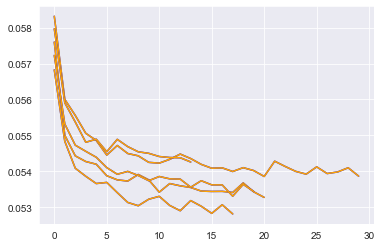

In [41]:
alt_cfg=copy.deepcopy(best_cfg)
alt_cfg['lr']=0.01
alt_cfg['patience']=10
models,losses,mses,epochs=kfold_pytorch(inp, out, alt_cfg)

Loss: 0.053+/-0.001
MSE: 0.053+/-0.001
Epochs: 26.200+/-7.082


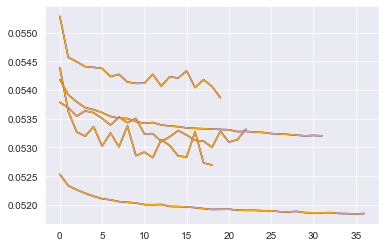

In [55]:
alt_cfg=copy.deepcopy(best_cfg)
alt_cfg['batchnorm']=False
alt_cfg['lr']=0.01
alt_cfg['patience']=10
models,losses,mses,epochs=kfold_pytorch(inp, out, alt_cfg)

In [61]:
y_pred=models[1](torch.from_numpy(x_train).float()).detach().numpy()

In [62]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*y_train[0].shape[0]),y_train[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*y_train[0].shape[0]),y_train[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*y_train[0].shape[0]),y_train[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*y_train[0].shape[0]),y_train[0], a=1, b=1)))

print((y_train[1]-y_train[10]).sum())
print((y_train[50]-y_train[60]).sum())
print((y_train[100]-y_train[110]).sum())

print('Baseline WSE: {:.3f}'.format(WSE2(y_pred[0],y_train[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(y_pred[0],y_train[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(y_pred[0],y_train[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(y_pred[0],y_train[0], a=1, b=1)))

print((y_pred[1]-y_pred[10]).sum())
print((y_pred[50]-y_pred[60]).sum())
print((y_pred[100]-y_pred[110]).sum())

Baseline WSE: 0.187
Baseline WSE l1: 0.148
Baseline MSE: 0.124
Baseline MSE l1: 0.099
-6.0
-1.0
-3.4888888888888894
Baseline WSE: 0.028
Baseline WSE l1: 0.053
Baseline MSE: 0.022
Baseline MSE l1: 0.055
-1.4818069
-0.74170244
-0.30150676


In [63]:
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(y_pred[5],lin[0],dropdummy=False)
print(byteamframe)
reframe, byteamframe = revert_output(y_test[5],lin[0],dropdummy=False)
print(byteamframe)
reframe, byteamframe = revert_output(y_pred[5],lin[0],dropdummy=True)
print(byteamframe)
reframe, byteamframe = revert_output(y_test[5],lin[0],dropdummy=True)
print(byteamframe)

      goals  assists  cards_yellow  cards_red  own_goals  goals_against  \
0  1.596800  0.98618      1.844807   0.215543   0.221593       3.227165   
1  1.618888  1.17931      1.984682   0.085254   0.077807       0.114656   

      saves  
0  6.332410  
1  0.043308  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    2.0      0.0           0.0        0.0        1.0            4.0   12.0
1    1.0      0.0           2.0        0.0        0.0            0.0    0.0
      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  1.596800  0.985677      1.838817   0.213392   0.221593       3.227165   
1  1.618888  1.179310      1.984682   0.082248   0.070265       0.104300   

      saves  
0  6.332410  
1  0.043308  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    2.0      0.0           0.0        0.0        1.0            4.0   12.0
1    1.0      0.0           2.0        0.0        0.0            0.0    0.0


//miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
//miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
//miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [87]:
reframe

minutes     goals   assists  cards_yellow  \
Bartłomiej Drągowski         90.005051  0.000000  0.003322      0.021221   
Cristiano Biraghi            86.387405  0.021630  0.038951      0.073678   
Nikola Milenković            89.309402  0.014951  0.024842      0.168535   
Giacomo Bonaventura          81.018738  0.108495  0.036273      0.125078   
Franck Ribéry                81.949051  0.120268  0.105898      0.099802   
Alfred Duncan                83.117157  0.042901  0.192894      0.086205   
Gaetano Castrovilli          87.209503  0.128416  0.053619      0.177021   
Christian Kouamé             79.297501  0.132839  0.013956      0.089459   
Federico Ceccherini          86.015053  0.071172  0.031208      0.130973   
Martín Cáceres               83.744110  0.017017  0.019891      0.266607   
Federico Chiesa              82.069649  0.068953  0.030645      0.145305   
Pietro Terracciano            0.068193  0.000547  0.000499      0.001039   
Federico Brancolini           8.945202  0.003904  0.005729      0.024799   
Julián Illanes               12.283301  0.018249  0.009150      0.005720   
Borja Valero                  8.910488  0.018174  0.006834      0.036170   
Dušan Vlahović               15.448561  0.010072  0.011987      0.036049   
Riccardo Saponara            10.417287  0.028596  0.018947      0.018429   
Germán Pezzella               7.386743  0.001356  0.008978      0.061412   
Pol Lirola                    6.262692  0.007701  0.000732      0.000370   
Lorenzo Venuti                3.086261  0.002710  0.002998      0.012044   
Cristóbal Montiel Rodríguez   0.399966  0.000359  0.000540      0.000000   
Patrick Cutrone               0.000000  0.001475  0.000000      0.000000   
Igor                          0.000000  0.000082  0.000163      0.000000   
Salvatore Sirigu             88.602676  0.000000  0.000416      0.019513   
Gleison Bremer               83.309494  0.052836  0.046738      0.163369   
Armando Izzo                 86.088203  0.000000  0.014048      0.175074   
Andrea Belotti               78.479279  0.460173  0.168700      0.221173   
Simone Zaza                  88.316521  0.083945  0.087385      0.141039   
Cristian Ansaldi             85.095200  0.256780  0.100878      0.130671   
Álex Berenguer               81.628380  0.083322  0.066617      0.195679   
Soualiho Meïté               83.260651  0.032496  0.138629      0.166068   
Nicolas Nkoulou              78.464577  0.088614  0.071783      0.175684   
Karol Linetty                88.624413  0.091205  0.033532      0.207054   
Tomás Rincón                 90.350800  0.040311  0.073842      0.132872   
Samir Ujkani                  1.415181  0.000638  0.000459      0.003820   
Antonio Rosati               11.367320  0.009770  0.006065      0.028610   
Jacopo Segre                  5.965656  0.016050  0.019205      0.000000   
Saša Lukić                   10.308129  0.000572  0.017446      0.021236   
Iago Falque                  14.331194  0.099089  0.007586      0.055592   
Nicola Rauti                  7.201226  0.032490  0.033851      0.024070   
Vincenzo Millico              8.179290  0.001208  0.010392      0.010225   
Simone Verdi                  7.816347  0.007433  0.009166      0.008537   
Mërgim Vojvoda                1.299311  0.003026  0.004389      0.000000   
Nicola Murru                  0.000000  0.003533  0.001064      0.011537   
Erick Ferigra                 0.000000  0.001806  0.000209      0.000000   
Alessandro Buongiorno         0.132723  0.001068  0.001205      0.005197   

                             cards_red  own_goals  goals_against     saves  \
Bartłomiej Drągowski          0.002269   0.001145       1.423849  2.442269   
Cristiano Biraghi             0.007735   0.005199       0.002982  0.004894   
Nikola Milenković             0.004567   0.002176       0.000001  0.000230   
Giacomo Bonaventura           0.006843   0.001208       0.000001  0.000230   
Franck Ribéry                 0.005151   0.003839       0.000001  0.

# full training

Loss: 0.053
MSE: 0.053
Epochs: 24.000


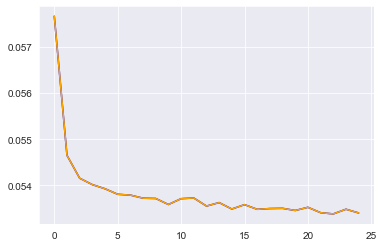

In [15]:
def full_train_pytorch(indata, outdata, config, model=Net, silent=True):   
    
    losses, mses = [],[]
    epochs = []

    drop_last=False
    if config['batchnorm']:
        drop_last=True
        


    training_set = matchesDataset(indata, outdata)
    trainBatch = torch.utils.data.DataLoader(training_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'], drop_last=drop_last)

    net = model(config['num_layers'], config['num_nodes'], config['scaling_factor'], 
                config['num_nodes_out'], config['final_activation'], config['dropout_percent'], config['batchnorm'])  

    net.reset_weights()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)


    if config['optim']=='adam':
        optimizer = Adam(net.parameters(), lr=config['lr'])
    elif config['optim']=='adagrad':
        optimizer = Adagrad(net.parameters(), lr=config['lr'])
    elif config['optim']=='rmsprop':
        optimizer = RMSprop(net.parameters(), lr=config['lr'])    
    else:
        print('optim error')
        return


    exit=False
    net.train(True) 

    #for epoch in tqdm(range(epochs), desc='Epoch'):
    for epoch in range(config['epochs']):

        """ Run the training of the model. """    

        train_loss=0
        train_mse=0
    
        for batchNum, batch in enumerate(trainBatch):

            x = batch[0]
            y = batch[1]

            """ Move batches to GPU if available. """

            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()

            """ Core of training. """
            
            output=net(x)
            loss = config['loss_f'](output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if config['clip']:
                net.clp()
                
            train_loss+=loss.detach().numpy()
            train_mse+=nn.MSELoss()(output, y).detach().numpy()    

        losses.append(train_loss/batchNum) 
        mses.append(train_mse/batchNum)
       
    print('Loss: {:.3f}'.format(losses[-1]))
    print('MSE: {:.3f}'.format(mses[-1]))
    print('Epochs: {:.3f}'.format(epoch))
    
        
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(range(len(losses)), losses, label='loss', color='blue')
    ax.plot(range(len(mses)), mses, label='mse', color='orange')
    plt.show()
    
    return net,losses,mses,epoch

alt_cfg=copy.deepcopy(best_cfg)

alt_cfg['batchnorm']=False
alt_cfg['lr']=0.01
alt_cfg['epochs']=25    

net,losses,mses,epoch = full_train_pytorch(inp, out, alt_cfg, model=Net, silent=True)  

In [16]:
y_pred=net(torch.from_numpy(x_train).float()).detach().numpy()

In [17]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*y_train[0].shape[0]),y_train[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*y_train[0].shape[0]),y_train[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*y_train[0].shape[0]),y_train[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*y_train[0].shape[0]),y_train[0], a=1, b=1)))

print((y_train[1]-y_train[10]).sum())
print((y_train[50]-y_train[60]).sum())
print((y_train[100]-y_train[110]).sum())

print('Baseline WSE: {:.3f}'.format(WSE2(y_pred[0],y_train[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(y_pred[0],y_train[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(y_pred[0],y_train[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(y_pred[0],y_train[0], a=1, b=1)))

print((y_pred[1]-y_pred[10]).sum())
print((y_pred[50]-y_pred[60]).sum())
print((y_pred[100]-y_pred[110]).sum())

Baseline WSE: 0.396
Baseline WSE l1: 0.199
Baseline MSE: 0.264
Baseline MSE l1: 0.133
-2.0
12.988888888888889
5.0
Baseline WSE: 0.127
Baseline WSE l1: 0.098
Baseline MSE: 0.087
Baseline MSE l1: 0.081
-1.3657948
-1.0806625
4.343259


In [18]:
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(y_pred[5],lin[0],dropdummy=False)
print(byteamframe)
reframe, byteamframe = revert_output(y_test[5],lin[0],dropdummy=False)
print(byteamframe)
reframe, byteamframe = revert_output(y_pred[5],lin[0],dropdummy=True)
print(byteamframe)
reframe, byteamframe = revert_output(y_test[5],lin[0],dropdummy=True)
print(byteamframe)

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  1.426222  1.035640      1.962418   0.097468   0.035720       2.515913   
1  1.083077  0.769348      2.048015   0.107930   0.035636       0.030214   

      saves  
0  5.093275  
1  0.030170  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    0.0      0.0           1.0        0.0        0.0            1.0    9.0
1    0.0      0.0           1.0        0.0        1.0            0.0    0.0
      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  1.426222  1.035297      1.958960   0.097468   0.035720       2.515852   
1  1.083077  0.769348      2.047803   0.107528   0.035392       0.030214   

      saves  
0  5.093121  
1  0.030170  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    0.0      0.0           1.0        0.0        0.0            1.0    9.0
1    0.0      0.0           1.0        0.0        1.0            0.0    0.0


//miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
//miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
//miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [21]:
torch.save(net.state_dict(), 'sk_01.pt')